<a href="https://colab.research.google.com/github/hamin32/Extracurricular-activities/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#기존 분석
1σ shock 만큼 충격 변수들이 충격을 줬을때, 곡물들이 어떻게 변할까?

*1σ shock= 그 변수의 평균적인 변동 폭(표준편차)만큼 움직이는 충격

In [3]:
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm

# 설치된 폰트 전체 확인
nanum_fonts = [f.fname for f in fm.fontManager.ttflist if "Nanum" in f.name]
print(nanum_fonts[:5])  # 몇 개만 미리보기

[]


In [4]:
# ===== 패키지 설치 =====
!pip -q install statsmodels==0.14.2 pandas numpy matplotlib

# ===== 임포트 =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# ===== 경로/파라미터 =====
CSV_PATH = "/content/sample_data/지식의항구마스터데이터셋.csv"   # ✅ 사용자 지정
FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"                                  # 글꼴 업로드 안 쓸 때 None
OUT_DIR = "/content/irf_outputs"                     # ✅ 코랩 저장 경로
os.makedirs(OUT_DIR, exist_ok=True)

START_DATE = "2015-01-01"
END_DATE   = "2025-06-30"
STEPS      = 10  # IRF horizon

# ===== 폰트 설정 =====
def setup_korean_font(font_path=None):
    try:
        if font_path and os.path.exists(font_path):
            prop = font_manager.FontProperties(fname=font_path)
            rcParams['font.family'] = prop.get_name()
            print(f"[Font] 사용자 폰트 적용: {prop.get_name()}")
            return prop
        # 코랩 기본 한글 폰트 시도
        cand = [f for f in font_manager.findSystemFonts() if "NotoSansCJK" in f or "NotoSansKR" in f]
        if cand:
            prop = font_manager.FontProperties(fname=cand[0])
            rcParams['font.family'] = prop.get_name()
            print(f"[Font] NotoSansCJK 적용: {prop.get_name()}")
            return prop
        print("[Font] 한글 폰트 미탐색 → 영문 기본 사용")
        return None
    except Exception as e:
        print("[Font] 설정 실패:", e)
        return None

prop = setup_korean_font(FONT_PATH)

# ===== 데이터 로드 =====
assert os.path.exists(CSV_PATH), f"CSV가 보이지 않습니다: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

# 날짜 컬럼 자동 탐지 및 필터링
date_col = None
for cand in ["date","Date","날짜","기준일","기준일자"]:
    if cand in df.columns:
        date_col = cand; break
if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)
    df = df[(df[date_col] >= START_DATE) & (df[date_col] <= END_DATE)].copy()
    df = df.set_index(date_col)

# ===== 분석 대상 9개 페어 =====
pairs = [
    ("Wheat_import_weight_kg","IGREA",2,"IGREA-밀"),
    ("Corn_import_weight_kg" ,"IGREA",1,"IGREA-옥수수"),
    ("Rice_import_weight_kg" ,"IGREA",2,"IGREA-쌀"),
    ("Wheat_import_weight_kg","GSCPI",2,"GSCPI-밀"),
    ("Corn_import_weight_kg" ,"GSCPI",2,"GSCPI-옥수수"),
    ("Rice_import_weight_kg" ,"GSCPI",2,"GSCPI-쌀"),
    ("Wheat_import_weight_kg","CPUI" ,4,"CPUI-밀"),
    ("Corn_import_weight_kg" ,"CPUI" ,4,"CPUI-옥수수"),
    ("Rice_import_weight_kg" ,"CPUI" ,4,"CPUI-쌀"),
]

# ===== 공적분 검정 =====
def has_cointegration(data2: pd.DataFrame, p: int) -> bool:
    k_ar_diff = max(p - 1, 0)
    # Johansen에 넘파이 배열로 전달 (안전)
    j = coint_johansen(data2.values, det_order=0, k_ar_diff=k_ar_diff)
    trace_r0 = float(j.lr1[0])
    crit5_r0 = float(j.cvt[0, 1])
    return trace_r0 > crit5_r0

# ===== IRF 함수 =====
def line_irf(endog_col, shock_col, p, label):
    # 컬럼 체크
    for c in (endog_col, shock_col):
        if c not in df.columns:
            print(f"[SKIP] '{label}' - 컬럼 없음: {c}")
            return
    data = df[[endog_col, shock_col]].dropna()
    if len(data) < max(p + 20, 40):
        print(f"[SKIP] '{label}' - 표본 부족: {len(data)}행")
        return

    # 공적분 여부
    ci = has_cointegration(data, p)

    # 모형 적합 및 IRF
    if ci:
        model_name = "VECM"
        res = VECM(data, k_ar_diff=max(p-1,0), coint_rank=1, deterministic="nc").fit()
        irf = res.irf(STEPS)
    else:
        model_name = "VAR"
        res = VAR(data).fit(p)
        irf = res.irf(STEPS)

    # endog(0번)의 반응: 자기충격(0) vs shock(1)
    resp1 = irf.irfs[:, 0, 0]
    resp2 = irf.irfs[:, 0, 1]

    # 플롯
    x = np.arange(len(resp1))
    plt.figure(figsize=(8,4.8))
    plt.plot(x, resp1, label=f"{endog_col} ← shock:{endog_col}")
    plt.plot(x, resp2, label=f"{endog_col} ← shock:{shock_col}")
    plt.axhline(0, ls="--", lw=1)

    if prop is not None:
        plt.xlabel("Step(월)", fontproperties=prop)
        plt.ylabel("Response", fontproperties=prop)
        plt.title(f"IRF: {label}  (모형={model_name}, p={p})", fontproperties=prop, fontsize=14)
        plt.legend(prop=prop)
    else:
        plt.xlabel("Step(월)")
        plt.ylabel("Response")
        plt.title(f"IRF: {label}  (모형={model_name}, p={p})")
        plt.legend()

    plt.tight_layout()
    safe_label = str(label).replace("/", "_")
    out = os.path.join(OUT_DIR, f"irf_LINE_{safe_label}.png")
    plt.savefig(out, dpi=200)
    plt.close()
    print(f"[SAVED] {out}  (모형={model_name}, p={p}, n={len(data)})")

# ===== 실행 =====
for e, s, p, label in pairs:
    try:
        line_irf(e, s, p, label)
    except Exception as ex:
        print(f"[ERROR] {label}: {ex}")

print("\n끝끝끝 분석 끝끝 완료!!~!")

# ===== 결과 확인 & ZIP 다운로드 =====
from glob import glob
imgs = sorted(glob(os.path.join(OUT_DIR, "*.png")))
print(f"생성 이미지 수: {len(imgs)}")
for pth in imgs[:4]:  # 미리보기 몇 장
    display(pth)

import zipfile
from datetime import datetime
zip_path = f"/content/irf_outputs_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for f in imgs:
        zf.write(f, arcname=os.path.basename(f))
print("ZIP:", zip_path)

from google.colab import files
files.download(zip_path)



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[Font] 사용자 폰트 적용: NanumGothic


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_IGREA-밀.png  (모형=VECM, p=2, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_IGREA-옥수수.png  (모형=VECM, p=1, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_IGREA-쌀.png  (모형=VECM, p=2, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_GSCPI-밀.png  (모형=VECM, p=2, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_GSCPI-옥수수.png  (모형=VECM, p=2, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_GSCPI-쌀.png  (모형=VECM, p=2, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_CPUI-밀.png  (모형=VECM, p=4, n=125)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[SAVED] /content/irf_outputs/irf_LINE_CPUI-옥수수.png  (모형=VECM, p=4, n=125)


[SAVED] /content/irf_outputs/irf_LINE_CPUI-쌀.png  (모형=VECM, p=4, n=125)

끝끝끝 분석 끝끝 완료!!~!
생성 이미지 수: 9


'/content/irf_outputs/irf_LINE_CPUI-밀.png'

'/content/irf_outputs/irf_LINE_CPUI-쌀.png'

'/content/irf_outputs/irf_LINE_CPUI-옥수수.png'

'/content/irf_outputs/irf_LINE_GSCPI-밀.png'

ZIP: /content/irf_outputs_20250922_120403.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

생성 이미지 수: 9


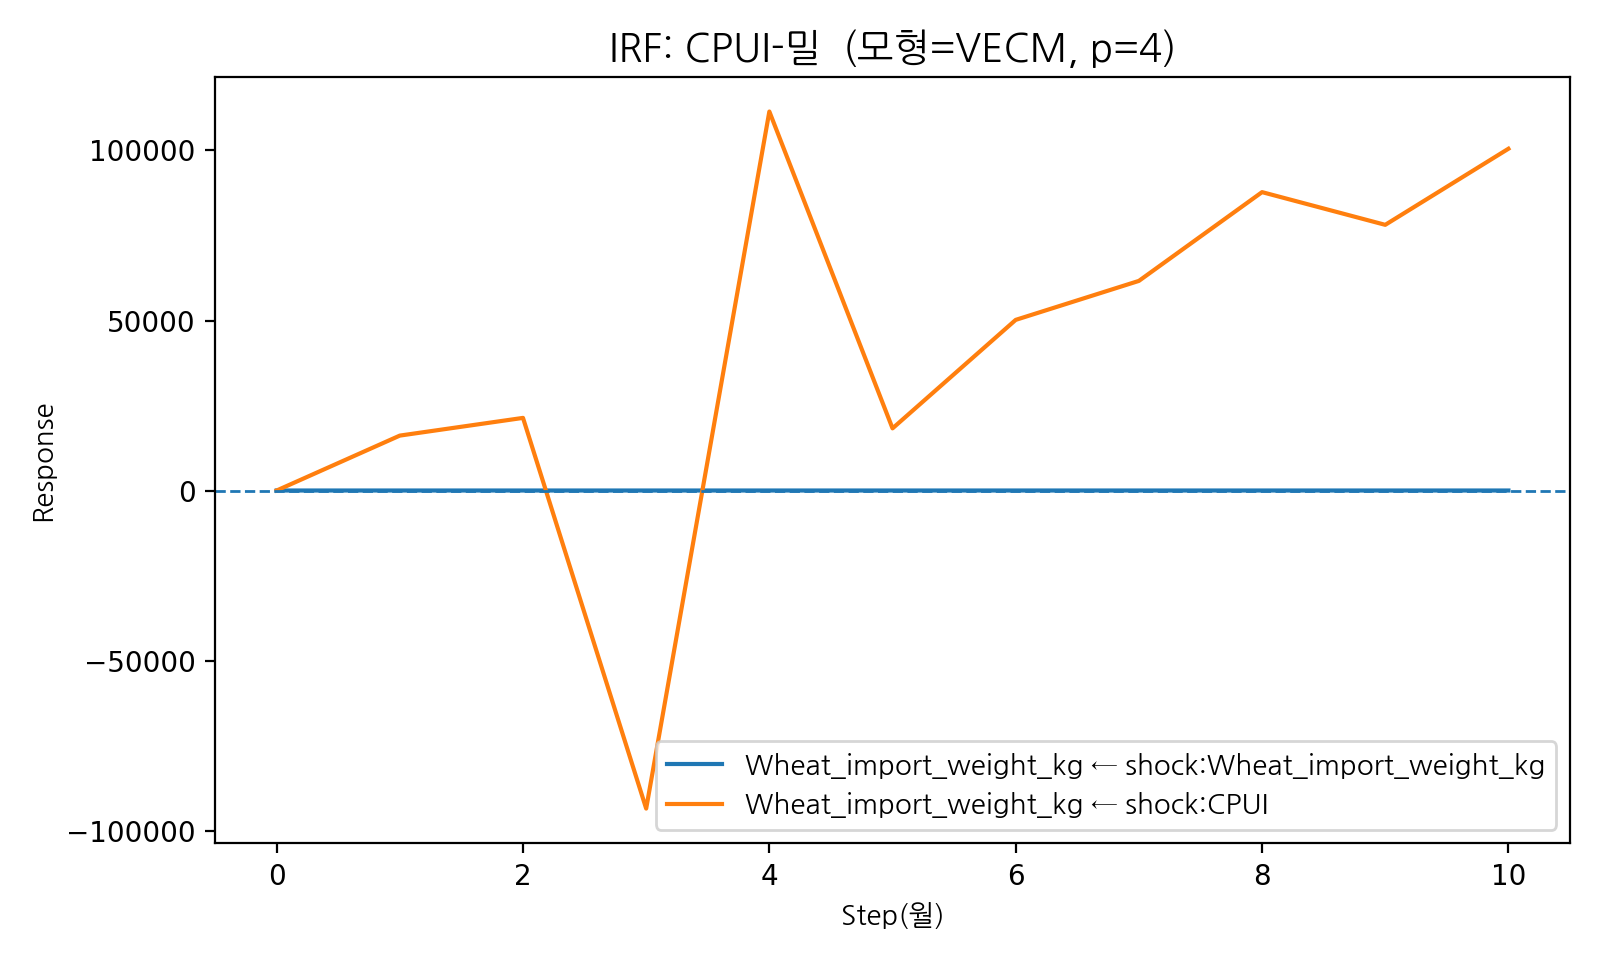

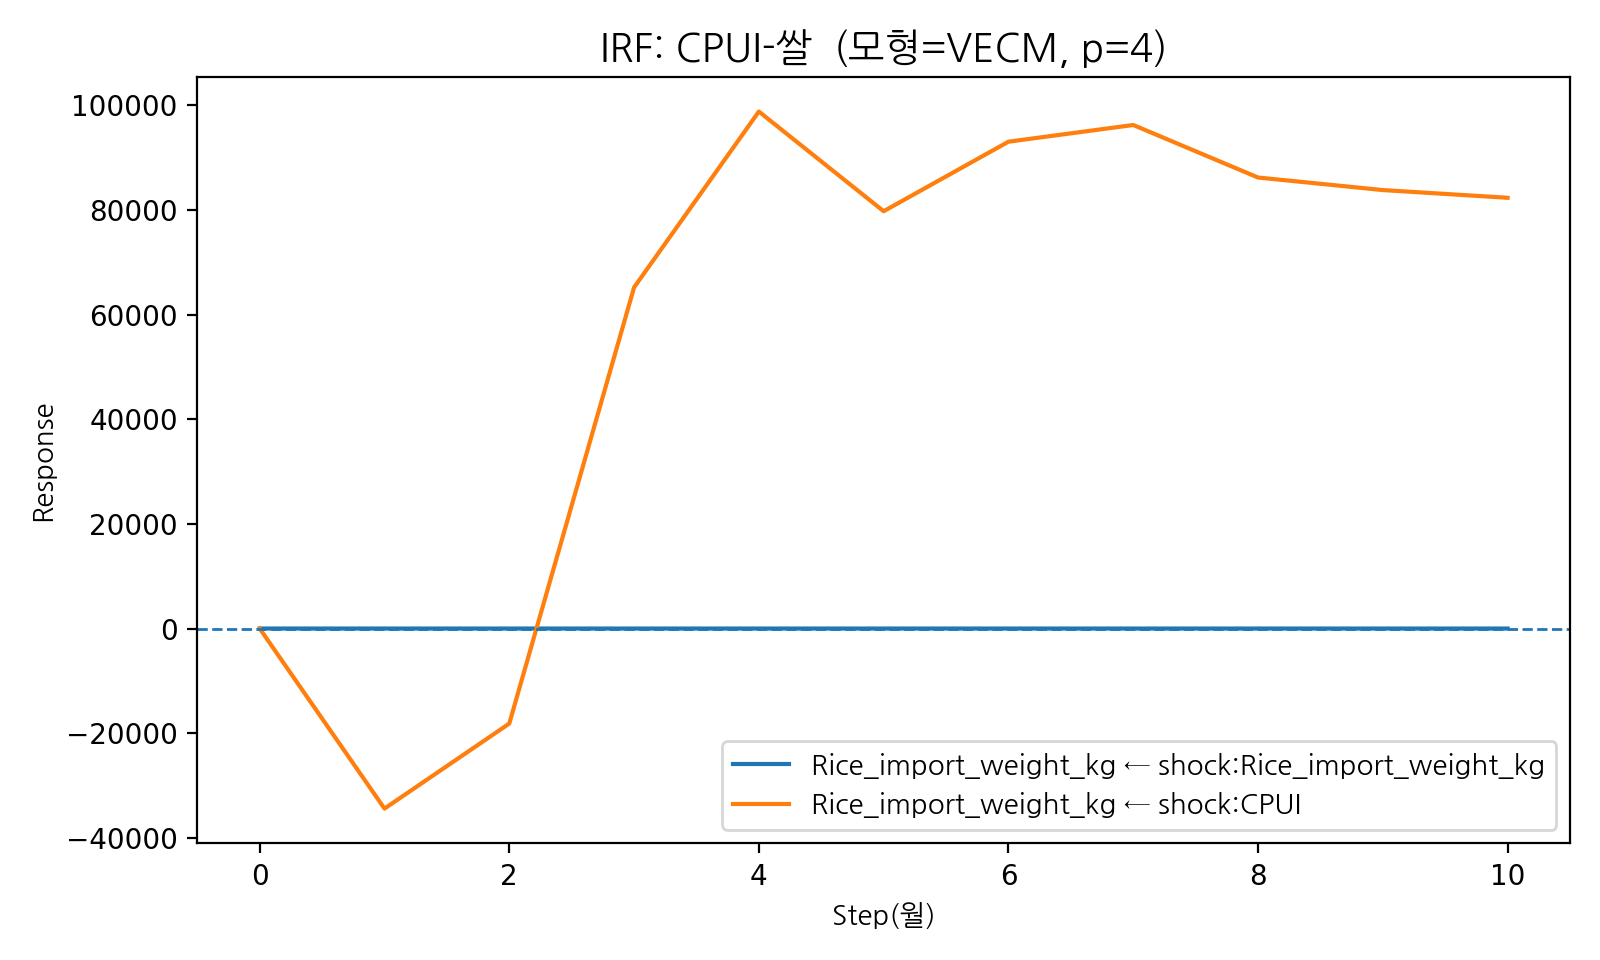

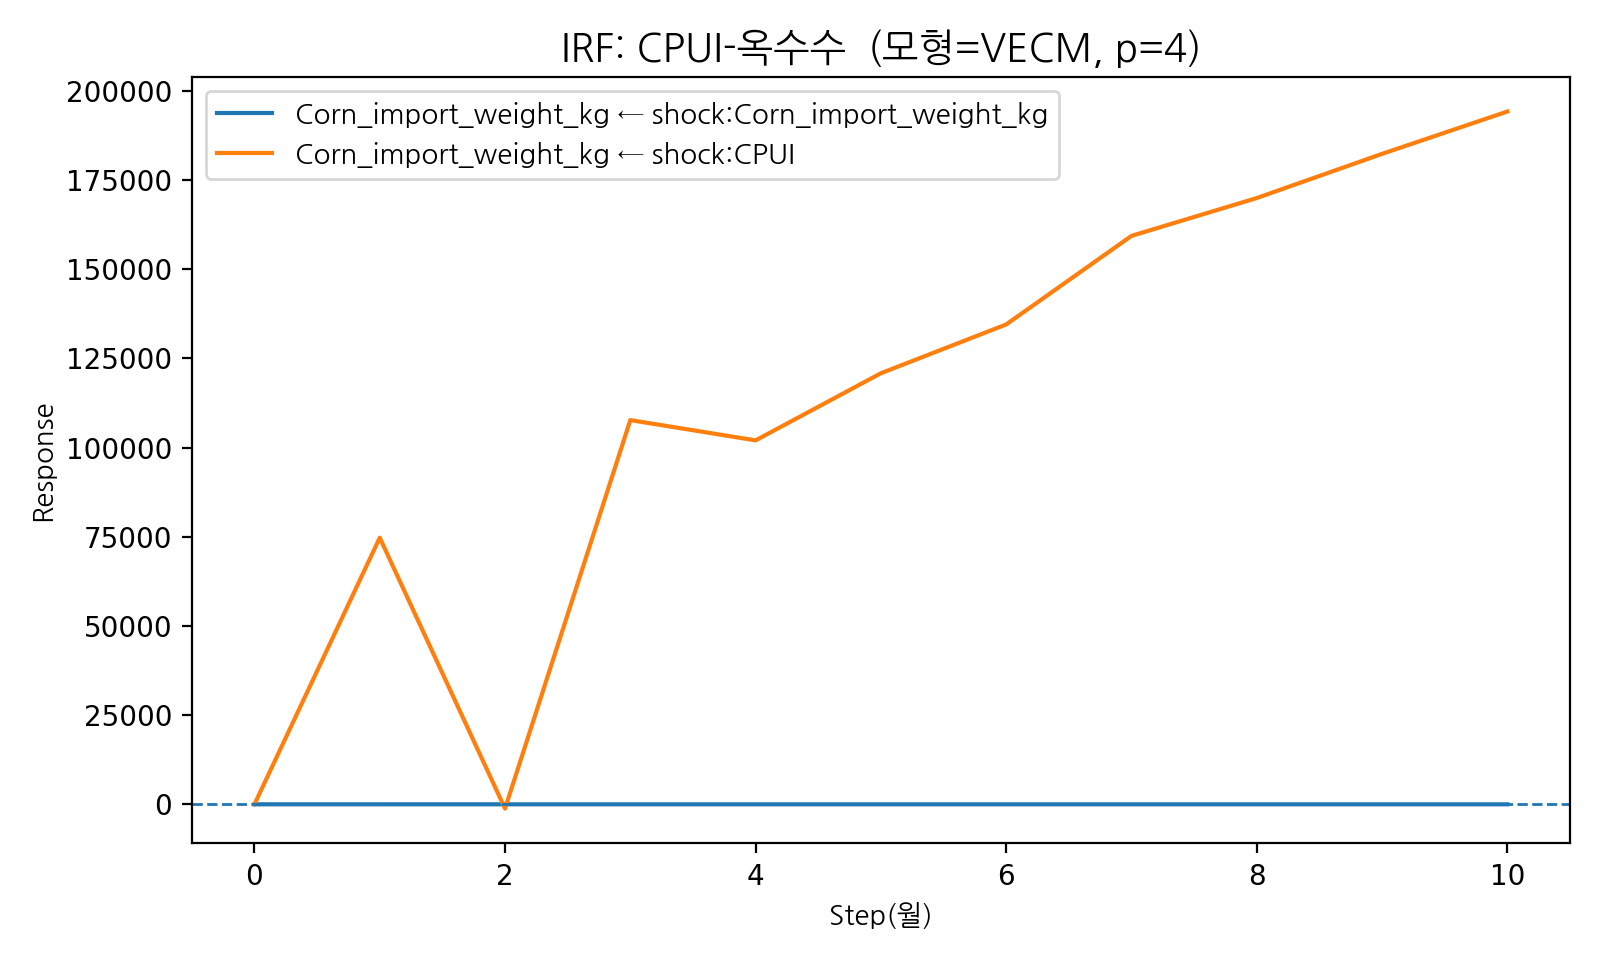

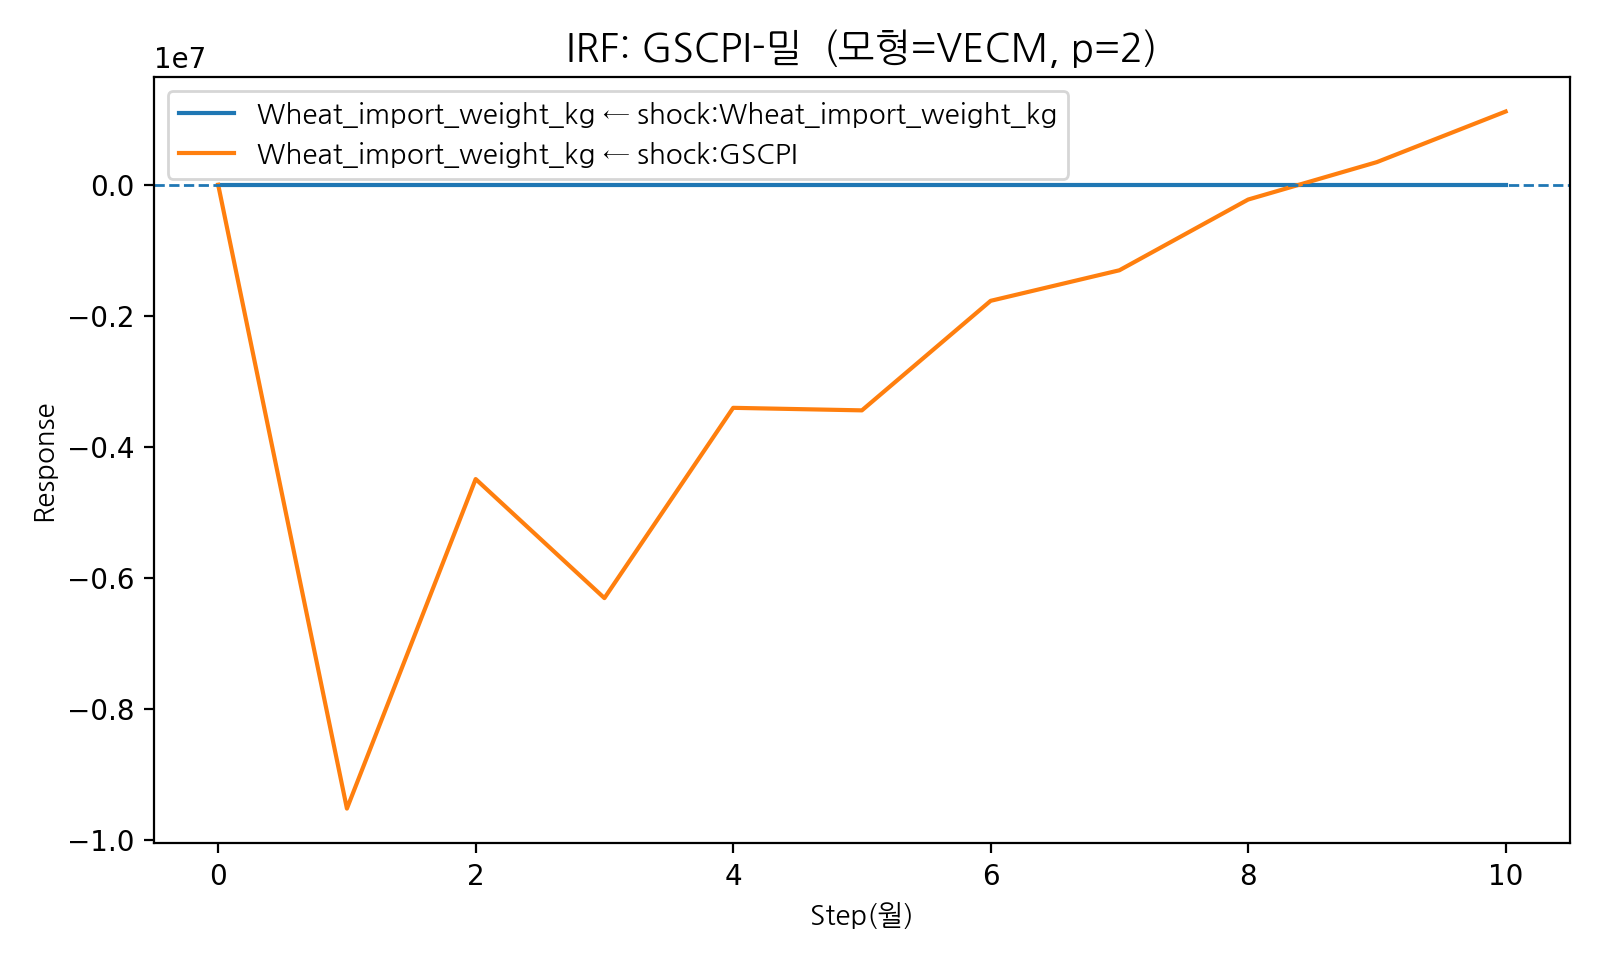

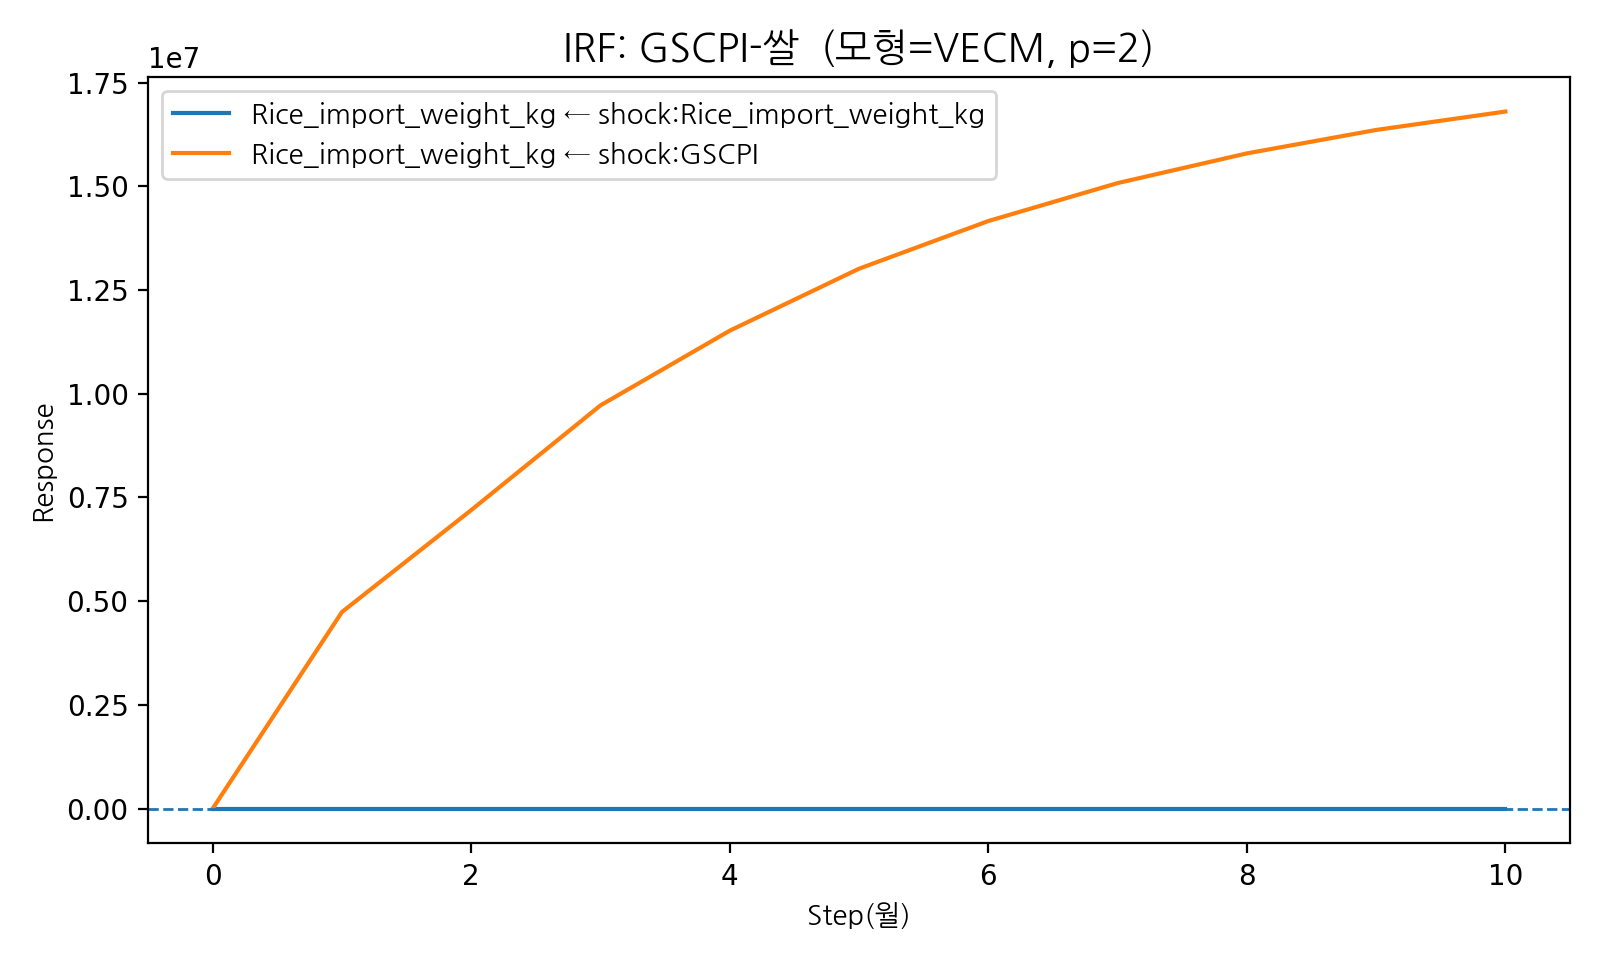

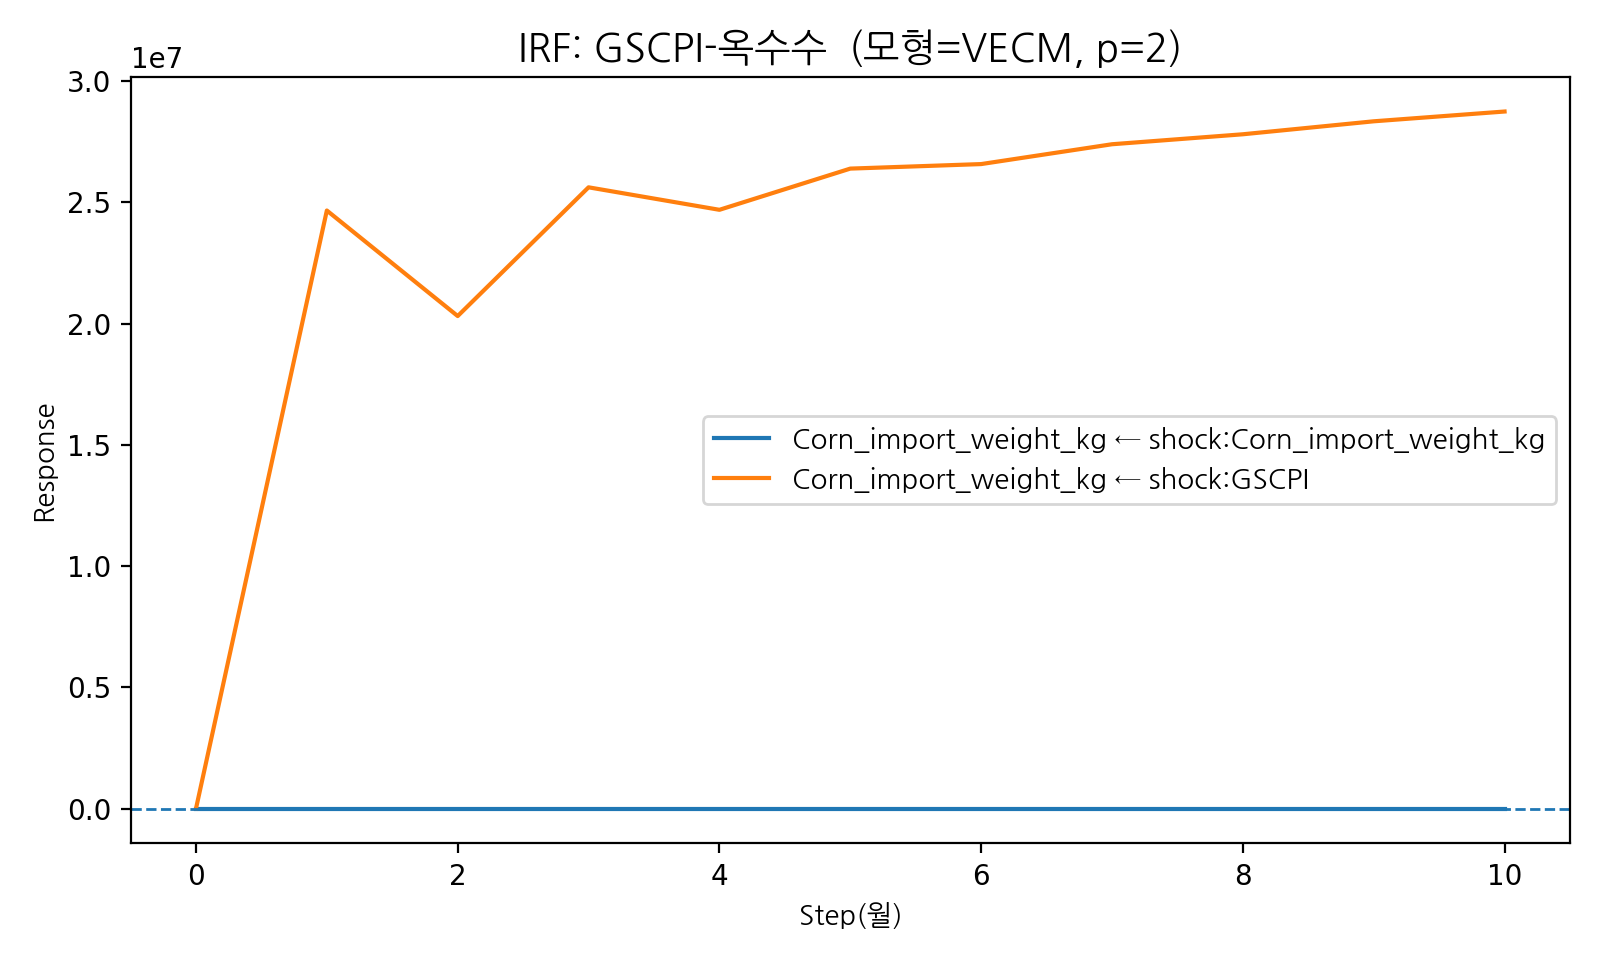

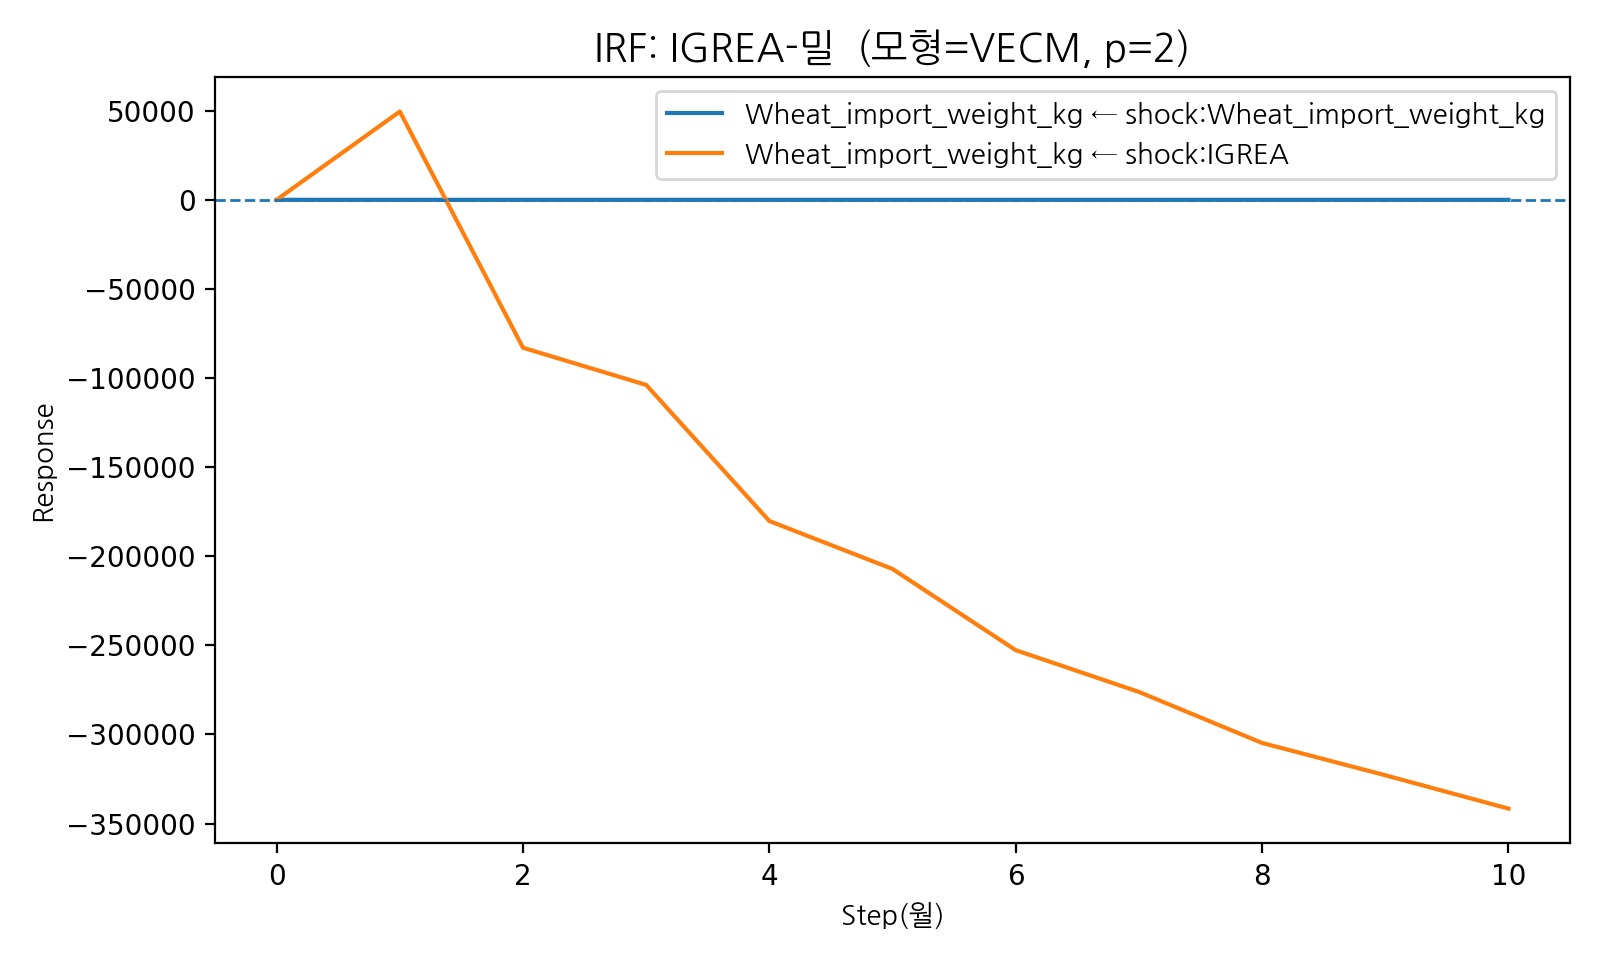

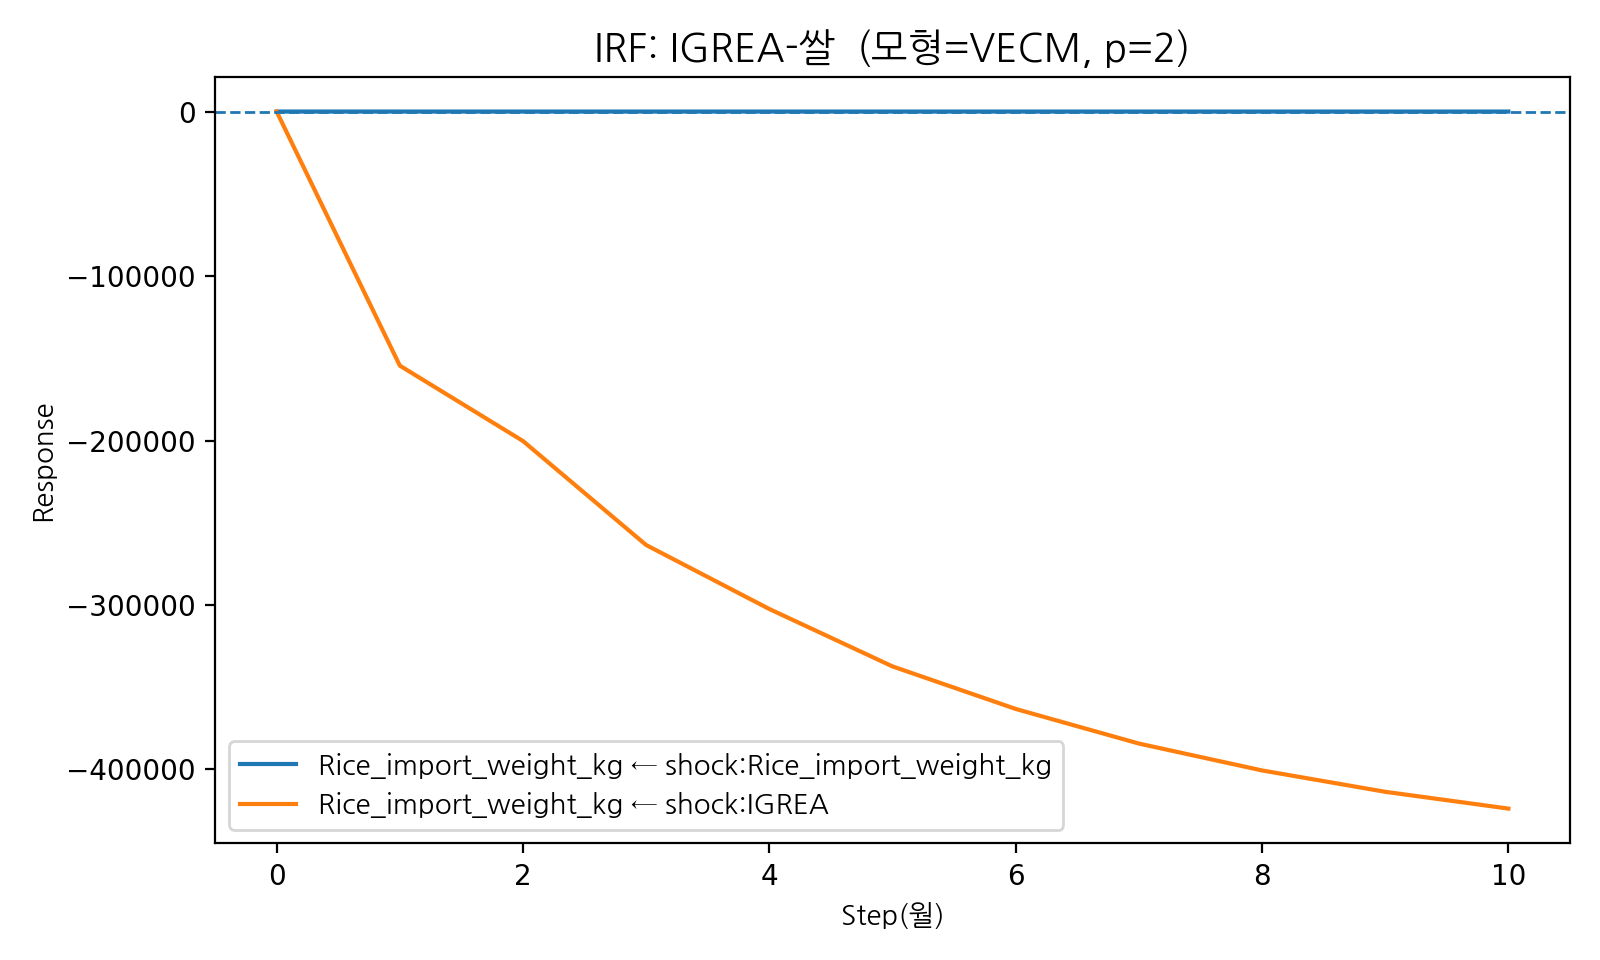

In [5]:
# 미리보기 제대로 표시
from IPython.display import Image, display
from glob import glob
imgs = sorted(glob("/content/irf_outputs/*.png"))
print(f"생성 이미지 수: {len(imgs)}")
for p in imgs:   # 원하는 개수로 슬라이싱 가능
    display(Image(filename=p))



#추가분석= '글로벌 쇼크 상태가 왔을때, 어떤 상황이 이어질까?' 분석

-글로벌 쇼크 시나리오
1. 전쟁/지정학적 분쟁

2. 팬데믹/전염병

3. 금융위기

4. 기후 재해

5. 정책·제재

-분석 과정
① 유형별 사건 정의 → ② 심각도 레벨화 → ③ 실제 사례 기반 변동폭 계량화 → ④ IRF 적용

#시나리오 유형 + 심각성 단계

🔴 전쟁 / 지정학적 분쟁

Level 1 (국지 분쟁) : 걸프전 초기, 단기 무역 차질

IGREA +10%

GSCPI +5%

CPUI +3%

Level 2 (지역 전쟁) : 러시아–조지아 전쟁(2008)

IGREA +20%

GSCPI +10%

CPUI +5%

Level 3 (글로벌 전쟁) : 러시아–우크라이나 전쟁(2022)

IGREA +40%

GSCPI ±20% (일부 구간 급등/급락)

CPUI +6%

----

🦠 팬데믹 / 전염병

Level 1 (국지 전염병) : 사스(2003)

GSCPI +5%

IGREA +3%

Level 2 (중규모) : 메르스(2015), 에볼라 국지 확산

GSCPI +10~15%

IGREA +5%

CPUI 미약한 영향

Level 3 (글로벌 팬데믹) : COVID-19 (2020)

GSCPI +30% 이상

IGREA +10%

CPUI ±5%

----

💰 금융위기

Level 1 (국지 금융 불안) : 아시아 외환위기 일부 국가

IGREA −10%

CPUI −3%

Level 2 (지역 금융위기) : 유럽 재정위기(2010)

IGREA −20%

CPUI −5%

Level 3 (글로벌 금융위기) : 2008 리먼 사태

IGREA −40%

CPUI −10%

----

🌱 기후 재해

Level 1 (국지 기후 충격) : 특정 국가 가뭄 → 곡물 수입 증가

IGREA +5%

GSCPI +3%

Level 2 (지역 기후 충격) : 인도/동남아 폭염 → 쌀 수출 제한

IGREA +15%

GSCPI +10%

Level 3 (글로벌 기후 이벤트) : 엘니뇨, 전 지구적 흉작

IGREA +30%

GSCPI +15%

CPUI +10%

----

📜 정책·제재

Level 1 (국지 정책 변화) : 특정국가 수출 제한

IGREA +5%

CPUI +3%

Level 2 (지역 제재) : 미중 무역분쟁(2018)

IGREA +10%

GSCPI +5%

CPUI +5%

Level 3 (글로벌 제재) : 대규모 원자재 제재

IGREA +20%

GSCPI +10%

CPUI +8%

In [6]:
# ===== 시나리오 정의 =====
scenarios = {
    "war": {  # 전쟁/지정학적 분쟁
        1: {"IGREA":0.10, "GSCPI":0.05, "CPUI":0.03},   # 걸프전 초기 등
        2: {"IGREA":0.20, "GSCPI":0.10, "CPUI":0.05},   # 지역 전쟁
        3: {"IGREA":0.40, "GSCPI":0.20, "CPUI":0.06},   # 러-우 전쟁
    },
    "pandemic": {  # 팬데믹/전염병
        1: {"IGREA":0.03, "GSCPI":0.05, "CPUI":0.00},   # 사스
        2: {"IGREA":0.05, "GSCPI":0.15, "CPUI":0.02},   # 메르스/에볼라
        3: {"IGREA":0.10, "GSCPI":0.30, "CPUI":0.05},   # 코로나19
    },
    "finance": {  # 금융위기
        1: {"IGREA":-0.10, "GSCPI":0.00, "CPUI":-0.03}, # 아시아 외환위기
        2: {"IGREA":-0.20, "GSCPI":0.00, "CPUI":-0.05}, # 유럽 재정위기
        3: {"IGREA":-0.40, "GSCPI":0.00, "CPUI":-0.10}, # 글로벌 금융위기
    },
    "climate": {  # 기후 재해
        1: {"IGREA":0.05, "GSCPI":0.03, "CPUI":0.00},   # 국지 가뭄
        2: {"IGREA":0.15, "GSCPI":0.10, "CPUI":0.05},   # 지역 폭염
        3: {"IGREA":0.30, "GSCPI":0.15, "CPUI":0.10},   # 엘니뇨
    },
    "policy": {  # 정책/제재
        1: {"IGREA":0.05, "GSCPI":0.00, "CPUI":0.03},   # 국지 수출제한
        2: {"IGREA":0.10, "GSCPI":0.05, "CPUI":0.05},   # 미중 무역분쟁
        3: {"IGREA":0.20, "GSCPI":0.10, "CPUI":0.08},   # 대규모 제재
    }
}


In [36]:
# ===== Functions =====
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, VECM

STEPS = 50   # impulse response 기간 (예: 50개월)

def has_cointegration(data, p):
    """(임시 버전) 항상 cointegration 있다고 가정"""
    # 실제 검정이 필요하면 johansen test 넣을 수 있음
    return True

def line_irf(endog_col, shock_col, p, label, shock_pct=1.0):
    """
    endog_col: response variable (e.g. Wheat_import_weight_kg)
    shock_col: shock variable (e.g. IGREA/GSCPI/CPUI)
    p: lag order
    label: label for output
    shock_pct: shock size multiplier (1.0 = 1σ shock, 0.2 = 20% shock, etc.)
    """
    # column check
    for c in (endog_col, shock_col):
        if c not in df.columns:
            print(f"[SKIP] '{label}' - no column: {c}")
            return

    data = df[[endog_col, shock_col]].dropna()
    if len(data) < max(p + 20, 40):
        print(f"[SKIP] '{label}' - too few samples: {len(data)} rows")
        return

    # cointegration check
    ci = has_cointegration(data, p)

    # fit model
    if ci:
        model_name = "VECM"
        res = VECM(data, k_ar_diff=max(p-1,0), coint_rank=1, deterministic="nc").fit()
        irf = res.irf(STEPS)
    else:
        model_name = "VAR"
        res = VAR(data).fit(p)
        irf = res.irf(STEPS)

    # responses (baseline = 1σ shock)
    resp1 = irf.irfs[:, 0, 0] * shock_pct   # endog ← shock:endog
    resp2 = irf.irfs[:, 0, 1] * shock_pct   # endog ← shock:shock_col

    # --- plot ---
    x = np.arange(len(resp1))
    plt.figure(figsize=(8, 4.8))
    plt.plot(x, resp1, label=f"{endog_col} ← shock:{endog_col}")
    plt.plot(x, resp2, label=f"{endog_col} ← shock:{shock_col}")
    plt.axhline(0, ls="--", lw=1)

    plt.xlabel("Step (month)")
    plt.ylabel("Response")
    plt.title(f"IRF: {label} (Model={model_name}, p={p}, shock={shock_pct:+.0%})")
    plt.legend()
    plt.tight_layout()

    # ✅ 바로 출력
    plt.show()

    print(f"[DISPLAYED] {label} (Model={model_name}, p={p}, shock={shock_pct:+.0%}, n={len(data)})")


def run_scenario(scenario_name, level, crop="Wheat_import_weight_kg", p=2):
    """
    Run IRF for all shocks defined in a given scenario/level
    crop: crop column (Wheat/Corn/Rice)
    p: lag order
    """
    if scenario_name not in scenarios:
        print(f"[ERROR] Scenario '{scenario_name}' not defined")
        return
    shocks = scenarios[scenario_name].get(level)
    if shocks is None:
        print(f"[ERROR] '{scenario_name}' L{level} not defined")
        return

    for shock_var, shock_pct in shocks.items():
        label = f"{shock_var}-{crop} ({scenario_name} L{level}, {shock_pct:+.0%})"
        try:
            line_irf(crop, shock_var, p, label, shock_pct=shock_pct)
        except Exception as e:
            print(f"[ERROR] {label}: {e}")


In [38]:
def run_all_scenarios(crops=None, p=2):
    """
    Run all scenarios × levels × crops
    crops: list of crop column names. If None, default = Wheat, Corn, Rice
    p: lag order
    """
    if crops is None:
        crops = ["Wheat_import_weight_kg",
                 "Corn_import_weight_kg",
                 "Rice_import_weight_kg"]

    for scenario_name, levels in scenarios.items():
        for level, shocks in levels.items():
            for crop in crops:
                print(f"\n=== Scenario: {scenario_name} | Level {level} | Crop: {crop} ===")
                for shock_var, shock_pct in shocks.items():
                    label = f"{shock_var}-{crop} ({scenario_name} L{level}, {shock_pct:+.0%})"
                    try:
                        line_irf(crop, shock_var, p, label, shock_pct=shock_pct)
                    except Exception as e:
                        print(f"[ERROR] {label}: {e}")


In [43]:
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

def run_scenario_group(scenario_name, crops=None, p=2):
    """
    Run all levels of a given scenario for selected crops
    scenario_name: one of ["war", "pandemic", "finance", "climate", "policy"]
    crops: list of crop column names. If None, default = Wheat, Corn, Rice
    p: lag order
    """
    if crops is None:
        crops = ["Wheat_import_weight_kg",
                 "Corn_import_weight_kg",
                 "Rice_import_weight_kg"]

    if scenario_name not in scenarios:
        print(f"[ERROR] Scenario '{scenario_name}' not found")
        return

    for level, shocks in scenarios[scenario_name].items():
        for crop in crops:
            print(f"\n=== Scenario: {scenario_name} | Level {level} | Crop: {crop} ===")
            for shock_var, shock_pct in shocks.items():
                label = f"{shock_var}-{crop} ({scenario_name} L{level}, {shock_pct:+.0%})"
                try:
                    line_irf(crop, shock_var, p, label, shock_pct=shock_pct)
                except Exception as e:
                    print(f"[ERROR] {label}: {e}")




=== Scenario: war | Level 1 | Crop: Wheat_import_weight_kg ===


[DISPLAYED] IGREA-Wheat_import_weight_kg (war L1, +10%) (Model=VECM, p=2, shock=+10%, n=125)


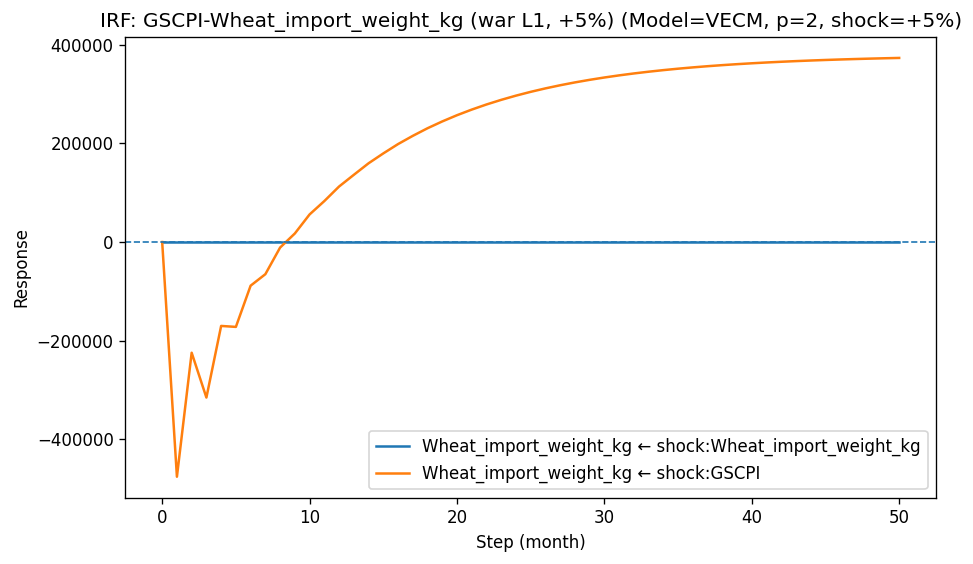

[DISPLAYED] GSCPI-Wheat_import_weight_kg (war L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


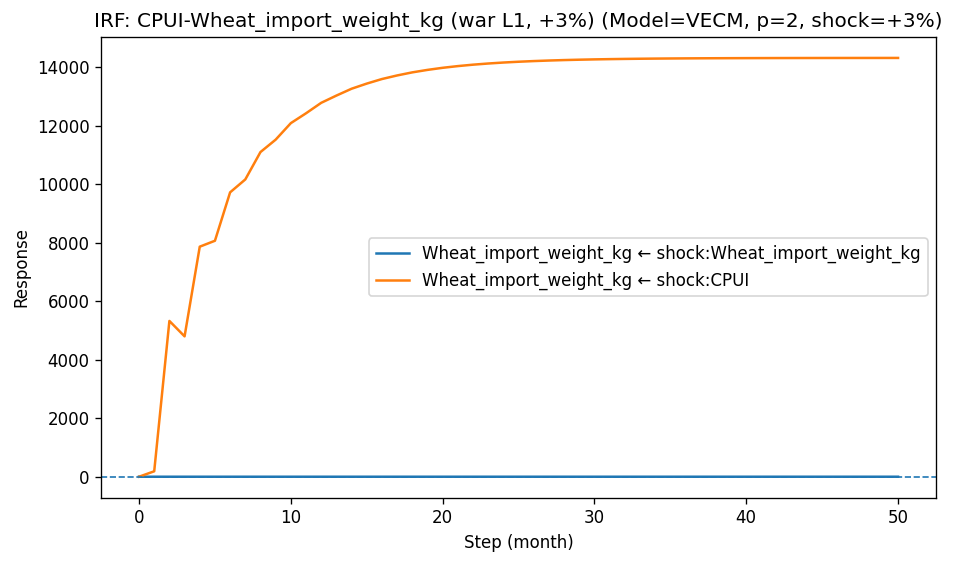

[DISPLAYED] CPUI-Wheat_import_weight_kg (war L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: war | Level 1 | Crop: Corn_import_weight_kg ===


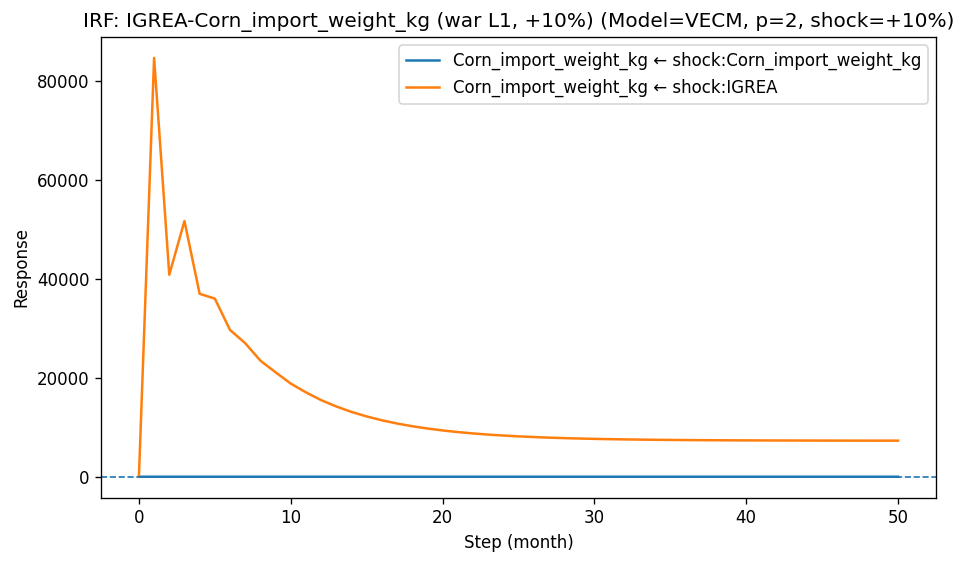

[DISPLAYED] IGREA-Corn_import_weight_kg (war L1, +10%) (Model=VECM, p=2, shock=+10%, n=125)


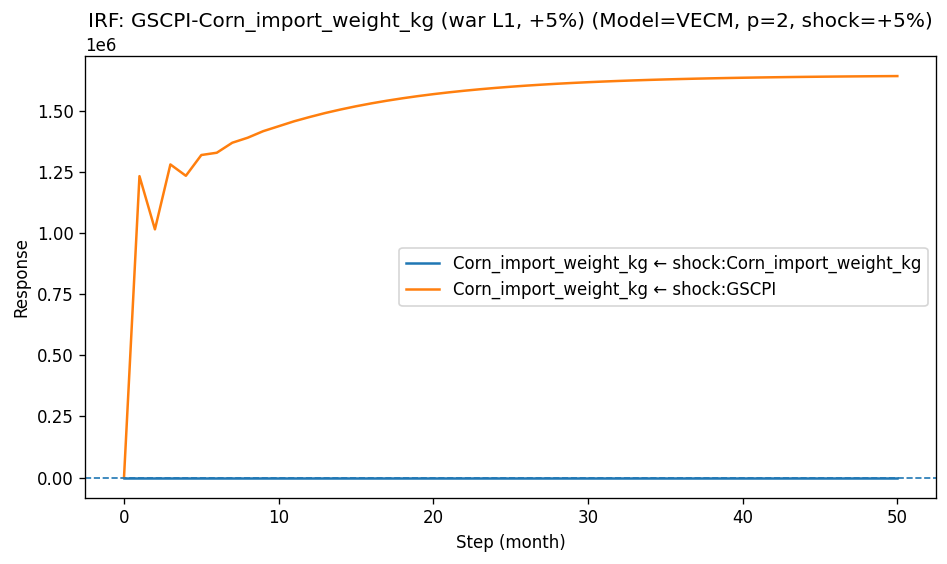

[DISPLAYED] GSCPI-Corn_import_weight_kg (war L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


[DISPLAYED] CPUI-Corn_import_weight_kg (war L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: war | Level 1 | Crop: Rice_import_weight_kg ===


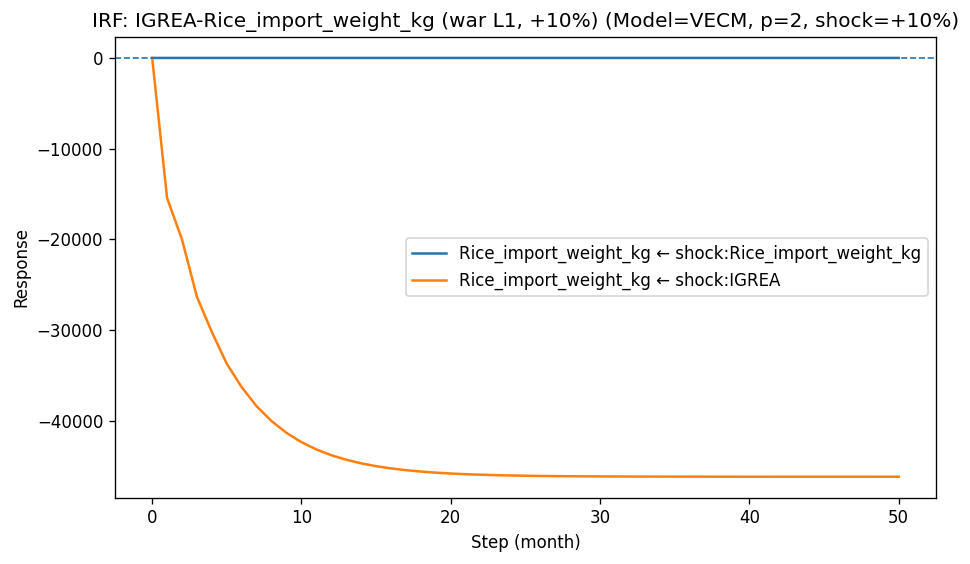

[DISPLAYED] IGREA-Rice_import_weight_kg (war L1, +10%) (Model=VECM, p=2, shock=+10%, n=125)


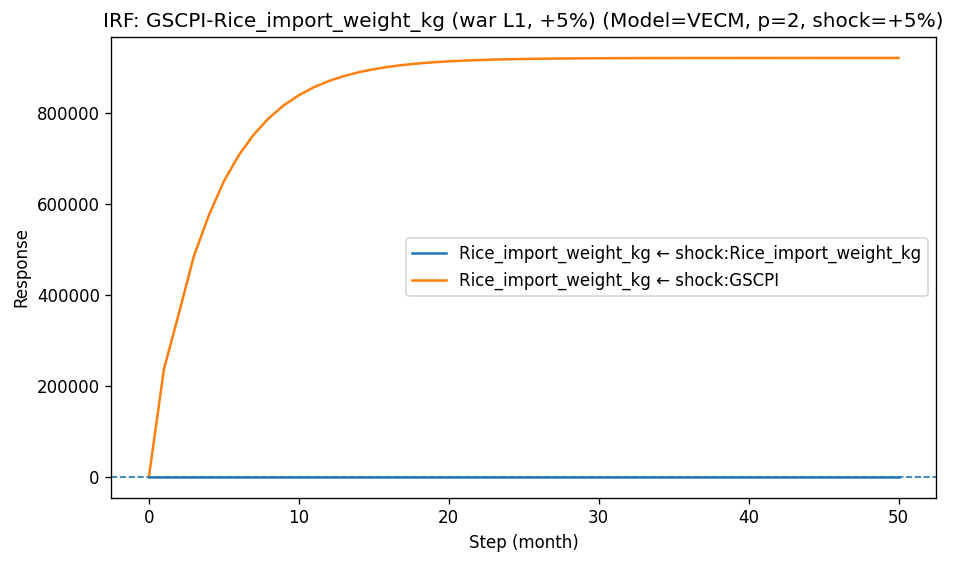

[DISPLAYED] GSCPI-Rice_import_weight_kg (war L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


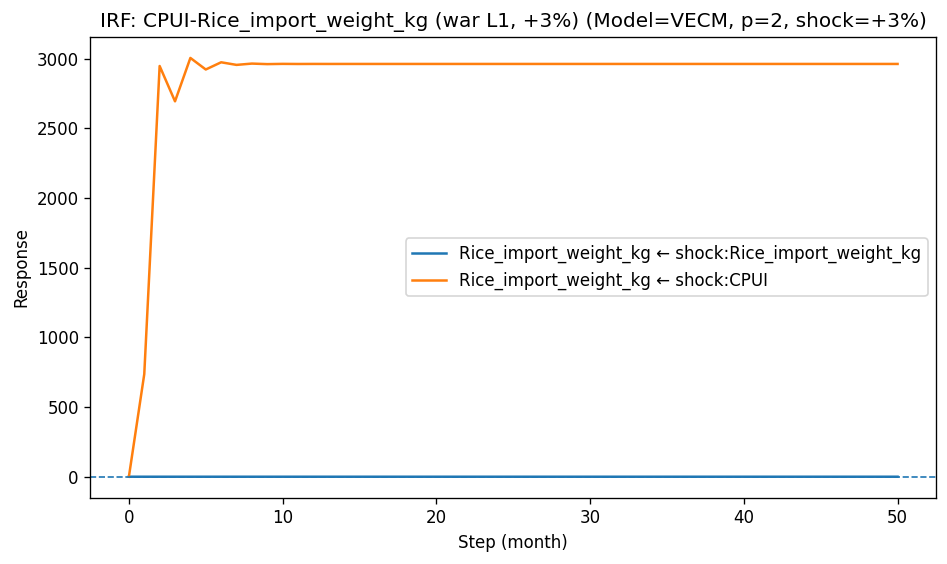

[DISPLAYED] CPUI-Rice_import_weight_kg (war L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: war | Level 2 | Crop: Wheat_import_weight_kg ===


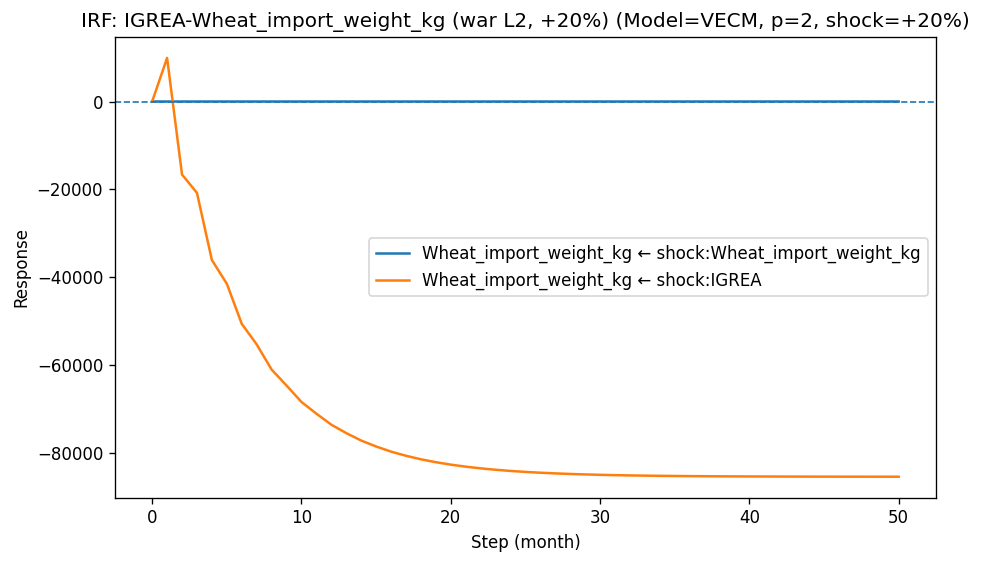

[DISPLAYED] IGREA-Wheat_import_weight_kg (war L2, +20%) (Model=VECM, p=2, shock=+20%, n=125)


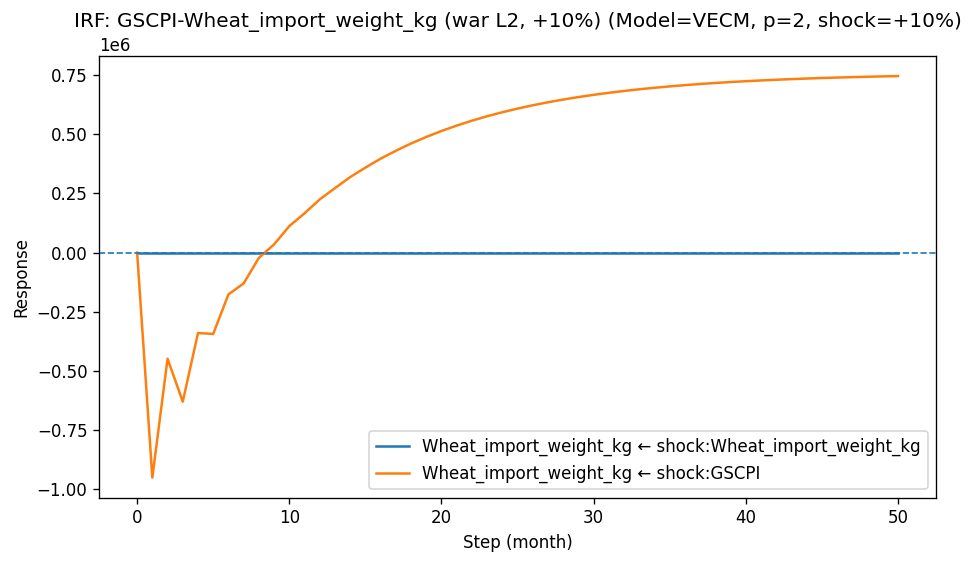

[DISPLAYED] GSCPI-Wheat_import_weight_kg (war L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


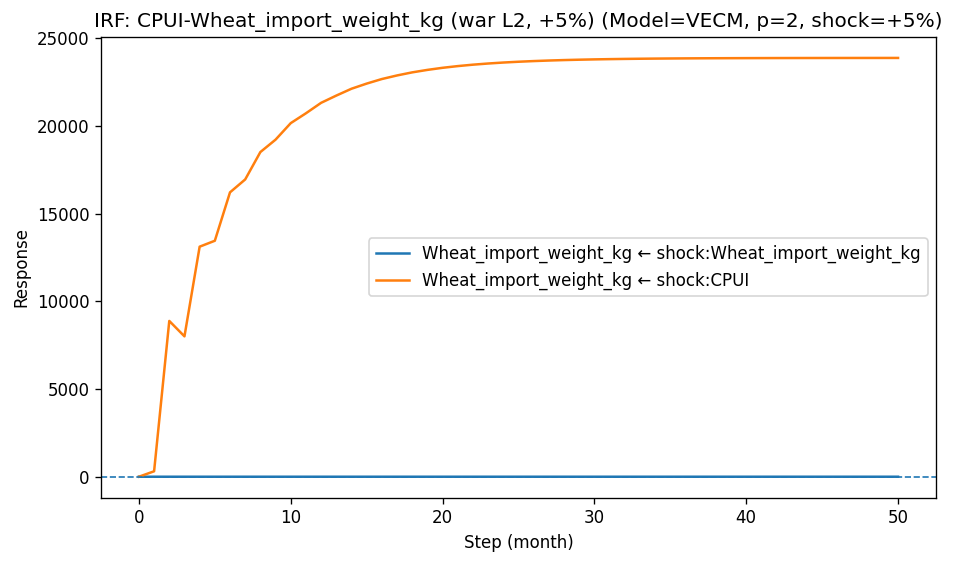

[DISPLAYED] CPUI-Wheat_import_weight_kg (war L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: war | Level 2 | Crop: Corn_import_weight_kg ===


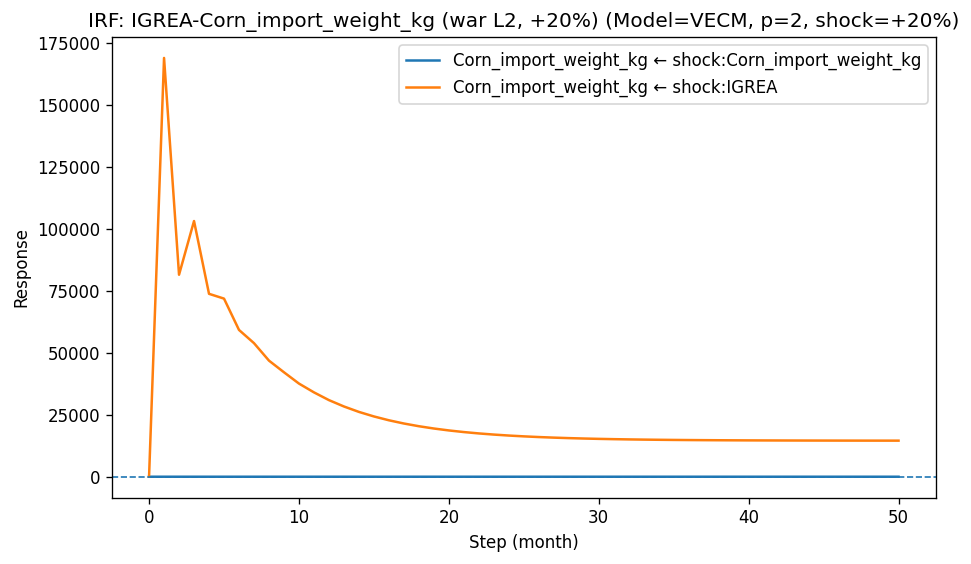

[DISPLAYED] IGREA-Corn_import_weight_kg (war L2, +20%) (Model=VECM, p=2, shock=+20%, n=125)


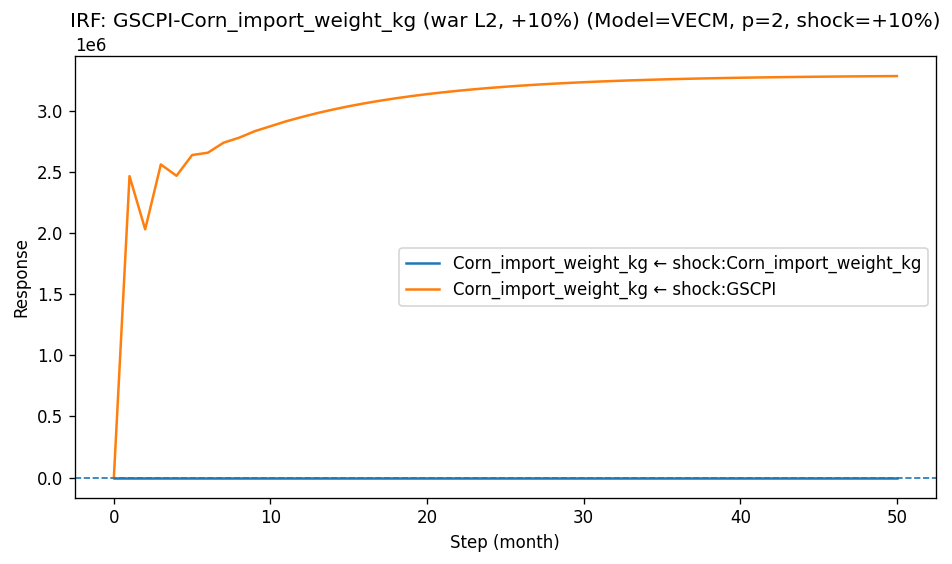

[DISPLAYED] GSCPI-Corn_import_weight_kg (war L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


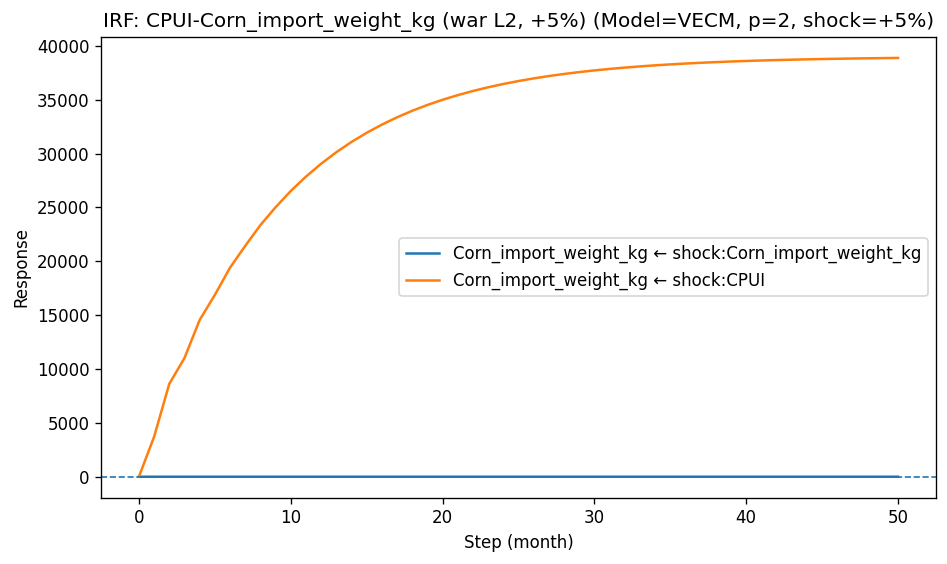

[DISPLAYED] CPUI-Corn_import_weight_kg (war L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: war | Level 2 | Crop: Rice_import_weight_kg ===


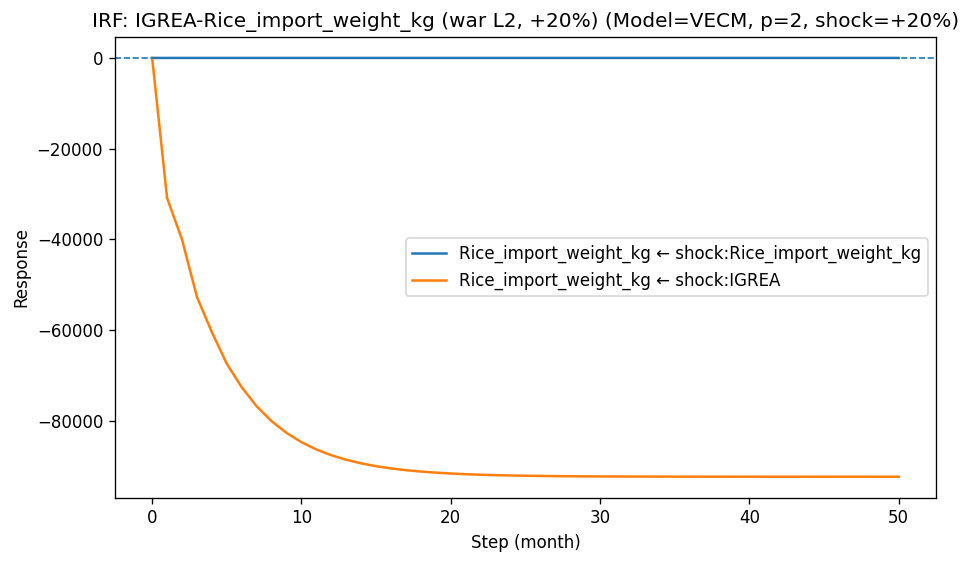

[DISPLAYED] IGREA-Rice_import_weight_kg (war L2, +20%) (Model=VECM, p=2, shock=+20%, n=125)


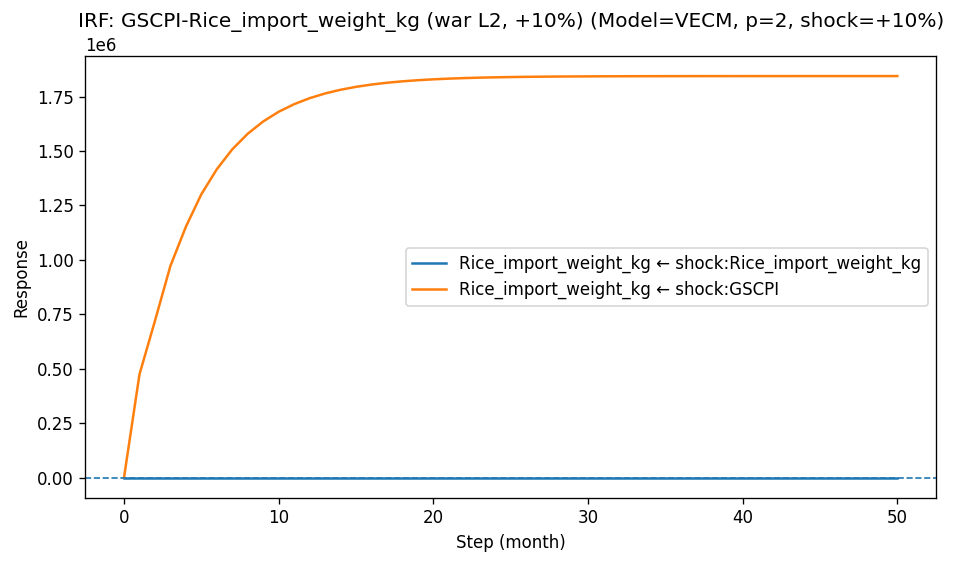

[DISPLAYED] GSCPI-Rice_import_weight_kg (war L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


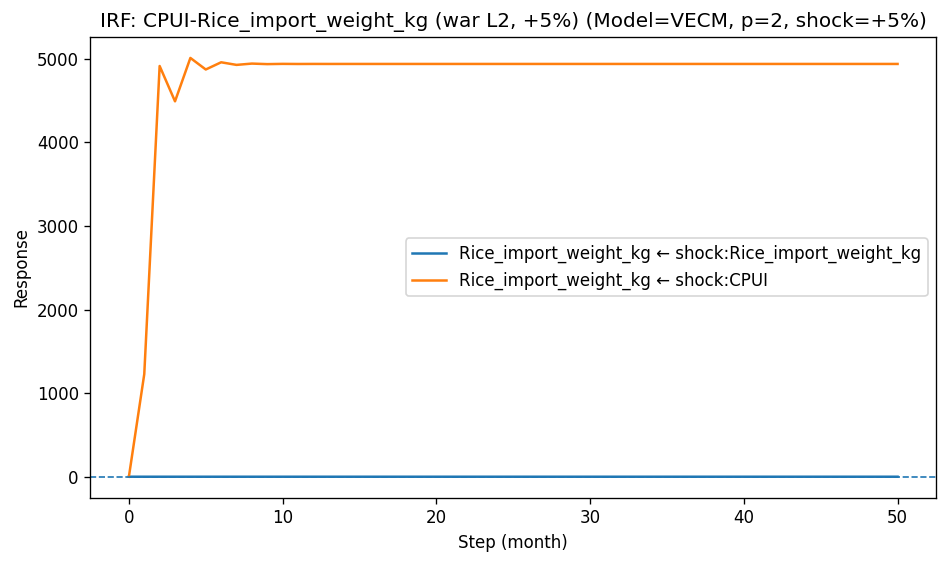

[DISPLAYED] CPUI-Rice_import_weight_kg (war L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: war | Level 3 | Crop: Wheat_import_weight_kg ===


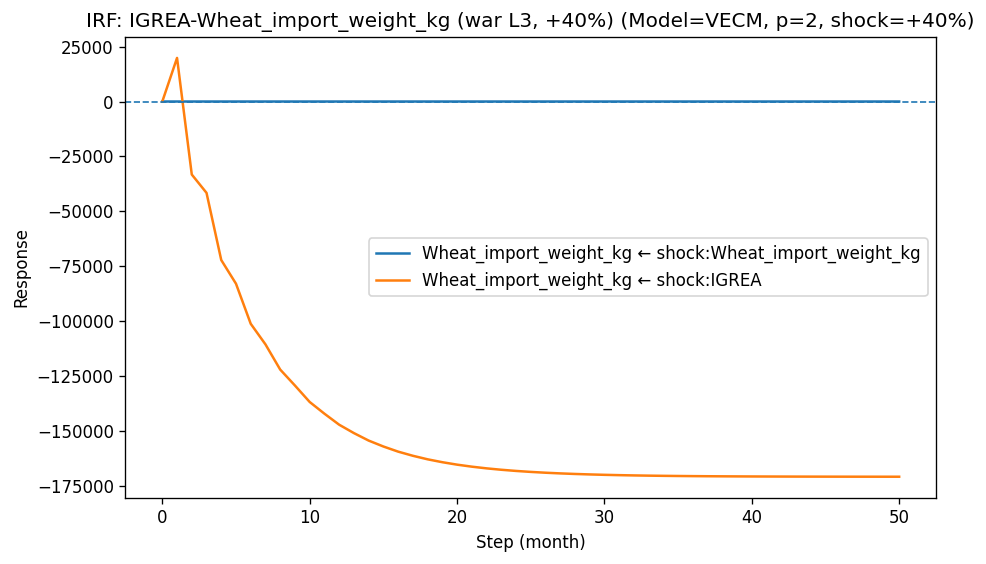

[DISPLAYED] IGREA-Wheat_import_weight_kg (war L3, +40%) (Model=VECM, p=2, shock=+40%, n=125)


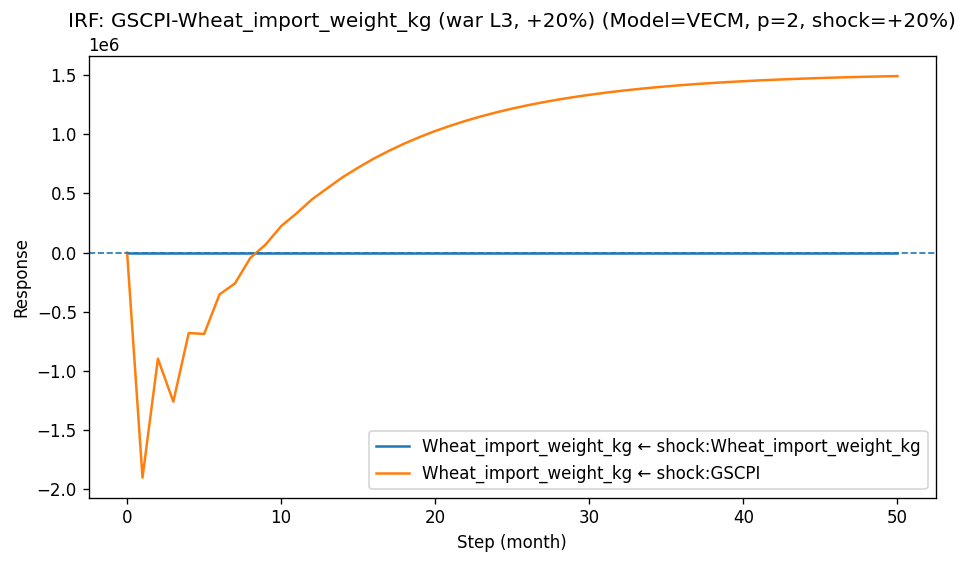

[DISPLAYED] GSCPI-Wheat_import_weight_kg (war L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


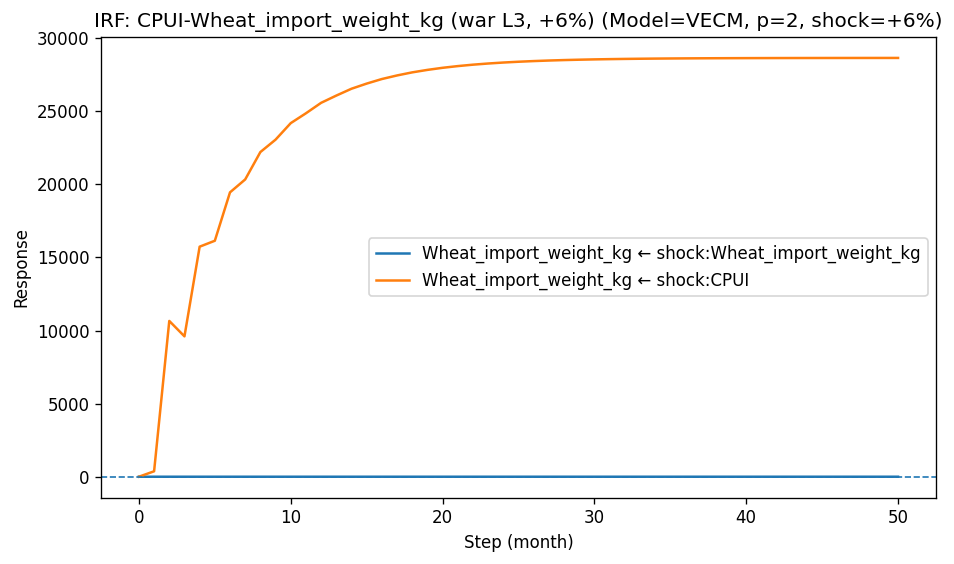

[DISPLAYED] CPUI-Wheat_import_weight_kg (war L3, +6%) (Model=VECM, p=2, shock=+6%, n=125)

=== Scenario: war | Level 3 | Crop: Corn_import_weight_kg ===


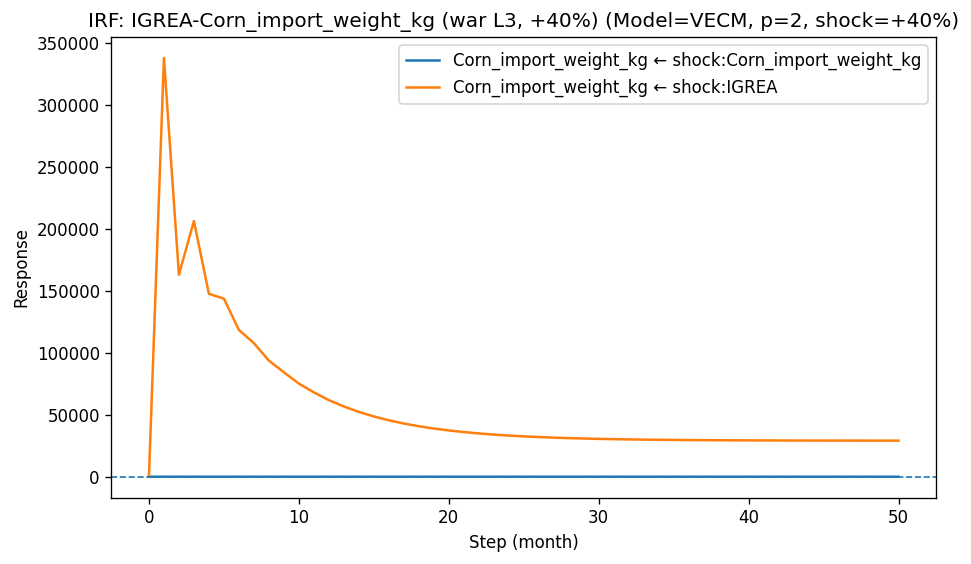

[DISPLAYED] IGREA-Corn_import_weight_kg (war L3, +40%) (Model=VECM, p=2, shock=+40%, n=125)


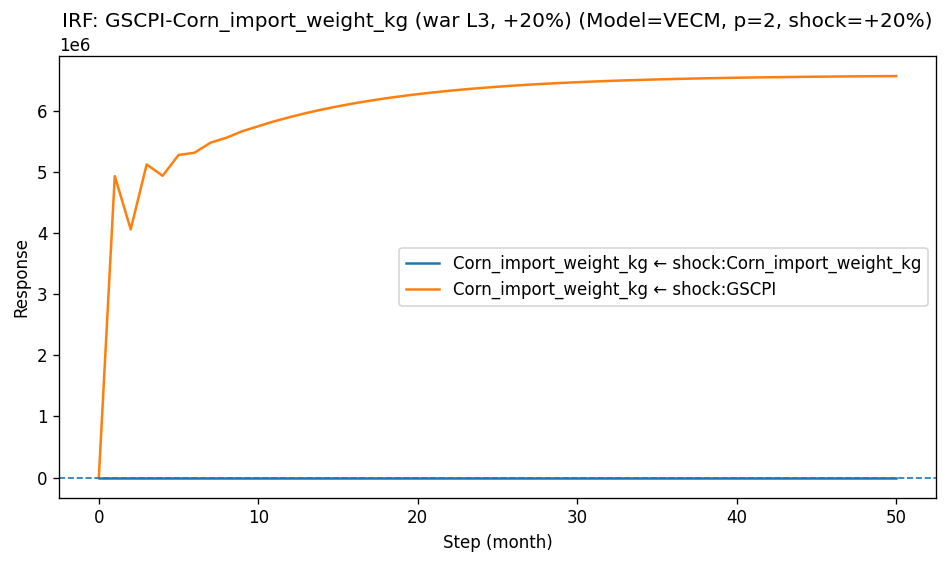

[DISPLAYED] GSCPI-Corn_import_weight_kg (war L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


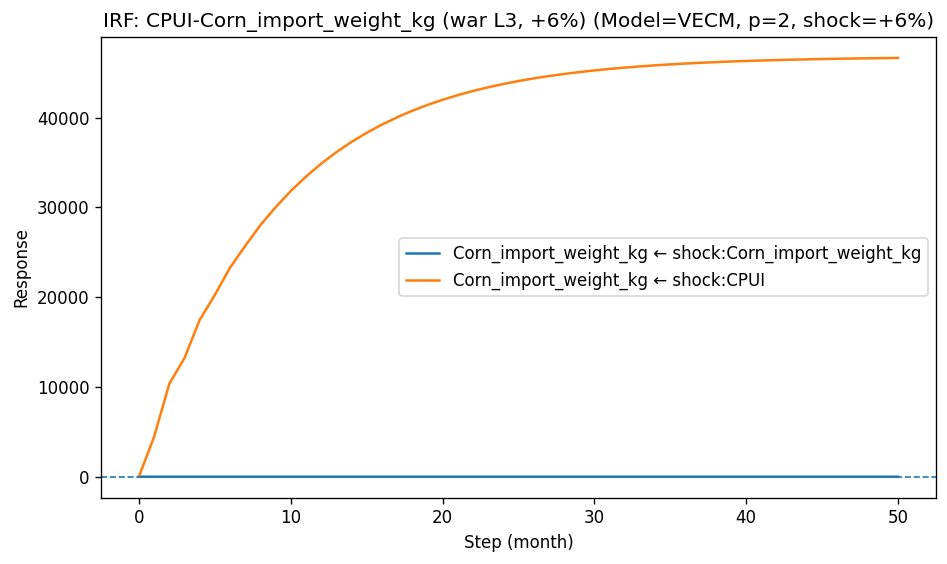

[DISPLAYED] CPUI-Corn_import_weight_kg (war L3, +6%) (Model=VECM, p=2, shock=+6%, n=125)

=== Scenario: war | Level 3 | Crop: Rice_import_weight_kg ===


[DISPLAYED] IGREA-Rice_import_weight_kg (war L3, +40%) (Model=VECM, p=2, shock=+40%, n=125)


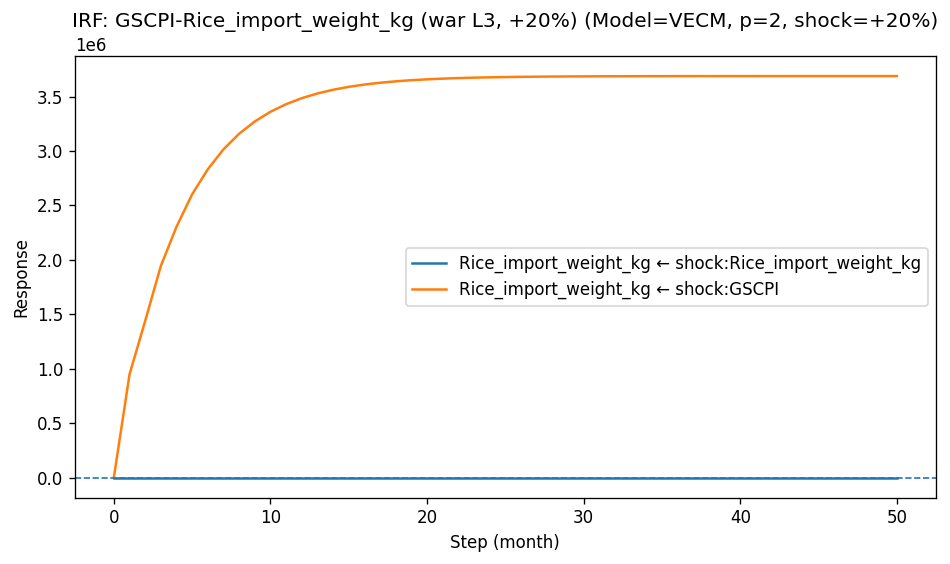

[DISPLAYED] GSCPI-Rice_import_weight_kg (war L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


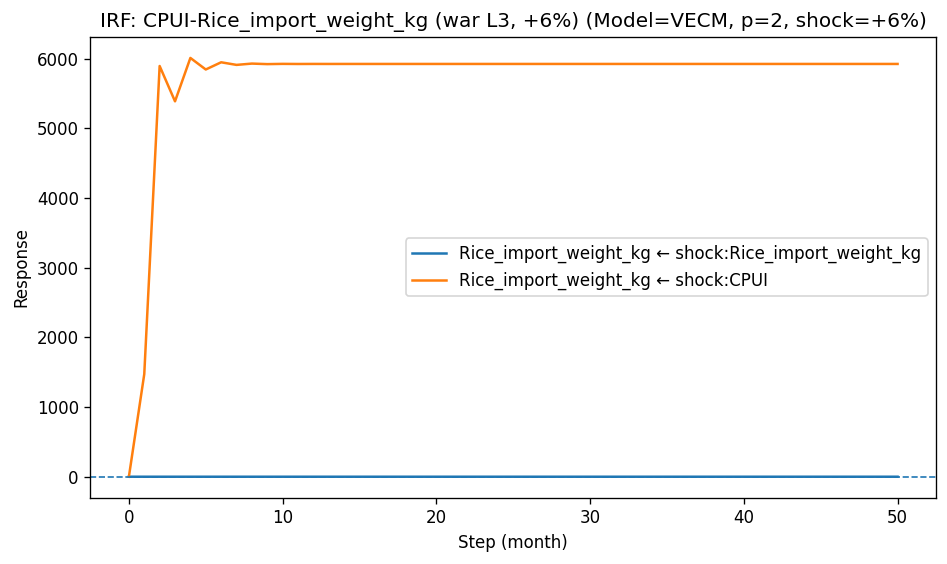

[DISPLAYED] CPUI-Rice_import_weight_kg (war L3, +6%) (Model=VECM, p=2, shock=+6%, n=125)


In [44]:
# 전쟁 시나리오만 실행
run_scenario_group("war")


=== Scenario: pandemic | Level 1 | Crop: Corn_import_weight_kg ===


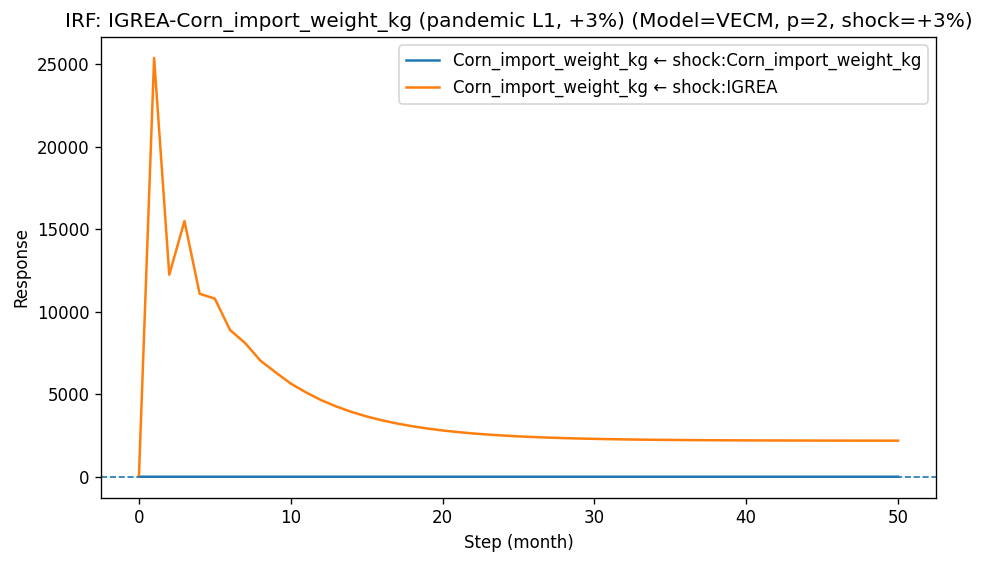

[DISPLAYED] IGREA-Corn_import_weight_kg (pandemic L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)


[DISPLAYED] GSCPI-Corn_import_weight_kg (pandemic L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


[DISPLAYED] CPUI-Corn_import_weight_kg (pandemic L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)

=== Scenario: pandemic | Level 2 | Crop: Corn_import_weight_kg ===


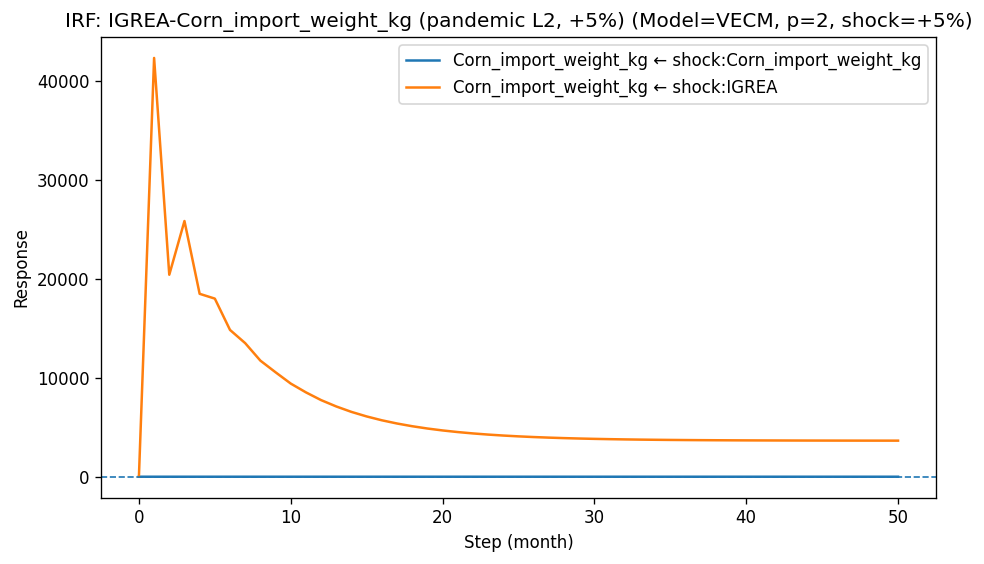

[DISPLAYED] IGREA-Corn_import_weight_kg (pandemic L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)


[DISPLAYED] GSCPI-Corn_import_weight_kg (pandemic L2, +15%) (Model=VECM, p=2, shock=+15%, n=125)


[DISPLAYED] CPUI-Corn_import_weight_kg (pandemic L2, +2%) (Model=VECM, p=2, shock=+2%, n=125)

=== Scenario: pandemic | Level 3 | Crop: Corn_import_weight_kg ===


[DISPLAYED] IGREA-Corn_import_weight_kg (pandemic L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)


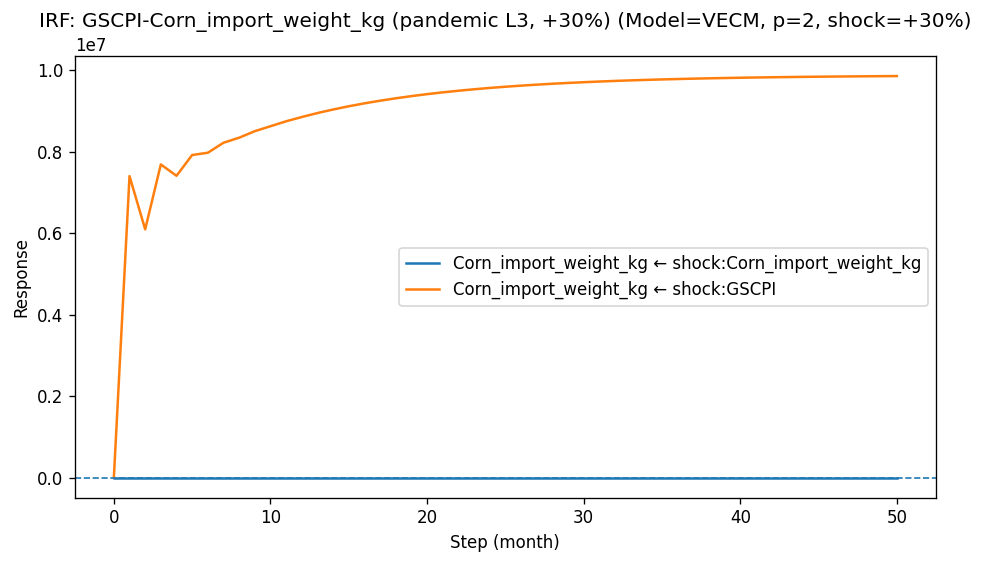

[DISPLAYED] GSCPI-Corn_import_weight_kg (pandemic L3, +30%) (Model=VECM, p=2, shock=+30%, n=125)


[DISPLAYED] CPUI-Corn_import_weight_kg (pandemic L3, +5%) (Model=VECM, p=2, shock=+5%, n=125)


In [45]:
# 팬데믹만 실행 (옥수수만 보고 싶을 때)
run_scenario_group("pandemic", crops=["Corn_import_weight_kg"])


=== Scenario: finance | Level 1 | Crop: Wheat_import_weight_kg ===


[DISPLAYED] IGREA-Wheat_import_weight_kg (finance L1, -10%) (Model=VECM, p=2, shock=-10%, n=125)


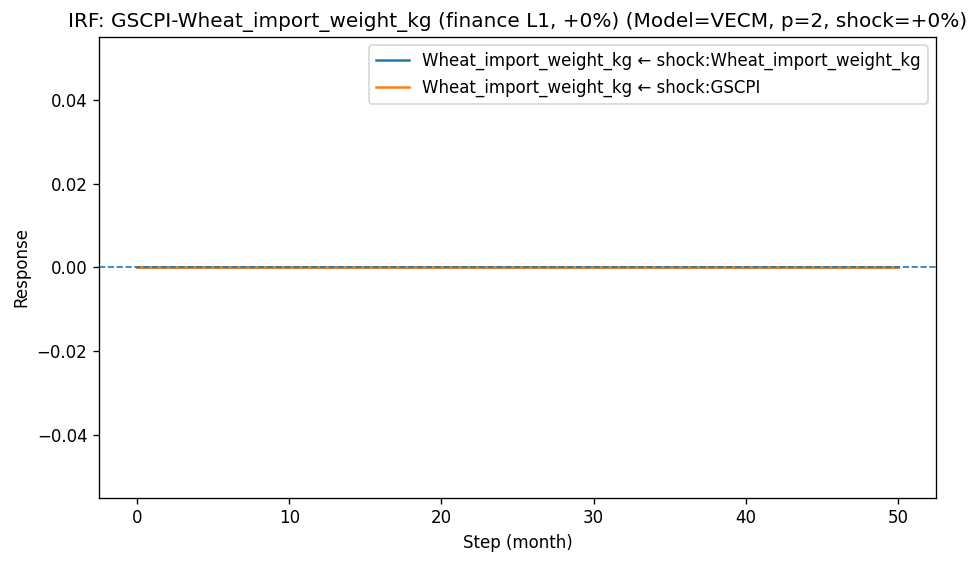

[DISPLAYED] GSCPI-Wheat_import_weight_kg (finance L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


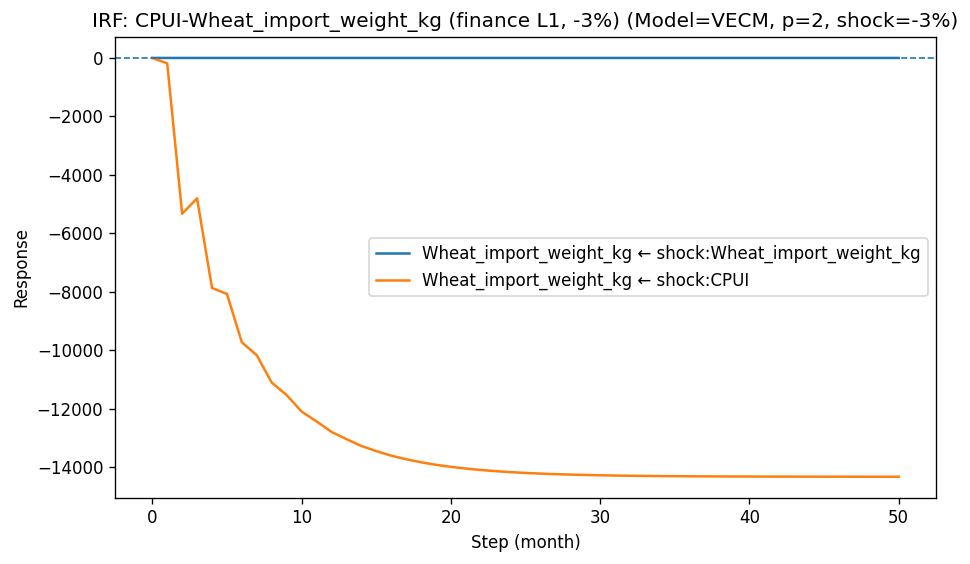

[DISPLAYED] CPUI-Wheat_import_weight_kg (finance L1, -3%) (Model=VECM, p=2, shock=-3%, n=125)

=== Scenario: finance | Level 1 | Crop: Corn_import_weight_kg ===


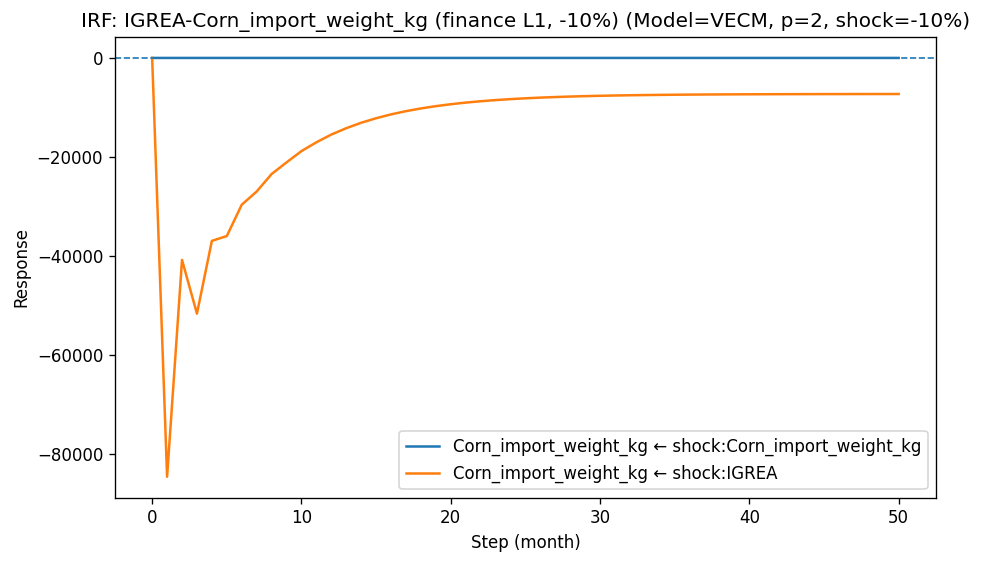

[DISPLAYED] IGREA-Corn_import_weight_kg (finance L1, -10%) (Model=VECM, p=2, shock=-10%, n=125)


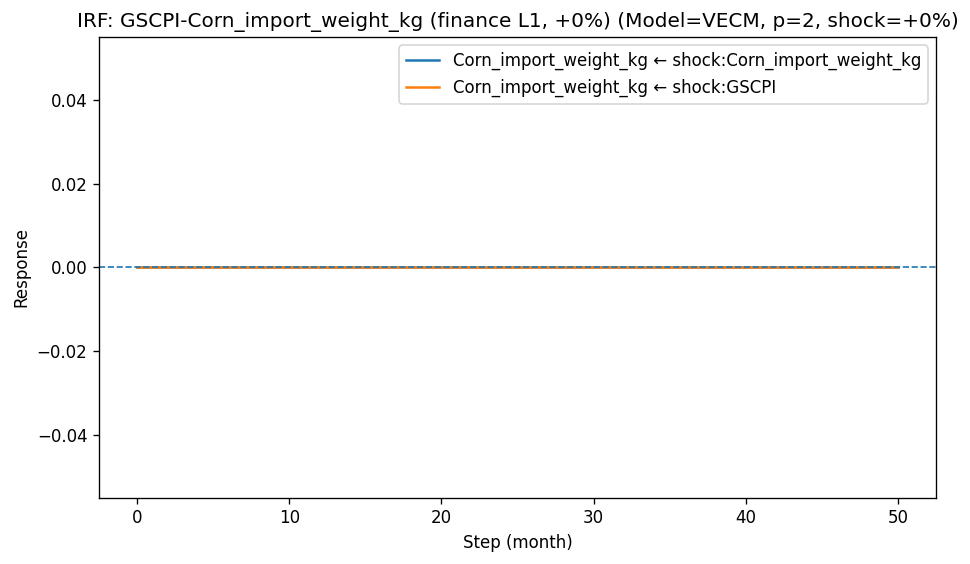

[DISPLAYED] GSCPI-Corn_import_weight_kg (finance L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


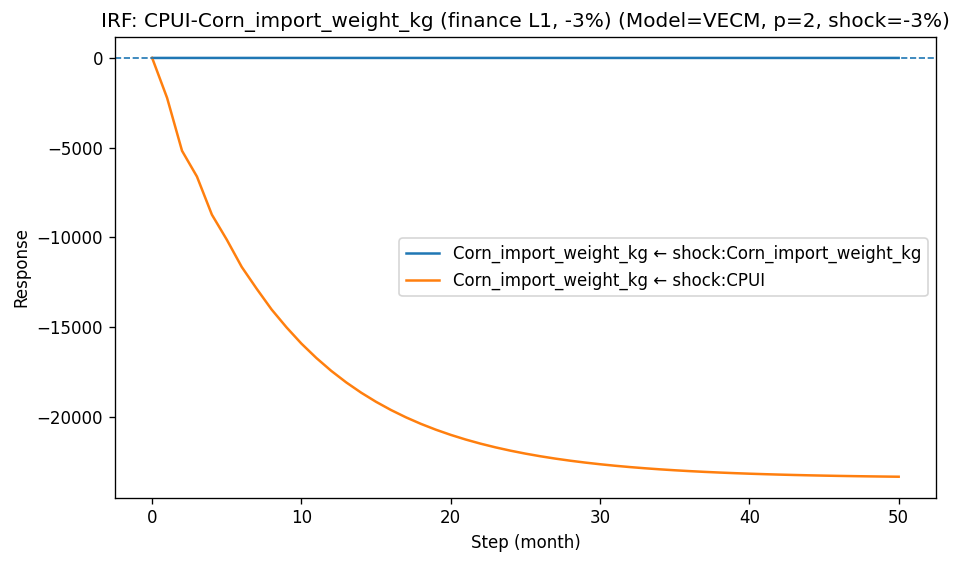

[DISPLAYED] CPUI-Corn_import_weight_kg (finance L1, -3%) (Model=VECM, p=2, shock=-3%, n=125)

=== Scenario: finance | Level 1 | Crop: Rice_import_weight_kg ===


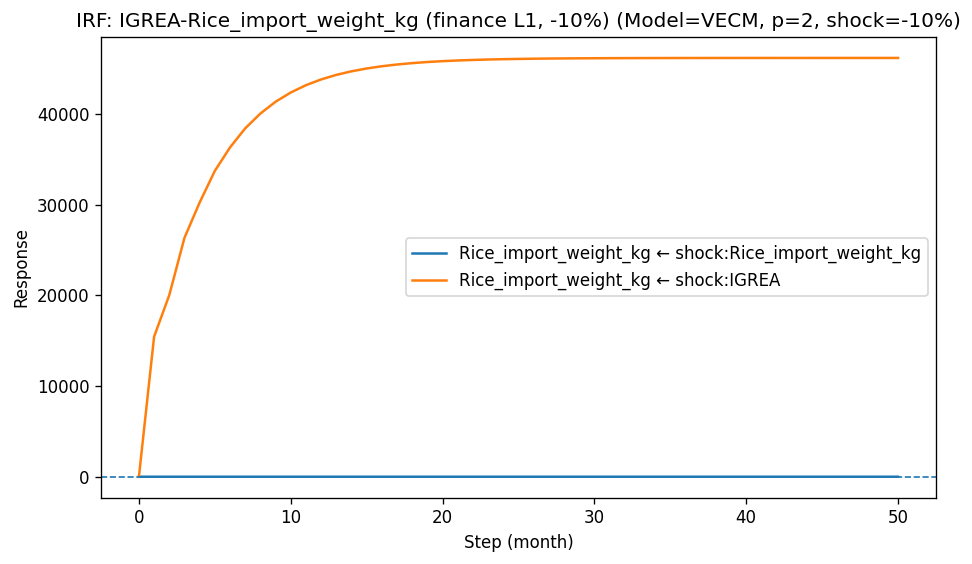

[DISPLAYED] IGREA-Rice_import_weight_kg (finance L1, -10%) (Model=VECM, p=2, shock=-10%, n=125)


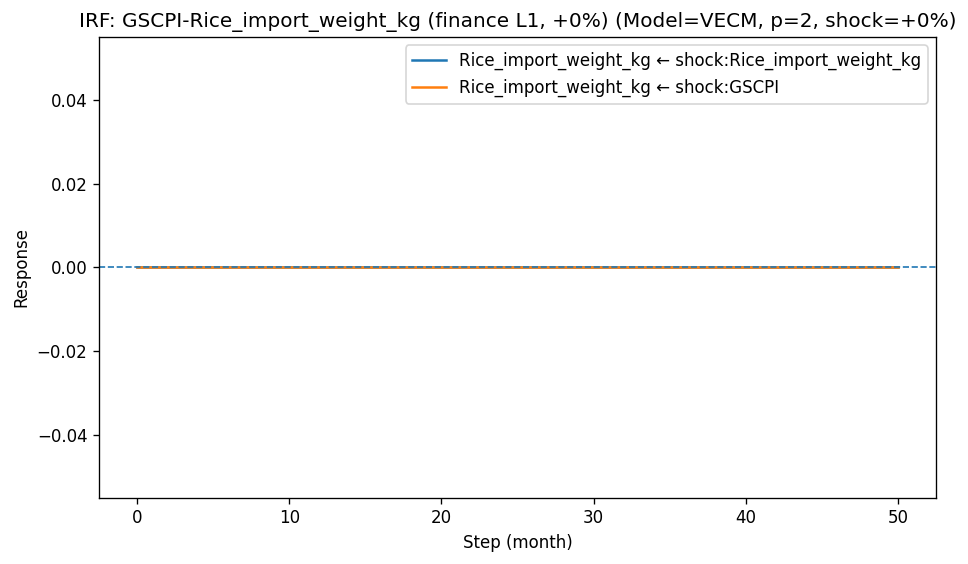

[DISPLAYED] GSCPI-Rice_import_weight_kg (finance L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


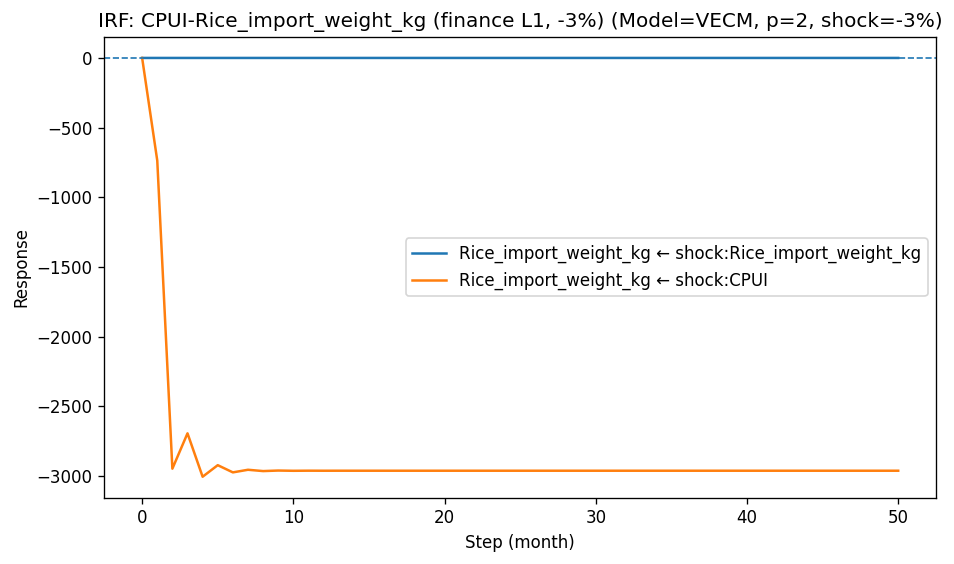

[DISPLAYED] CPUI-Rice_import_weight_kg (finance L1, -3%) (Model=VECM, p=2, shock=-3%, n=125)

=== Scenario: finance | Level 2 | Crop: Wheat_import_weight_kg ===


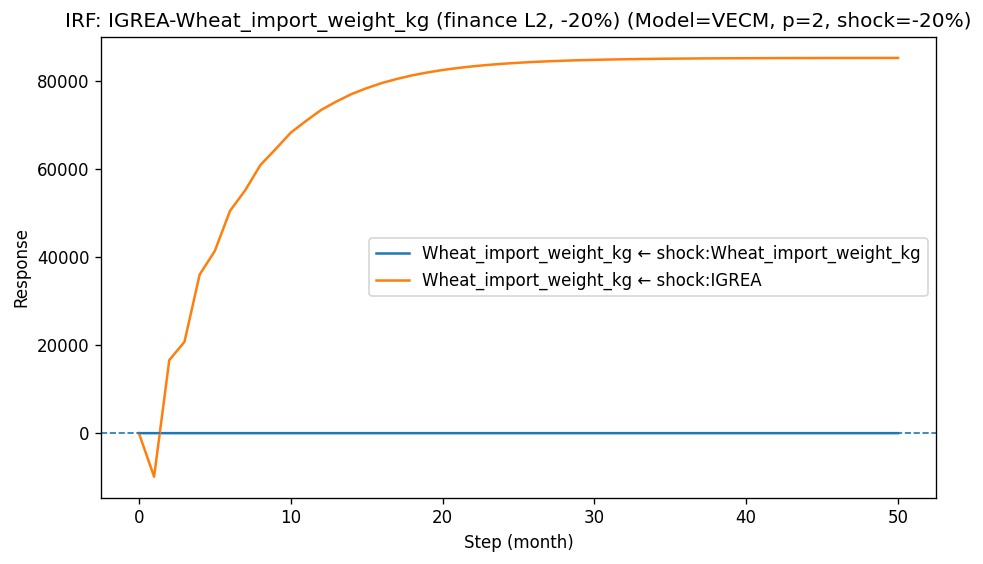

[DISPLAYED] IGREA-Wheat_import_weight_kg (finance L2, -20%) (Model=VECM, p=2, shock=-20%, n=125)


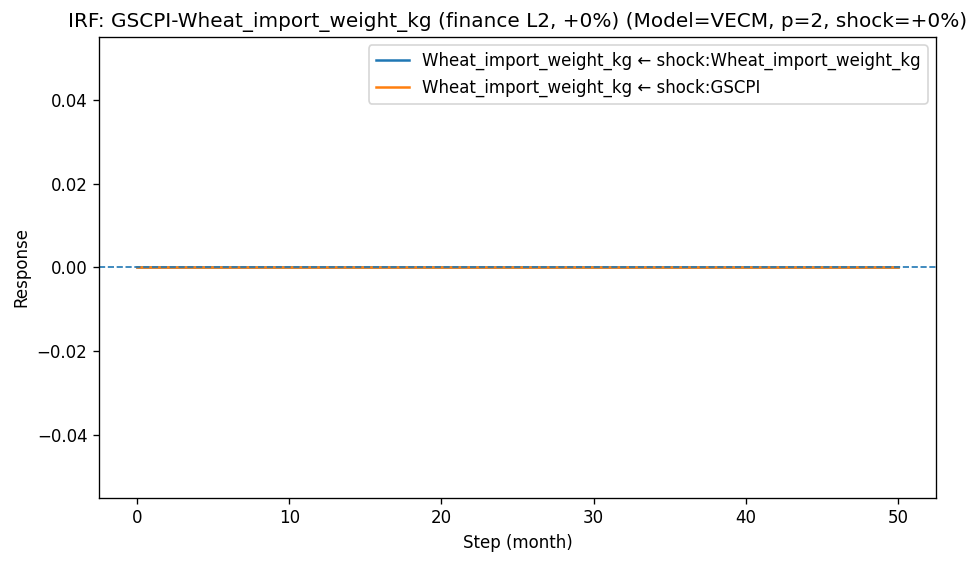

[DISPLAYED] GSCPI-Wheat_import_weight_kg (finance L2, +0%) (Model=VECM, p=2, shock=+0%, n=125)


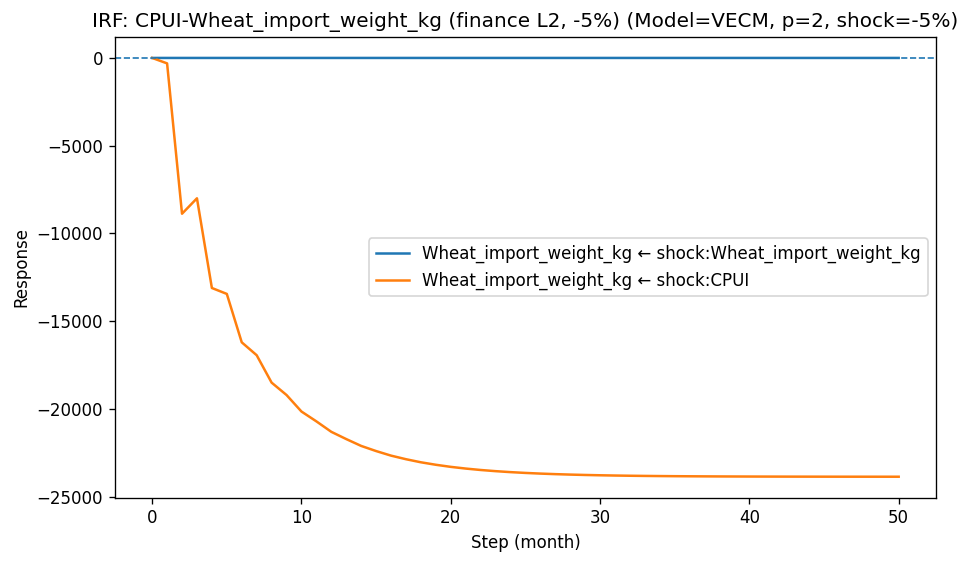

[DISPLAYED] CPUI-Wheat_import_weight_kg (finance L2, -5%) (Model=VECM, p=2, shock=-5%, n=125)

=== Scenario: finance | Level 2 | Crop: Corn_import_weight_kg ===


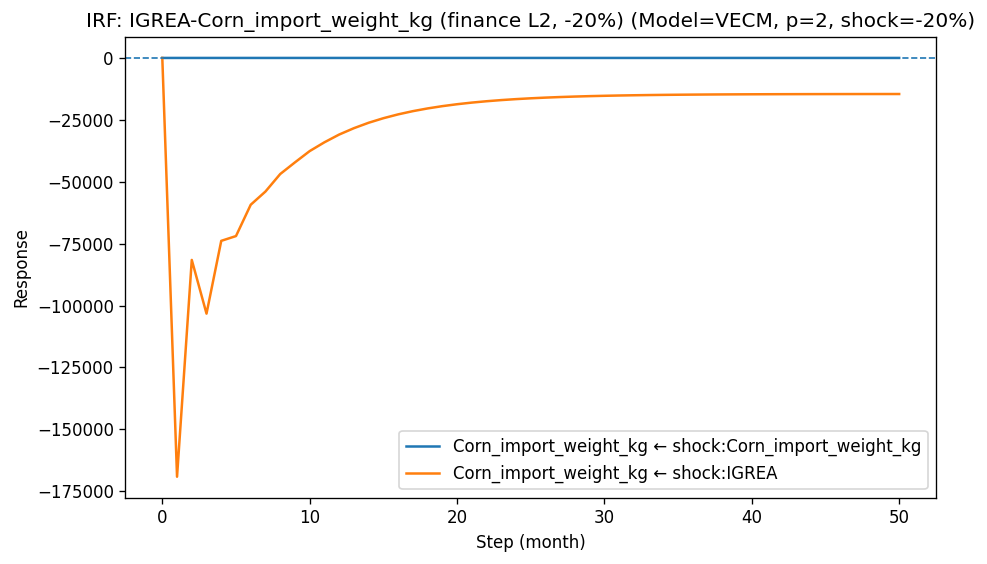

[DISPLAYED] IGREA-Corn_import_weight_kg (finance L2, -20%) (Model=VECM, p=2, shock=-20%, n=125)


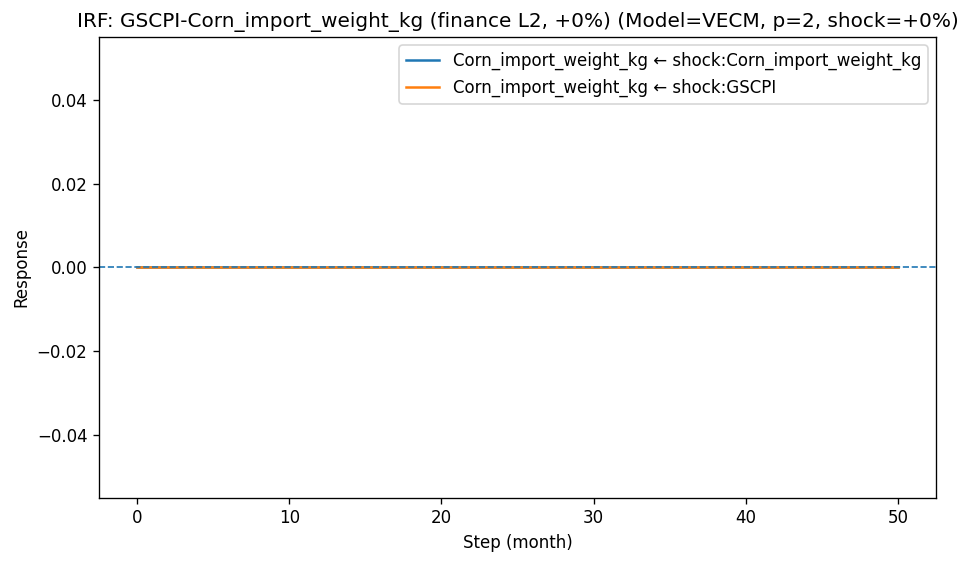

[DISPLAYED] GSCPI-Corn_import_weight_kg (finance L2, +0%) (Model=VECM, p=2, shock=+0%, n=125)


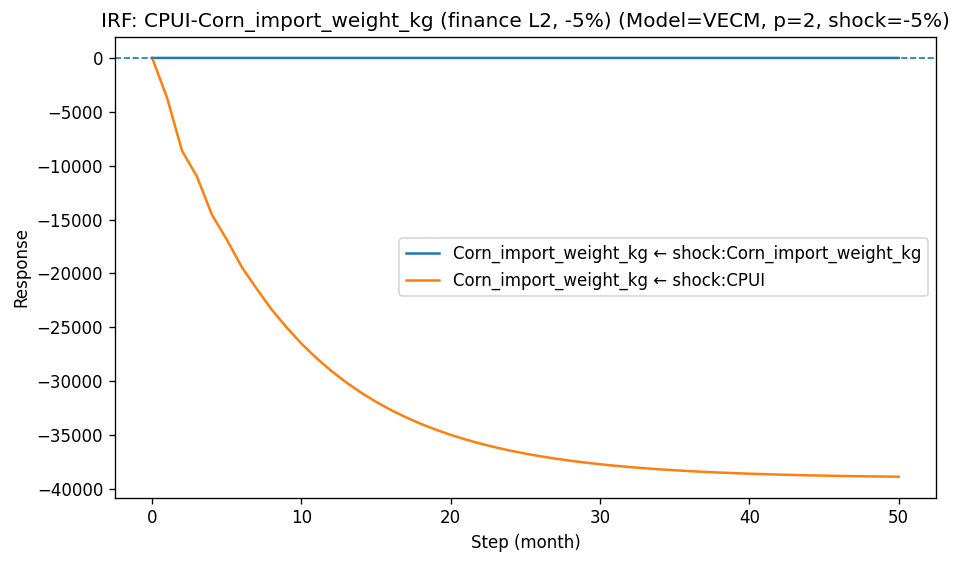

[DISPLAYED] CPUI-Corn_import_weight_kg (finance L2, -5%) (Model=VECM, p=2, shock=-5%, n=125)

=== Scenario: finance | Level 2 | Crop: Rice_import_weight_kg ===


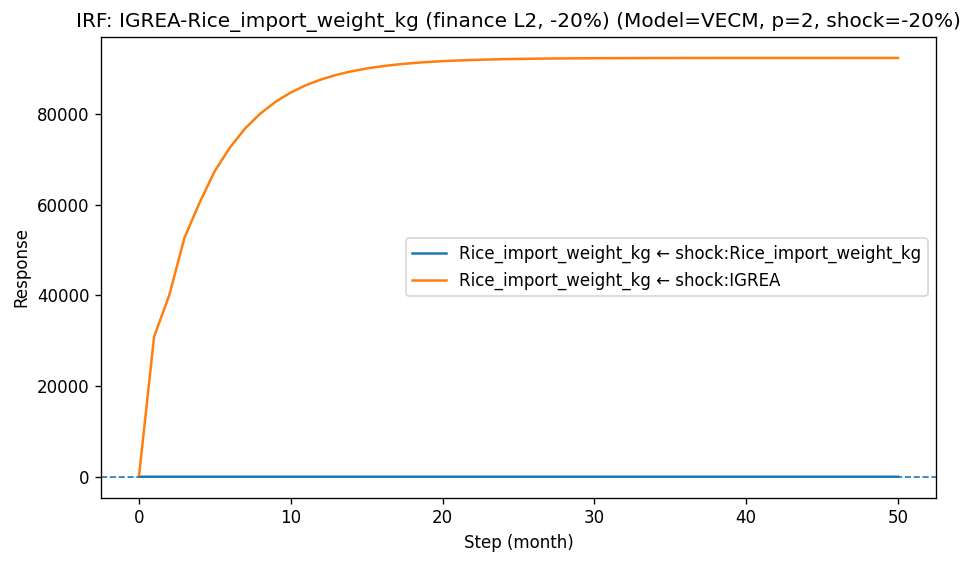

[DISPLAYED] IGREA-Rice_import_weight_kg (finance L2, -20%) (Model=VECM, p=2, shock=-20%, n=125)


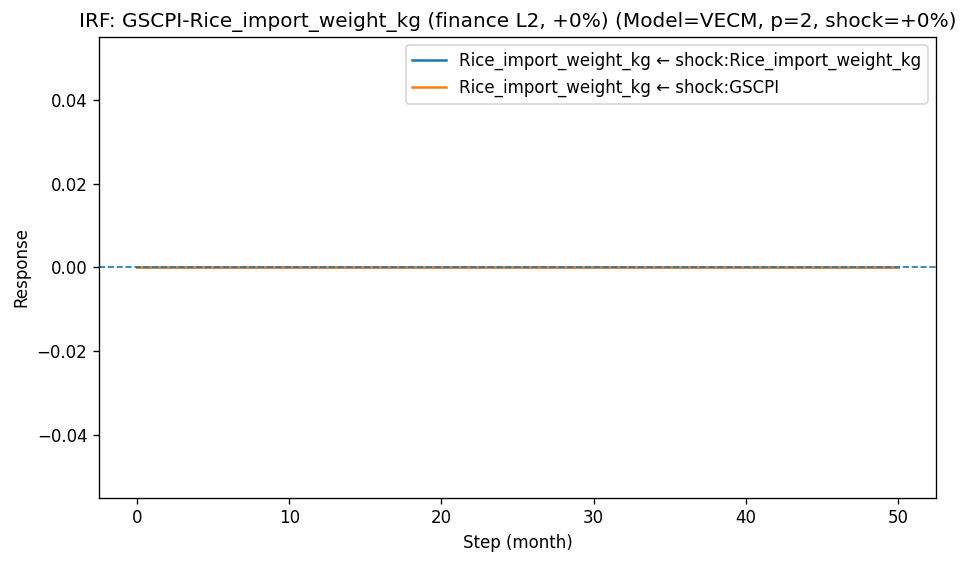

[DISPLAYED] GSCPI-Rice_import_weight_kg (finance L2, +0%) (Model=VECM, p=2, shock=+0%, n=125)


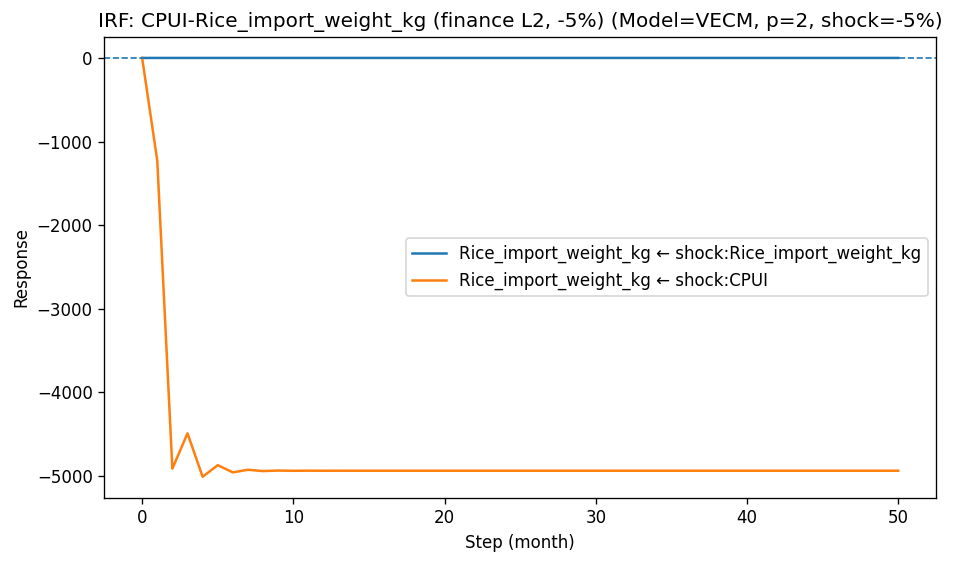

[DISPLAYED] CPUI-Rice_import_weight_kg (finance L2, -5%) (Model=VECM, p=2, shock=-5%, n=125)

=== Scenario: finance | Level 3 | Crop: Wheat_import_weight_kg ===


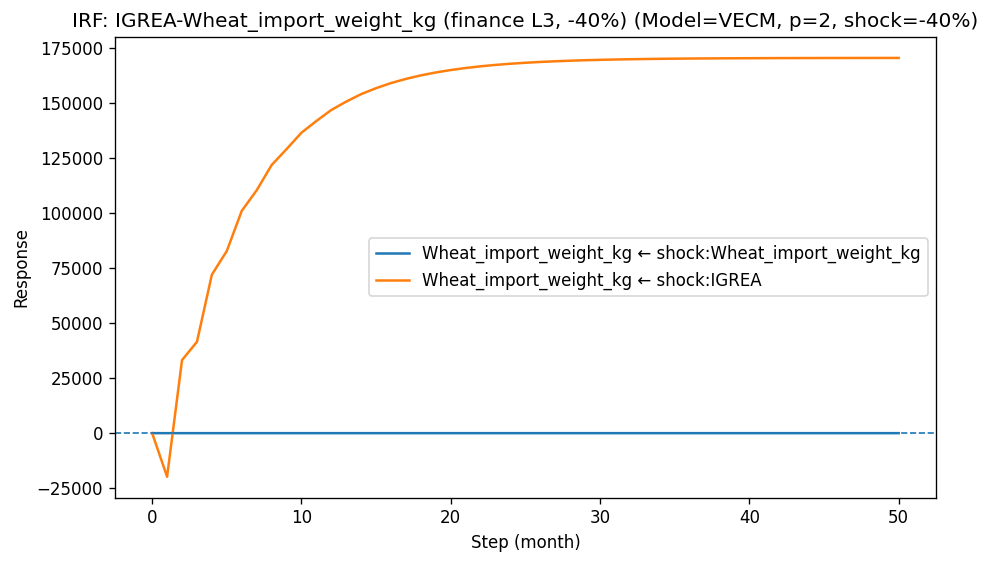

[DISPLAYED] IGREA-Wheat_import_weight_kg (finance L3, -40%) (Model=VECM, p=2, shock=-40%, n=125)


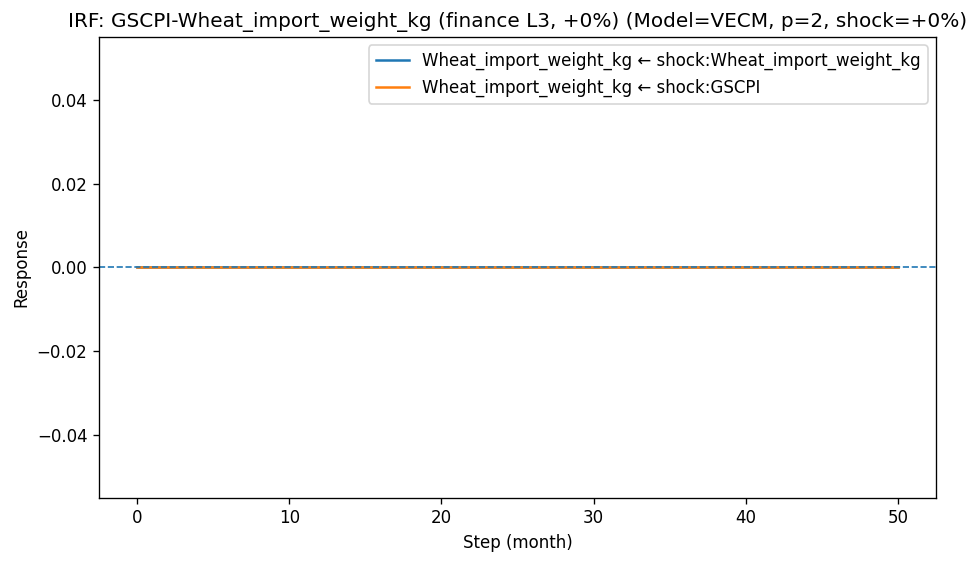

[DISPLAYED] GSCPI-Wheat_import_weight_kg (finance L3, +0%) (Model=VECM, p=2, shock=+0%, n=125)


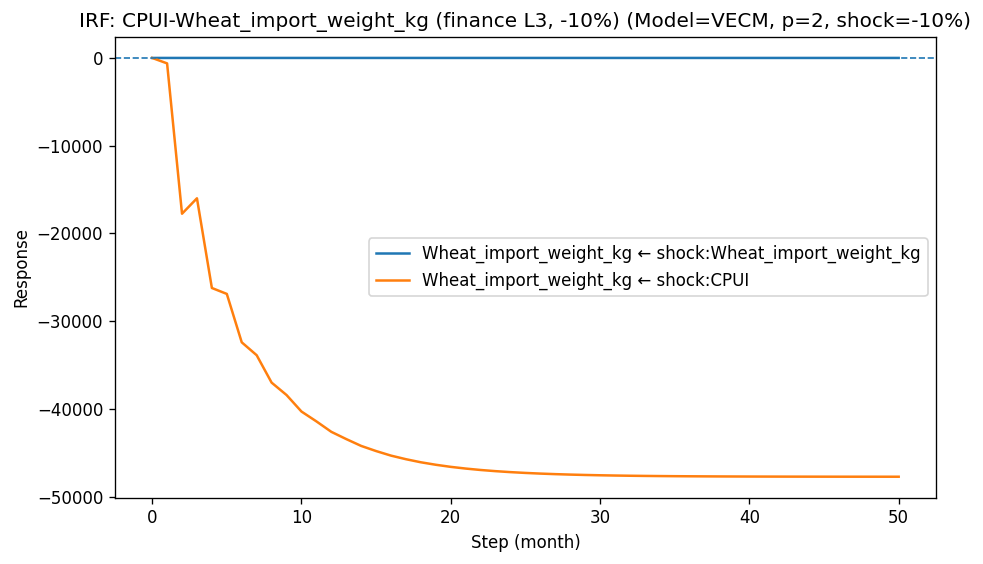

[DISPLAYED] CPUI-Wheat_import_weight_kg (finance L3, -10%) (Model=VECM, p=2, shock=-10%, n=125)

=== Scenario: finance | Level 3 | Crop: Corn_import_weight_kg ===


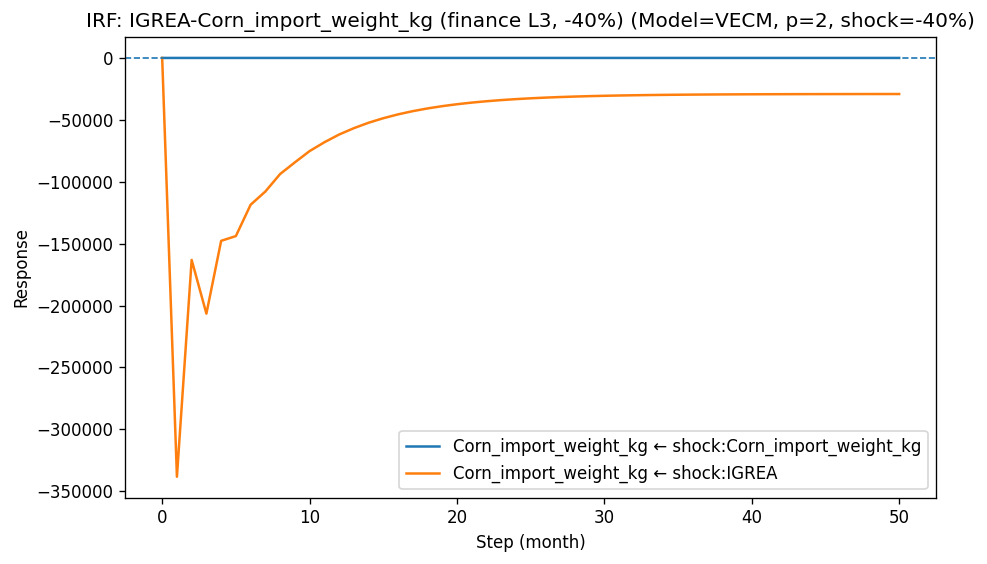

[DISPLAYED] IGREA-Corn_import_weight_kg (finance L3, -40%) (Model=VECM, p=2, shock=-40%, n=125)


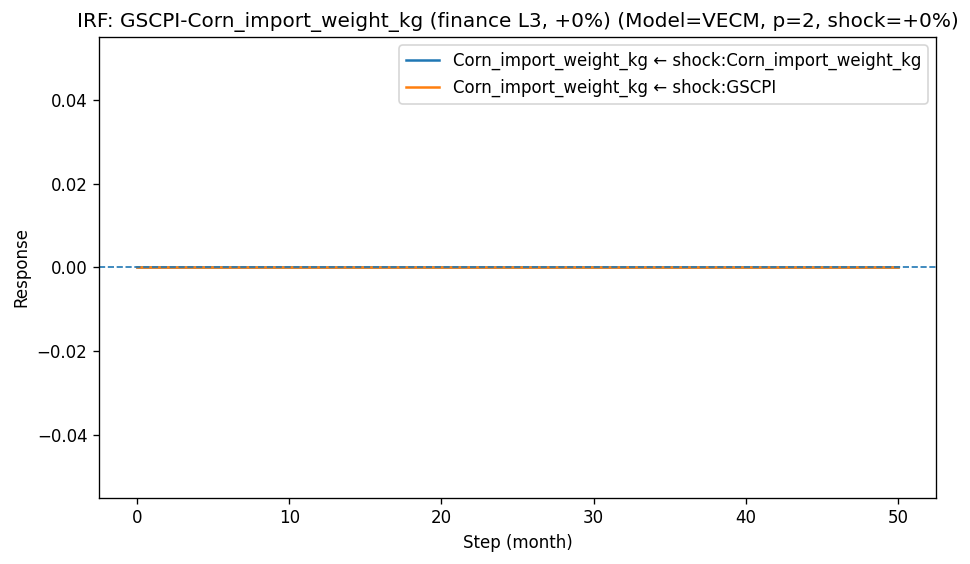

[DISPLAYED] GSCPI-Corn_import_weight_kg (finance L3, +0%) (Model=VECM, p=2, shock=+0%, n=125)


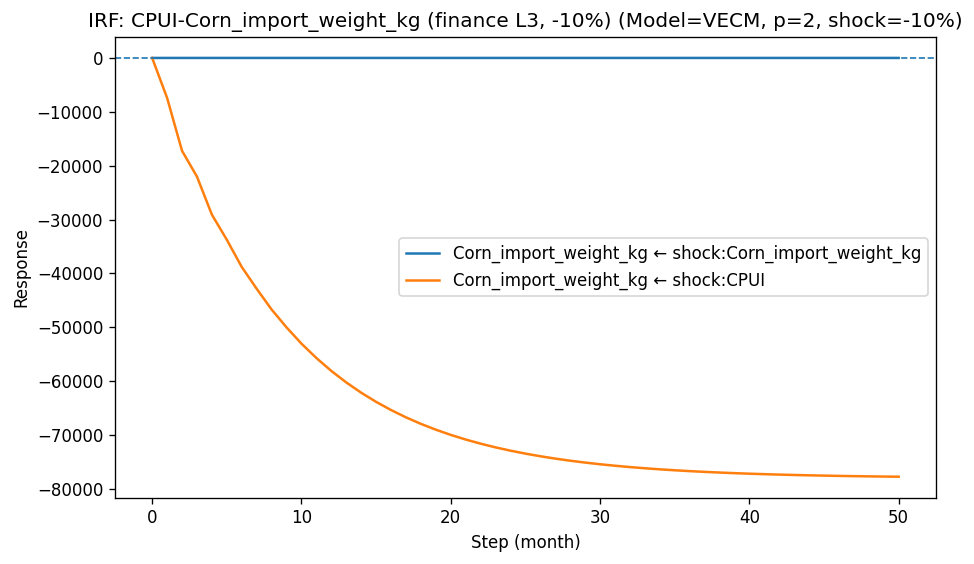

[DISPLAYED] CPUI-Corn_import_weight_kg (finance L3, -10%) (Model=VECM, p=2, shock=-10%, n=125)

=== Scenario: finance | Level 3 | Crop: Rice_import_weight_kg ===


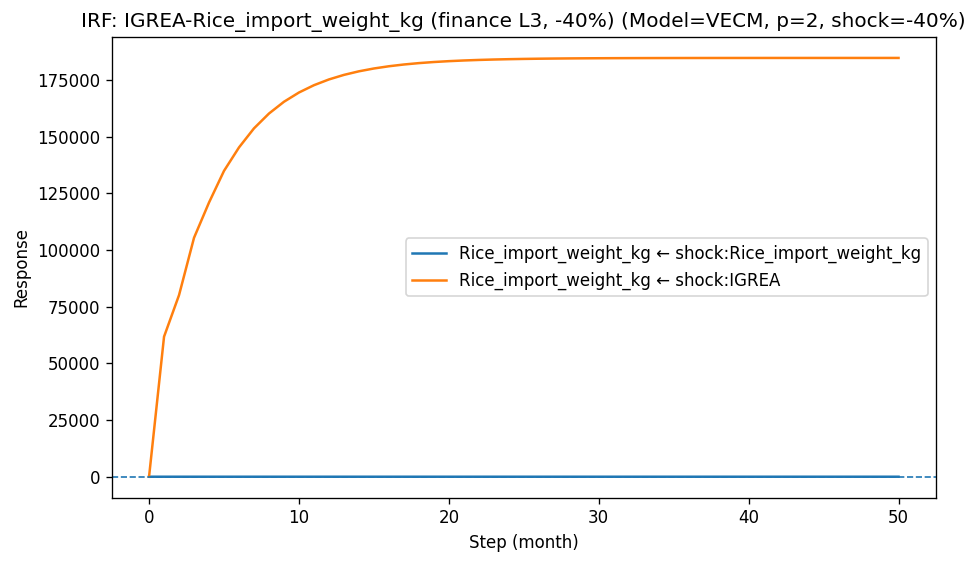

[DISPLAYED] IGREA-Rice_import_weight_kg (finance L3, -40%) (Model=VECM, p=2, shock=-40%, n=125)


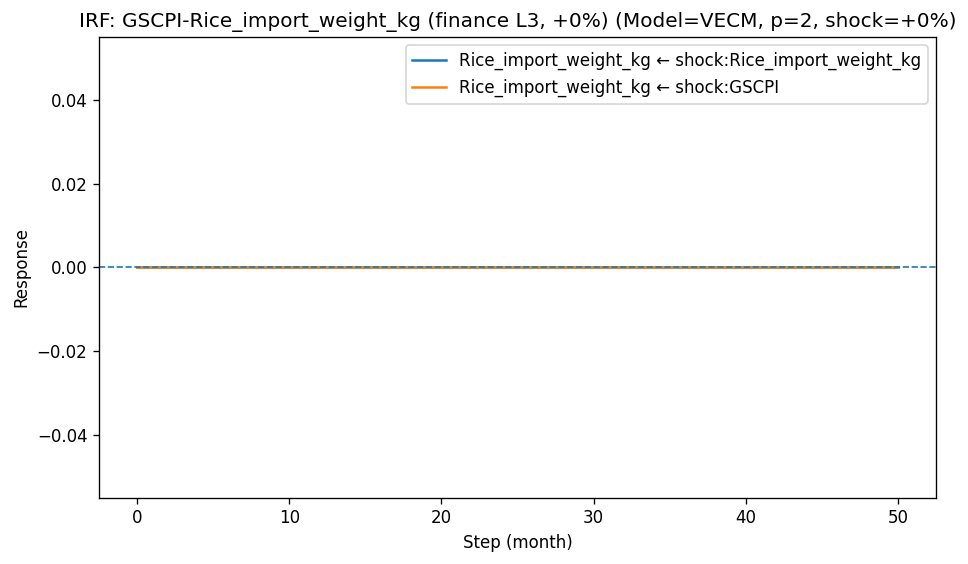

[DISPLAYED] GSCPI-Rice_import_weight_kg (finance L3, +0%) (Model=VECM, p=2, shock=+0%, n=125)


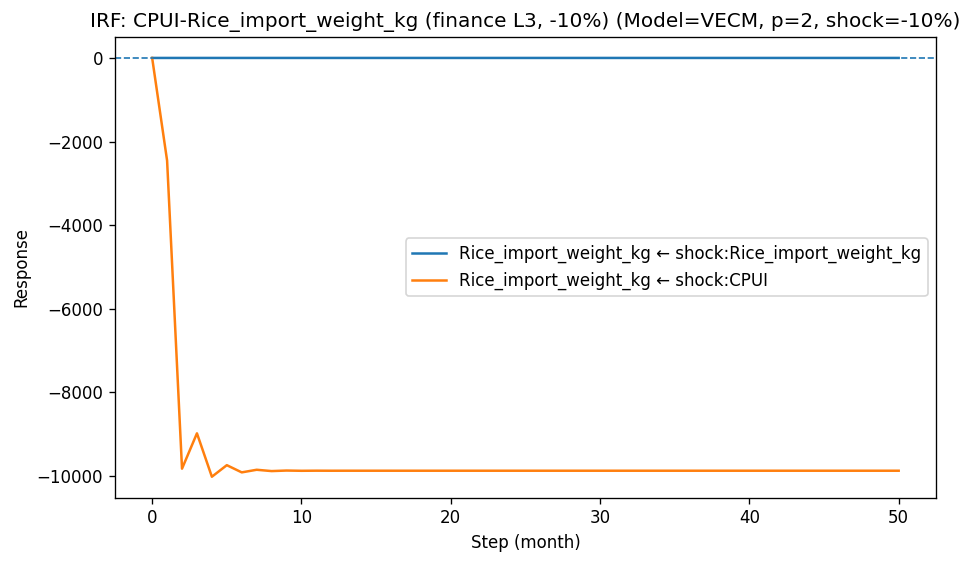

[DISPLAYED] CPUI-Rice_import_weight_kg (finance L3, -10%) (Model=VECM, p=2, shock=-10%, n=125)


In [46]:
# 금융위기 전체 실행
run_scenario_group("finance")


=== Scenario: climate | Level 1 | Crop: Wheat_import_weight_kg ===


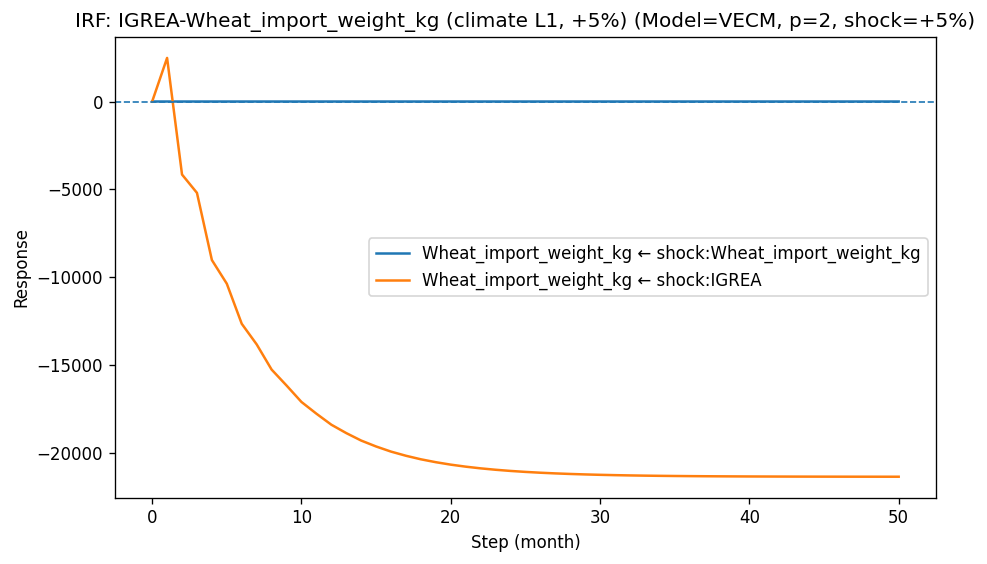

[DISPLAYED] IGREA-Wheat_import_weight_kg (climate L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


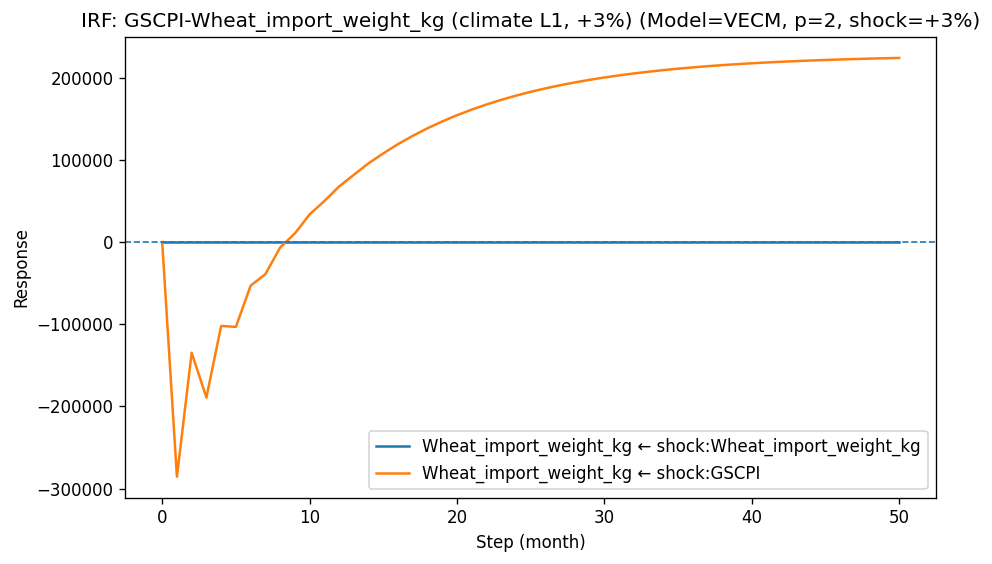

[DISPLAYED] GSCPI-Wheat_import_weight_kg (climate L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)


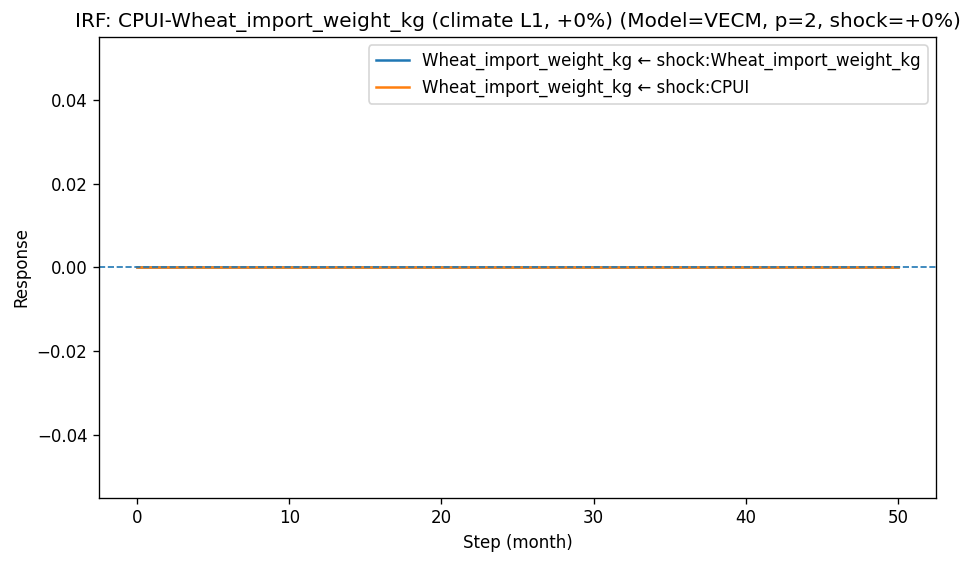

[DISPLAYED] CPUI-Wheat_import_weight_kg (climate L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)

=== Scenario: climate | Level 1 | Crop: Corn_import_weight_kg ===


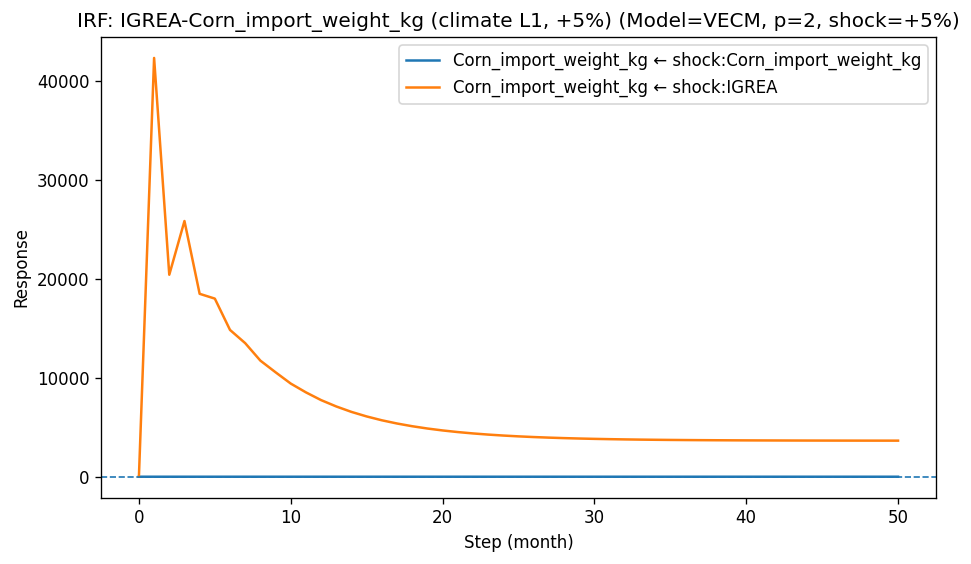

[DISPLAYED] IGREA-Corn_import_weight_kg (climate L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


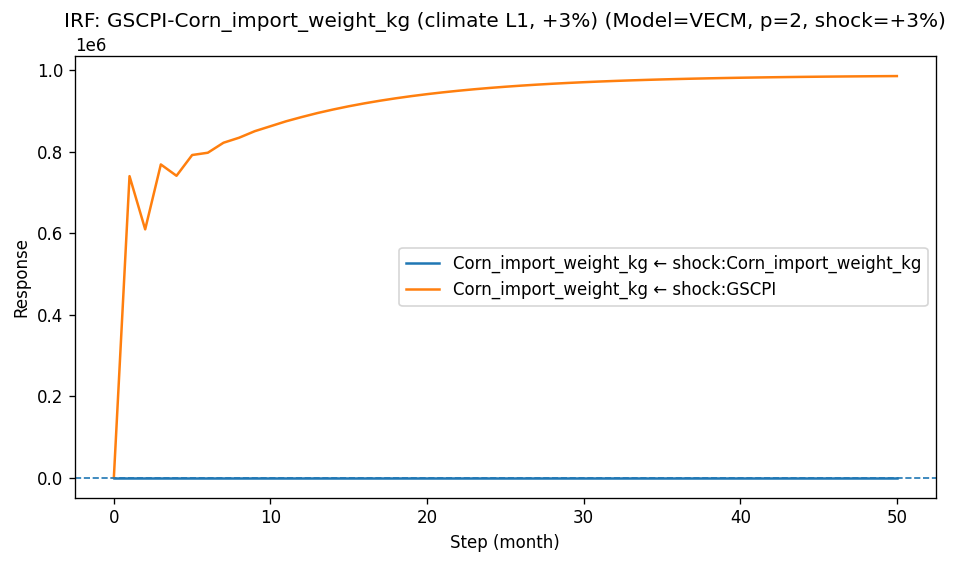

[DISPLAYED] GSCPI-Corn_import_weight_kg (climate L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)


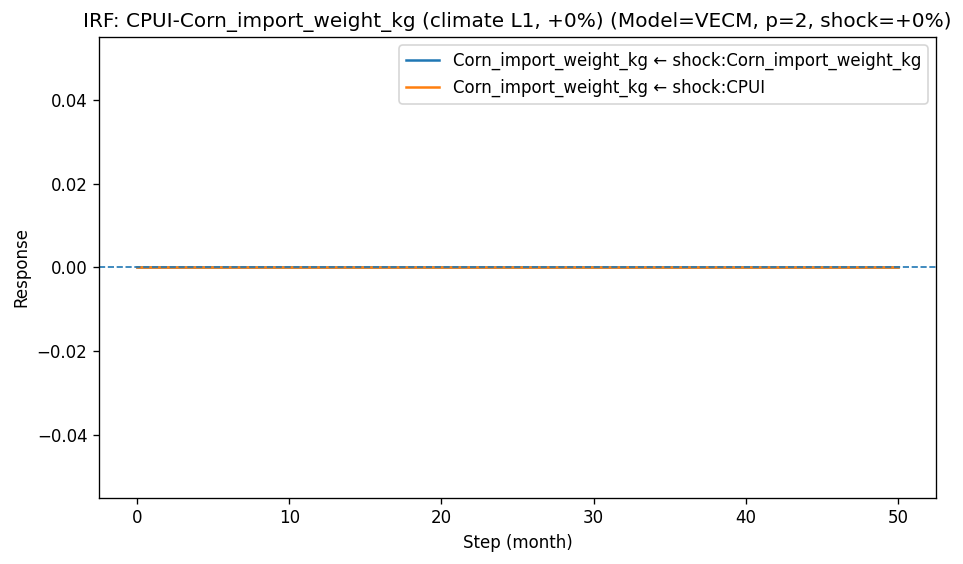

[DISPLAYED] CPUI-Corn_import_weight_kg (climate L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)

=== Scenario: climate | Level 1 | Crop: Rice_import_weight_kg ===


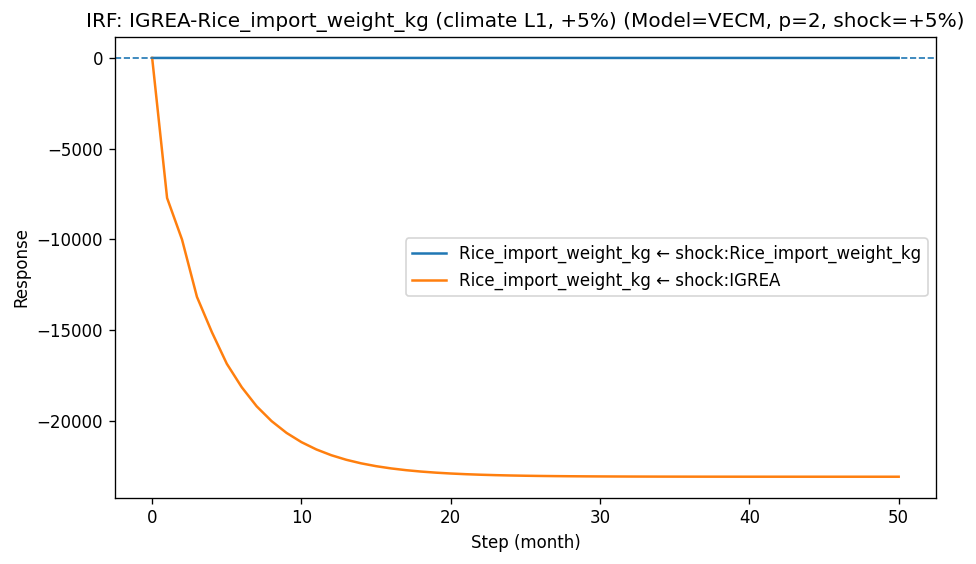

[DISPLAYED] IGREA-Rice_import_weight_kg (climate L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


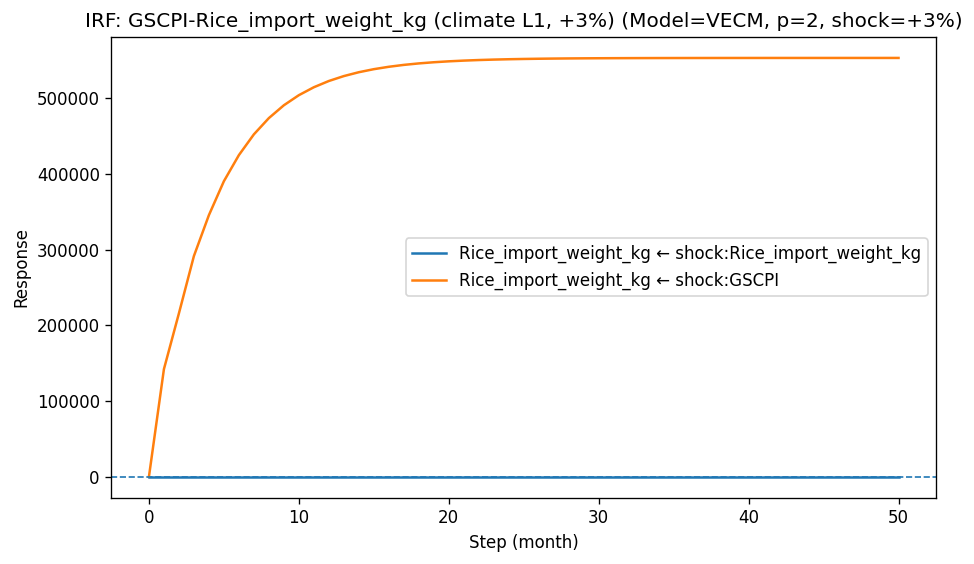

[DISPLAYED] GSCPI-Rice_import_weight_kg (climate L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)


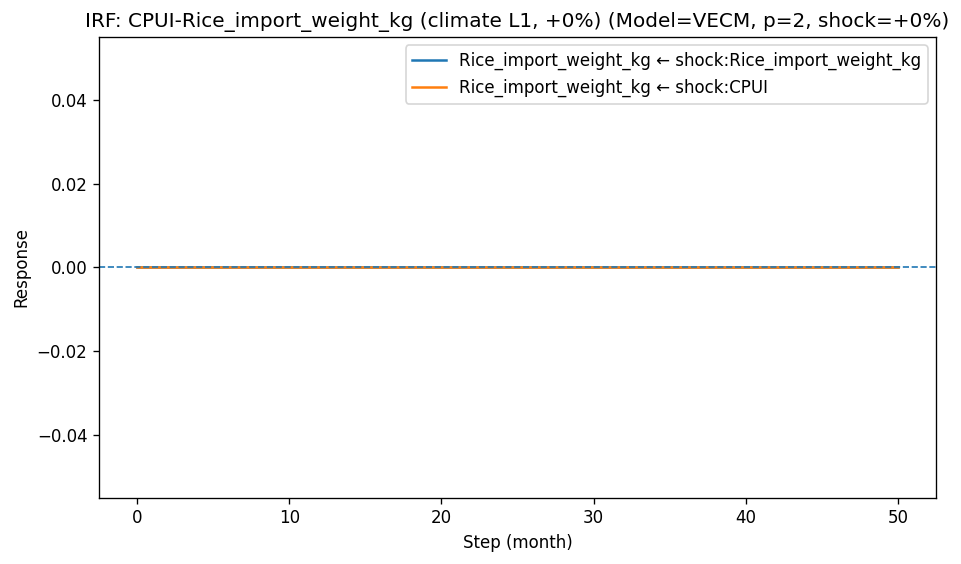

[DISPLAYED] CPUI-Rice_import_weight_kg (climate L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)

=== Scenario: climate | Level 2 | Crop: Wheat_import_weight_kg ===


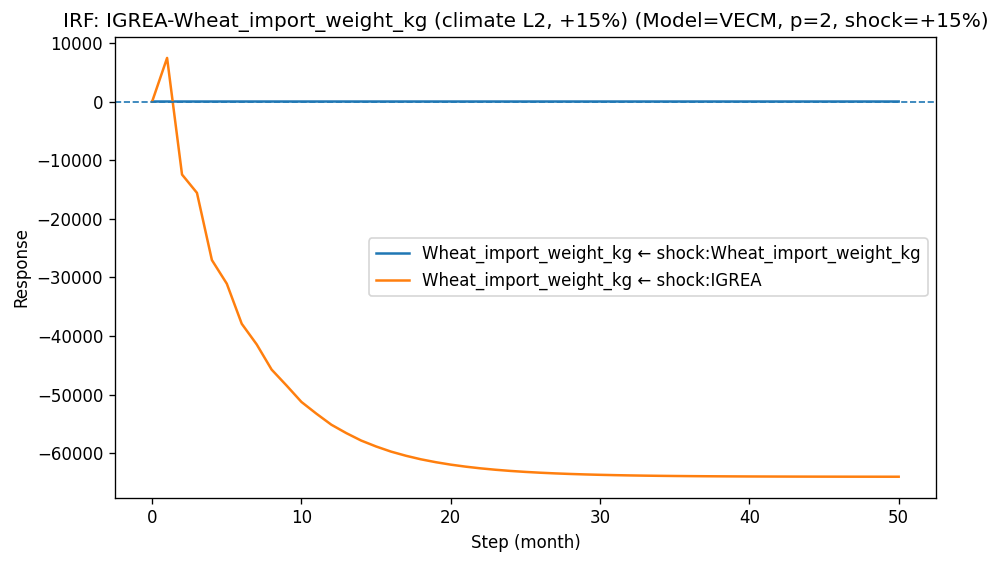

[DISPLAYED] IGREA-Wheat_import_weight_kg (climate L2, +15%) (Model=VECM, p=2, shock=+15%, n=125)


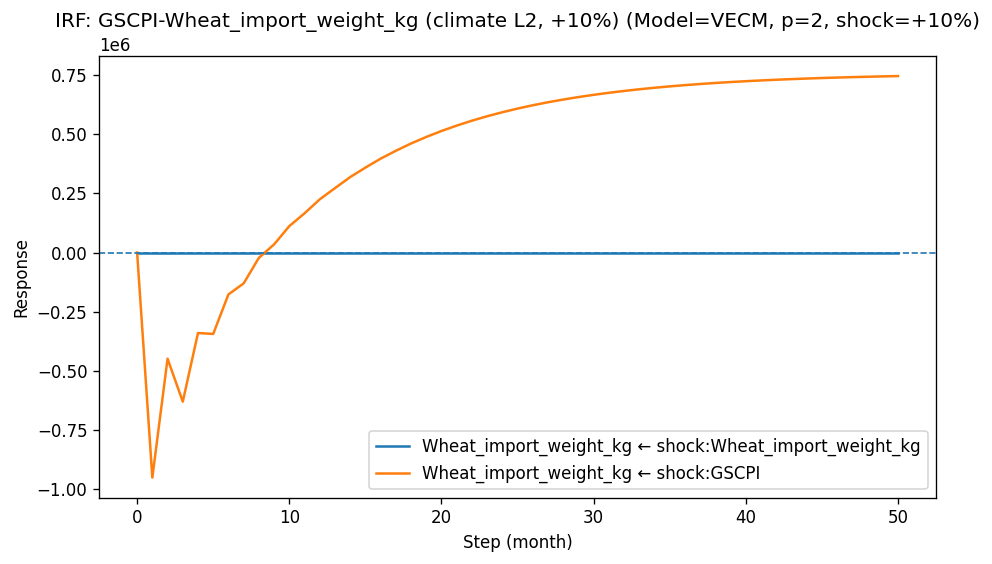

[DISPLAYED] GSCPI-Wheat_import_weight_kg (climate L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


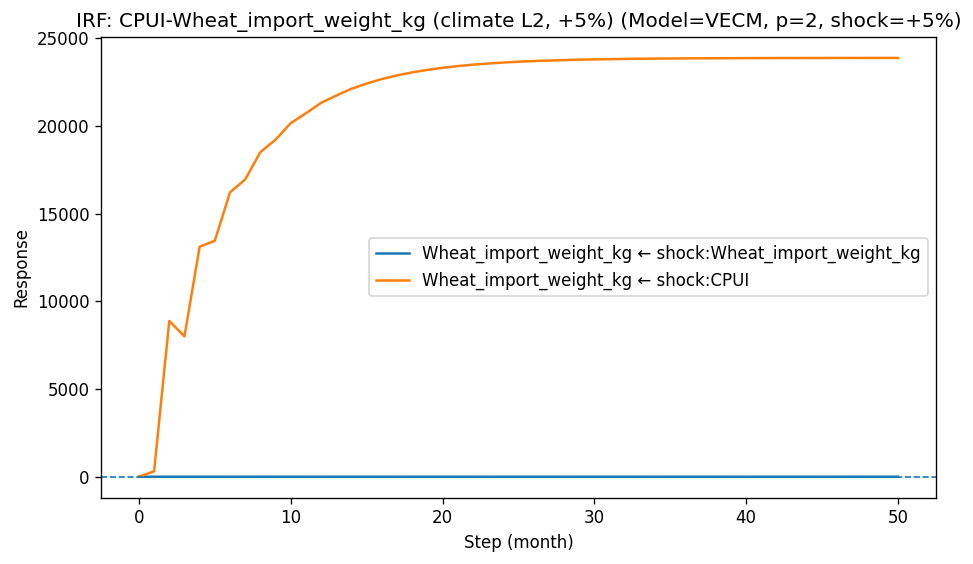

[DISPLAYED] CPUI-Wheat_import_weight_kg (climate L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: climate | Level 2 | Crop: Corn_import_weight_kg ===


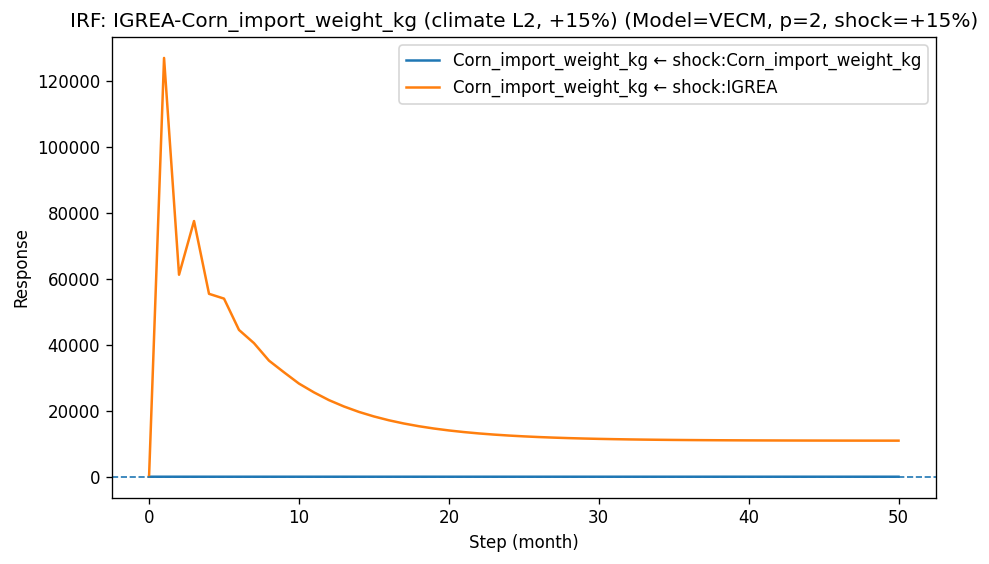

[DISPLAYED] IGREA-Corn_import_weight_kg (climate L2, +15%) (Model=VECM, p=2, shock=+15%, n=125)


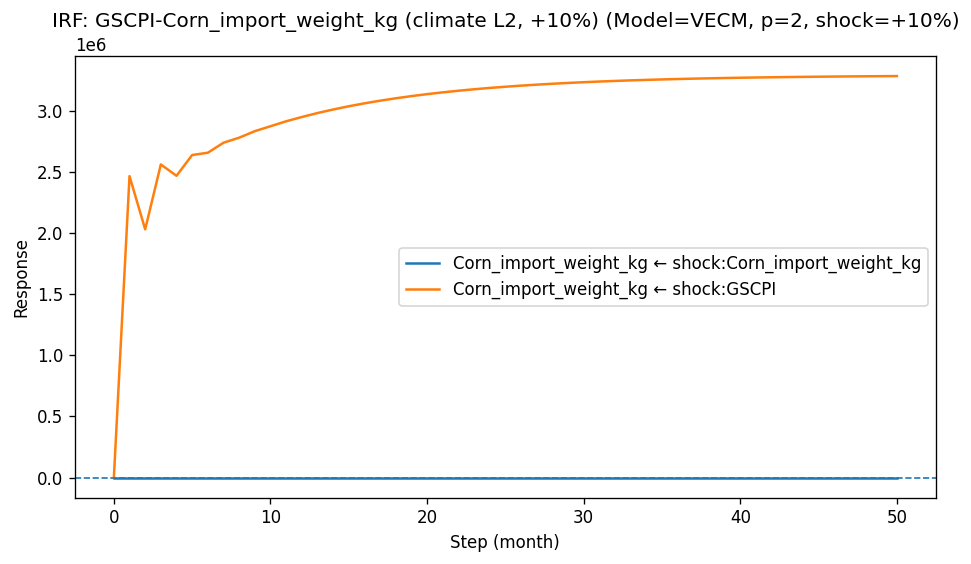

[DISPLAYED] GSCPI-Corn_import_weight_kg (climate L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


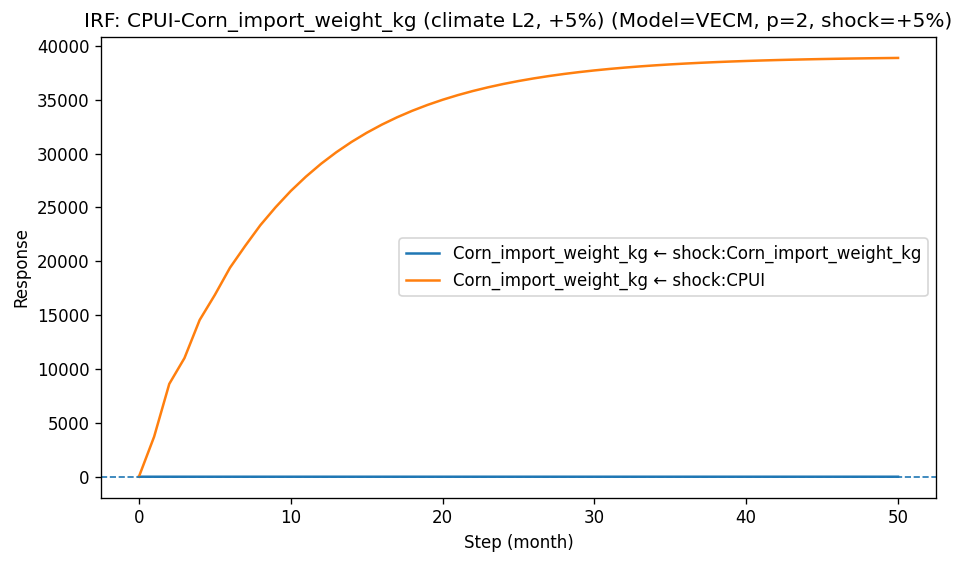

[DISPLAYED] CPUI-Corn_import_weight_kg (climate L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: climate | Level 2 | Crop: Rice_import_weight_kg ===


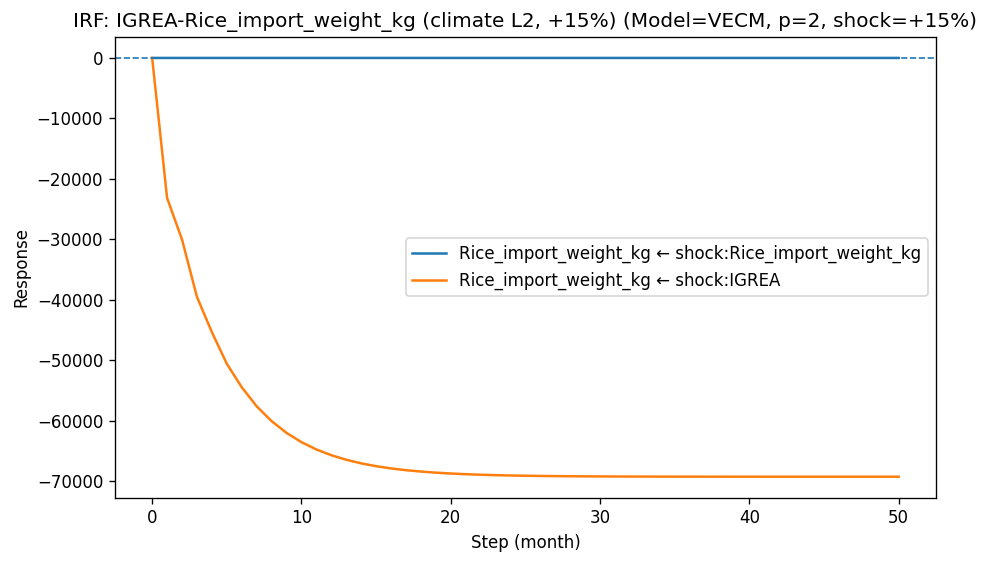

[DISPLAYED] IGREA-Rice_import_weight_kg (climate L2, +15%) (Model=VECM, p=2, shock=+15%, n=125)


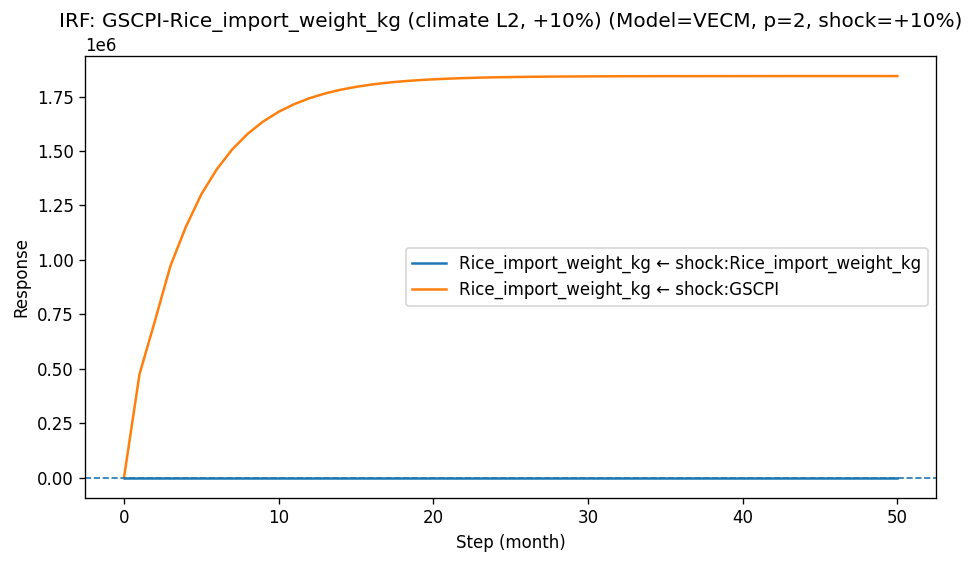

[DISPLAYED] GSCPI-Rice_import_weight_kg (climate L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


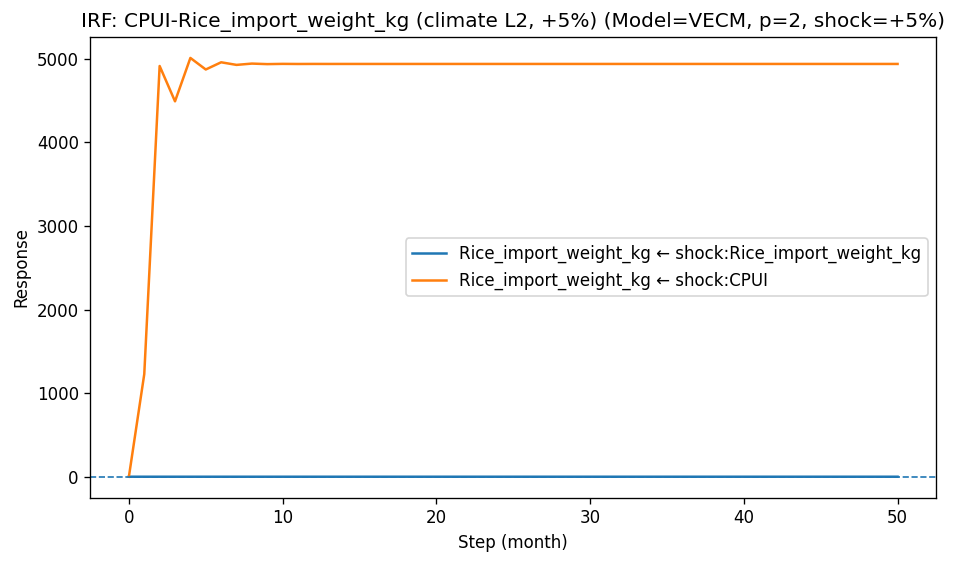

[DISPLAYED] CPUI-Rice_import_weight_kg (climate L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: climate | Level 3 | Crop: Wheat_import_weight_kg ===


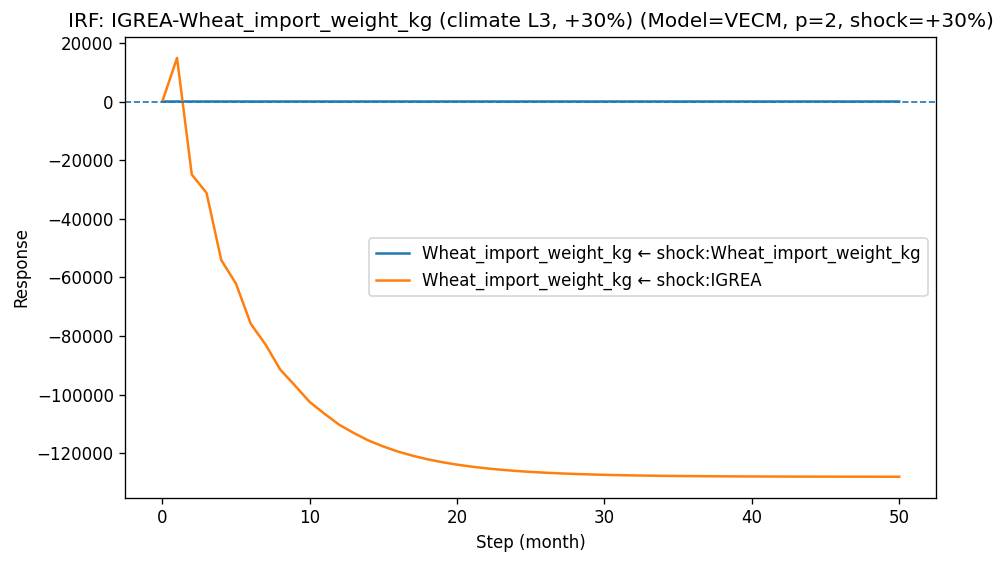

[DISPLAYED] IGREA-Wheat_import_weight_kg (climate L3, +30%) (Model=VECM, p=2, shock=+30%, n=125)


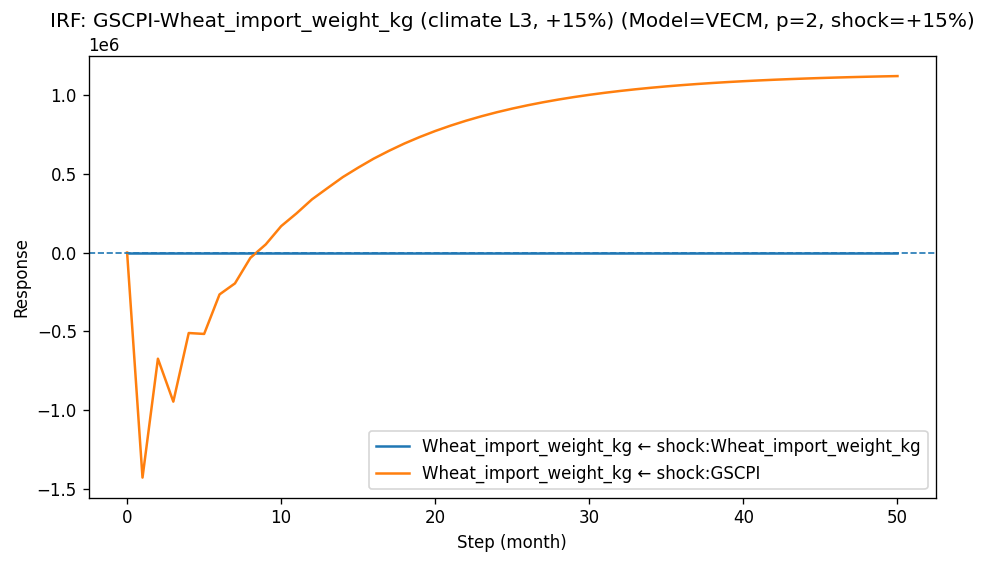

[DISPLAYED] GSCPI-Wheat_import_weight_kg (climate L3, +15%) (Model=VECM, p=2, shock=+15%, n=125)


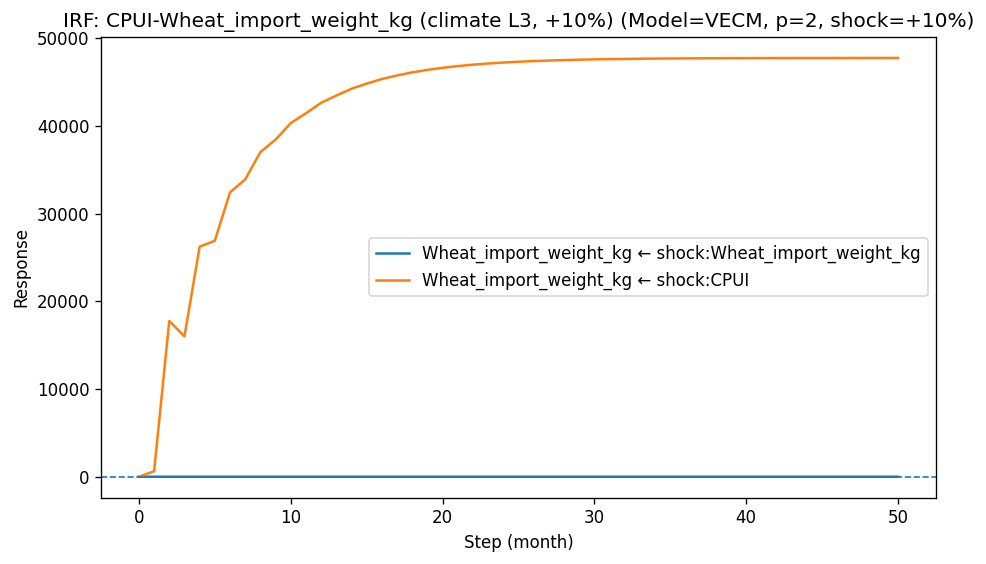

[DISPLAYED] CPUI-Wheat_import_weight_kg (climate L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)

=== Scenario: climate | Level 3 | Crop: Corn_import_weight_kg ===


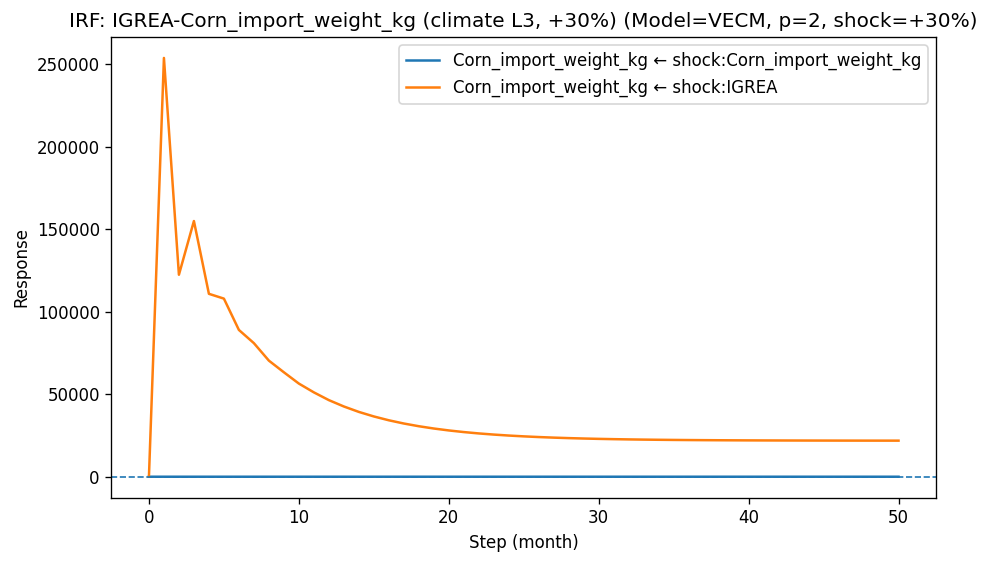

[DISPLAYED] IGREA-Corn_import_weight_kg (climate L3, +30%) (Model=VECM, p=2, shock=+30%, n=125)


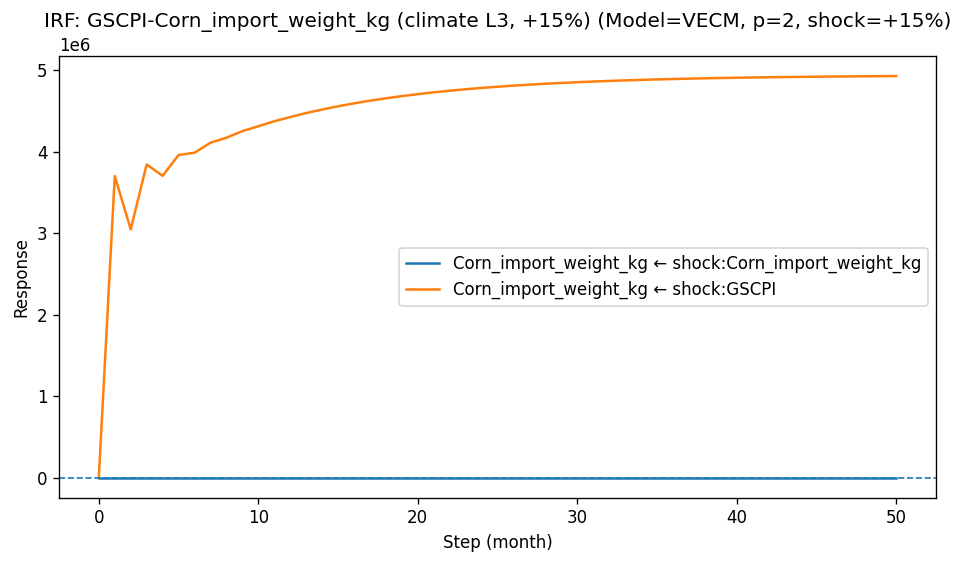

[DISPLAYED] GSCPI-Corn_import_weight_kg (climate L3, +15%) (Model=VECM, p=2, shock=+15%, n=125)


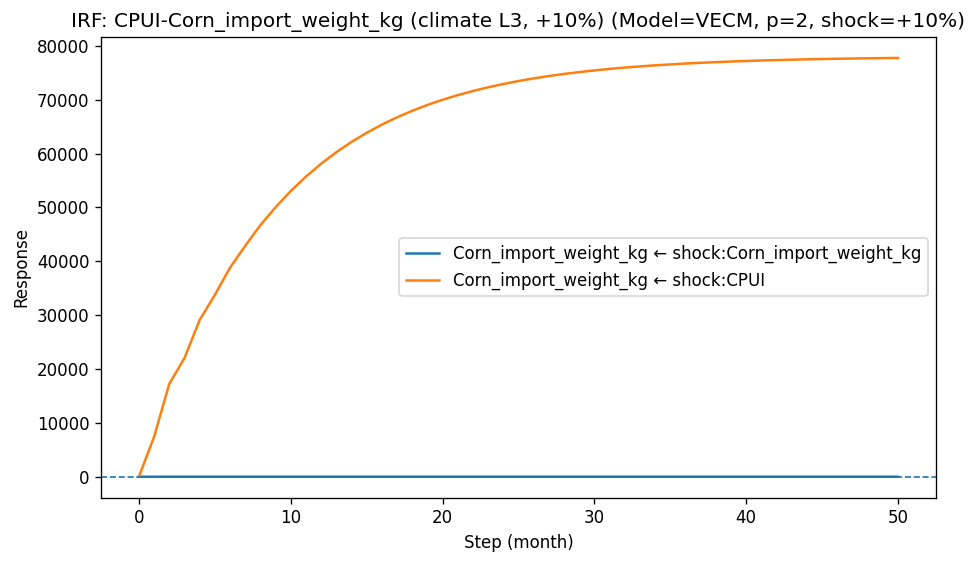

[DISPLAYED] CPUI-Corn_import_weight_kg (climate L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)

=== Scenario: climate | Level 3 | Crop: Rice_import_weight_kg ===


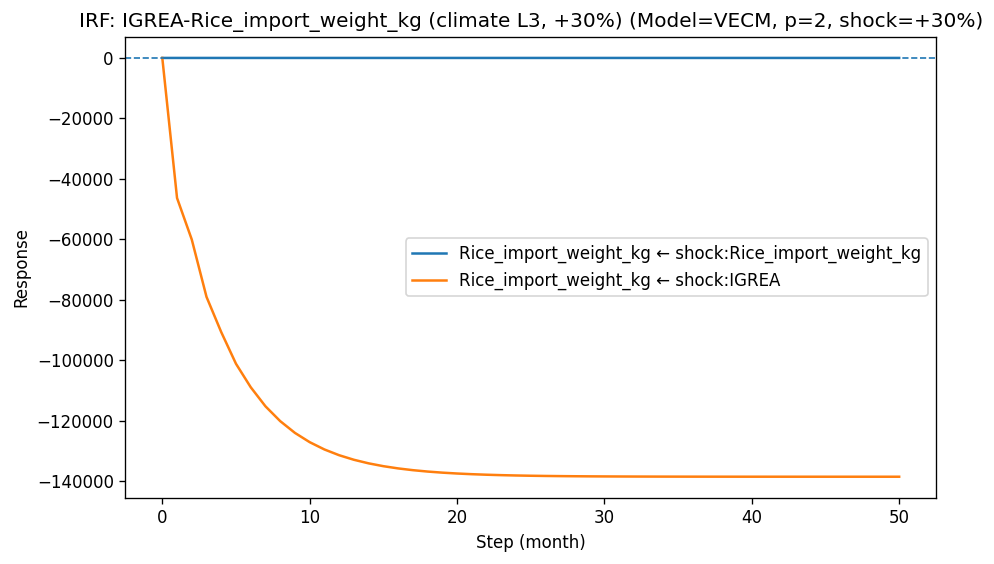

[DISPLAYED] IGREA-Rice_import_weight_kg (climate L3, +30%) (Model=VECM, p=2, shock=+30%, n=125)


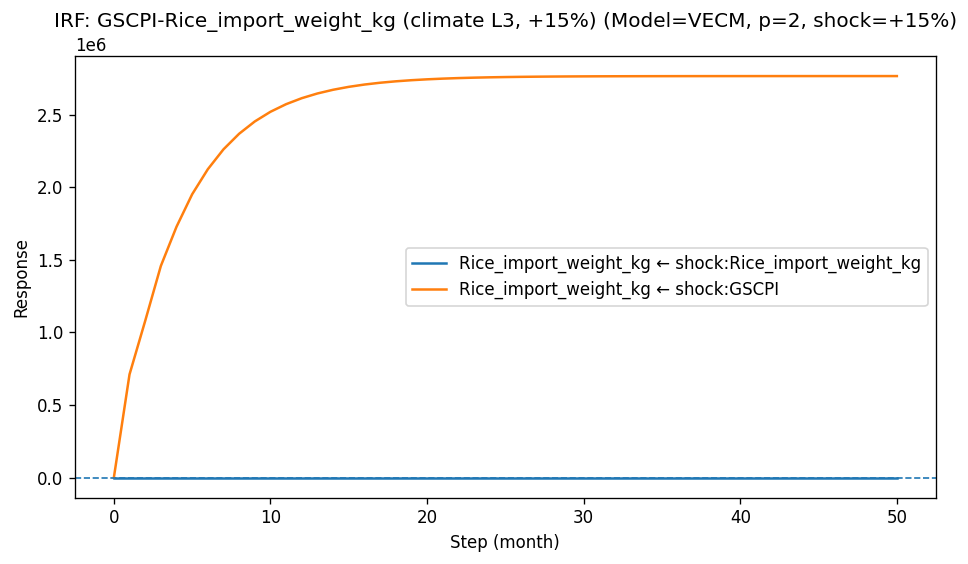

[DISPLAYED] GSCPI-Rice_import_weight_kg (climate L3, +15%) (Model=VECM, p=2, shock=+15%, n=125)


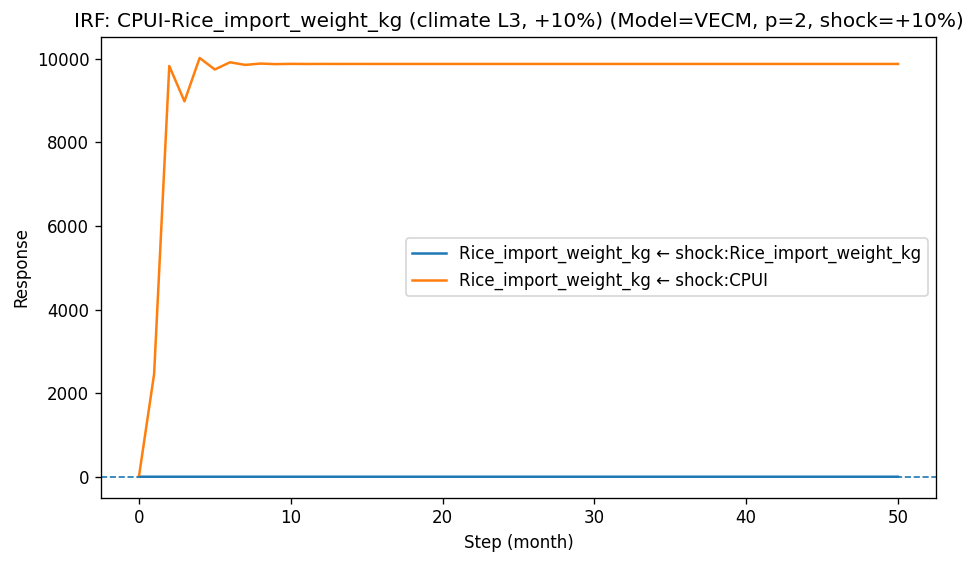

[DISPLAYED] CPUI-Rice_import_weight_kg (climate L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)


In [47]:
# 기후 재해 전체 실행
run_scenario_group("climate")


=== Scenario: policy | Level 1 | Crop: Wheat_import_weight_kg ===


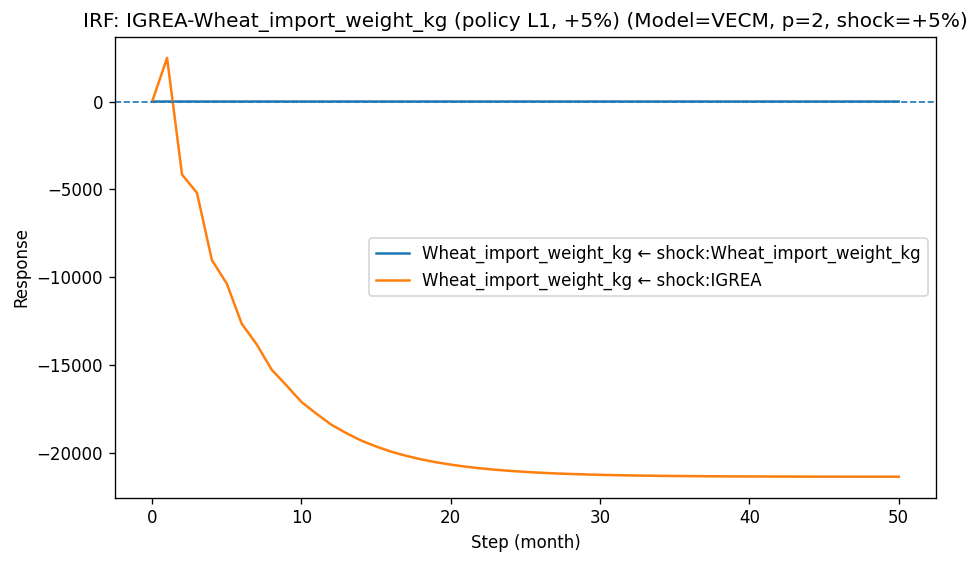

[DISPLAYED] IGREA-Wheat_import_weight_kg (policy L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


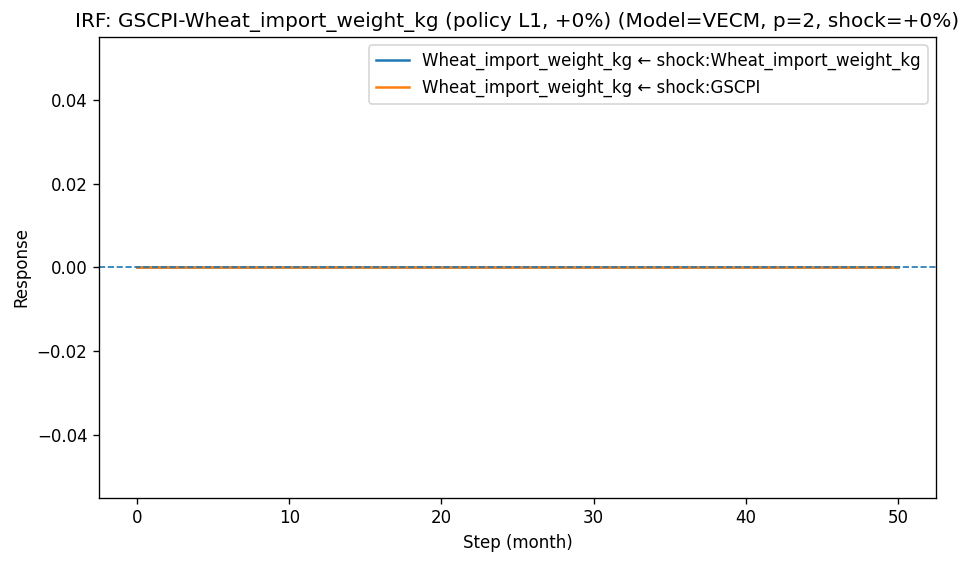

[DISPLAYED] GSCPI-Wheat_import_weight_kg (policy L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


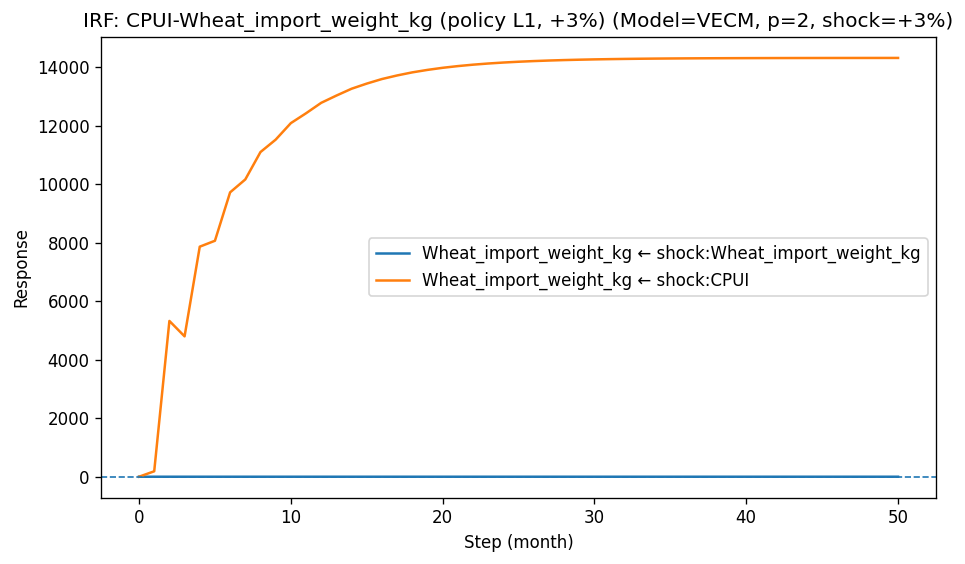

[DISPLAYED] CPUI-Wheat_import_weight_kg (policy L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: policy | Level 1 | Crop: Corn_import_weight_kg ===


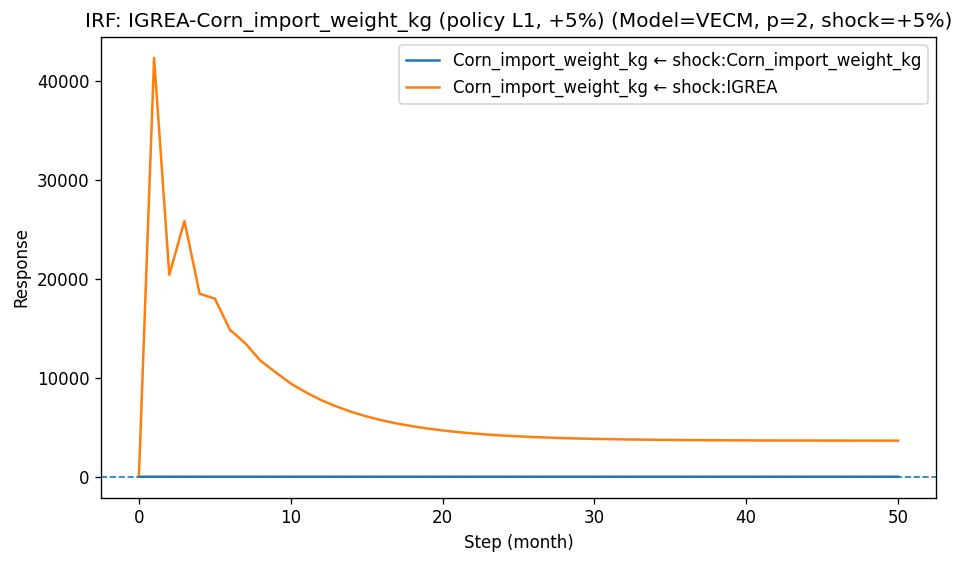

[DISPLAYED] IGREA-Corn_import_weight_kg (policy L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


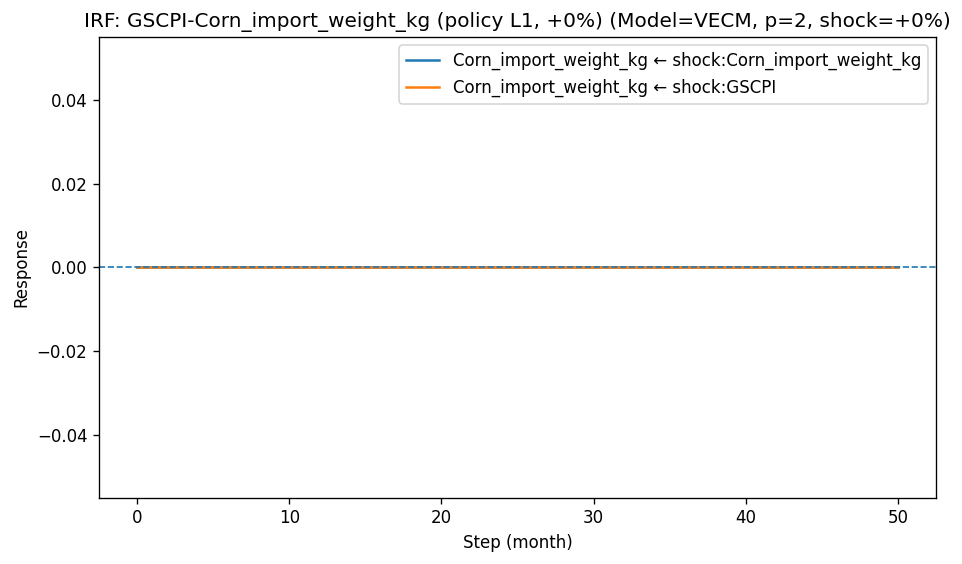

[DISPLAYED] GSCPI-Corn_import_weight_kg (policy L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


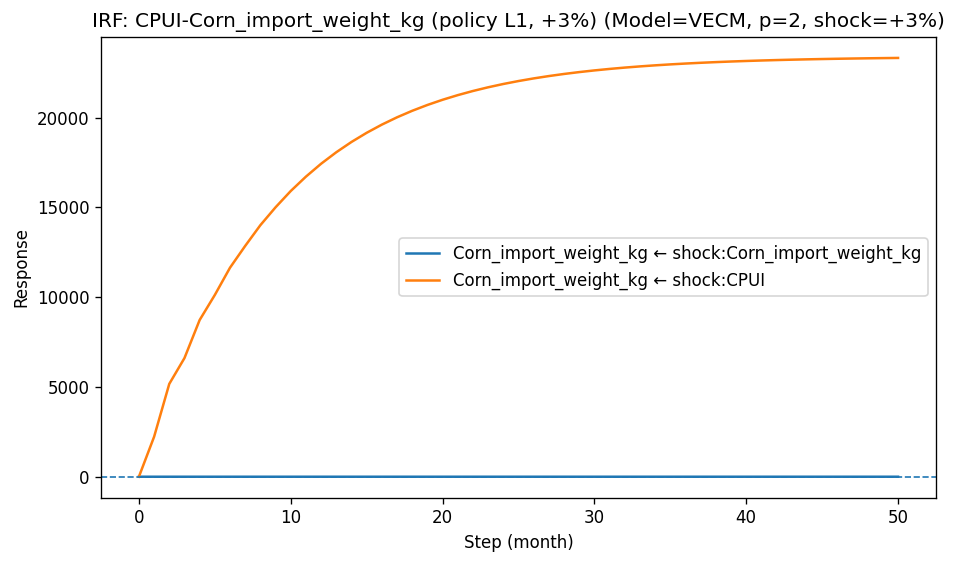

[DISPLAYED] CPUI-Corn_import_weight_kg (policy L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: policy | Level 1 | Crop: Rice_import_weight_kg ===


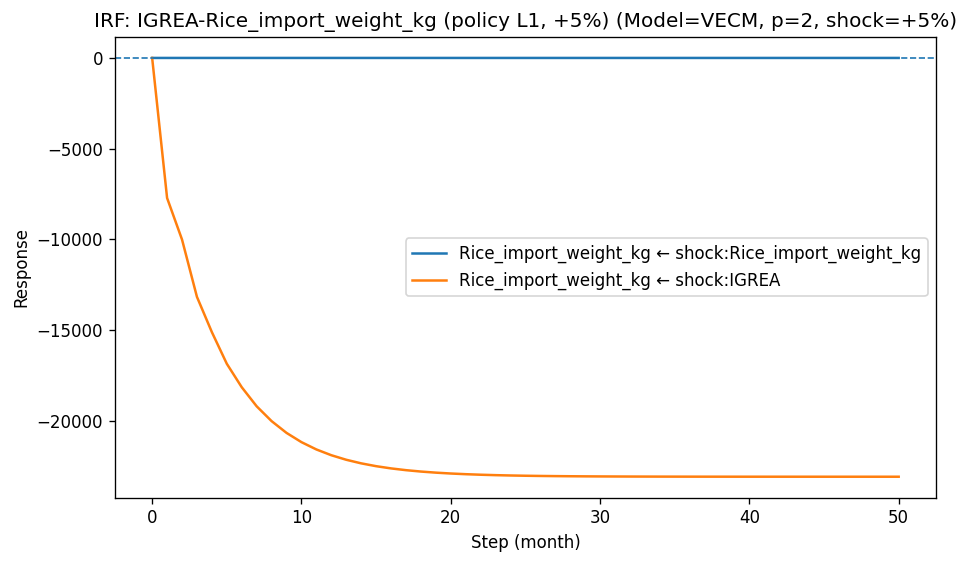

[DISPLAYED] IGREA-Rice_import_weight_kg (policy L1, +5%) (Model=VECM, p=2, shock=+5%, n=125)


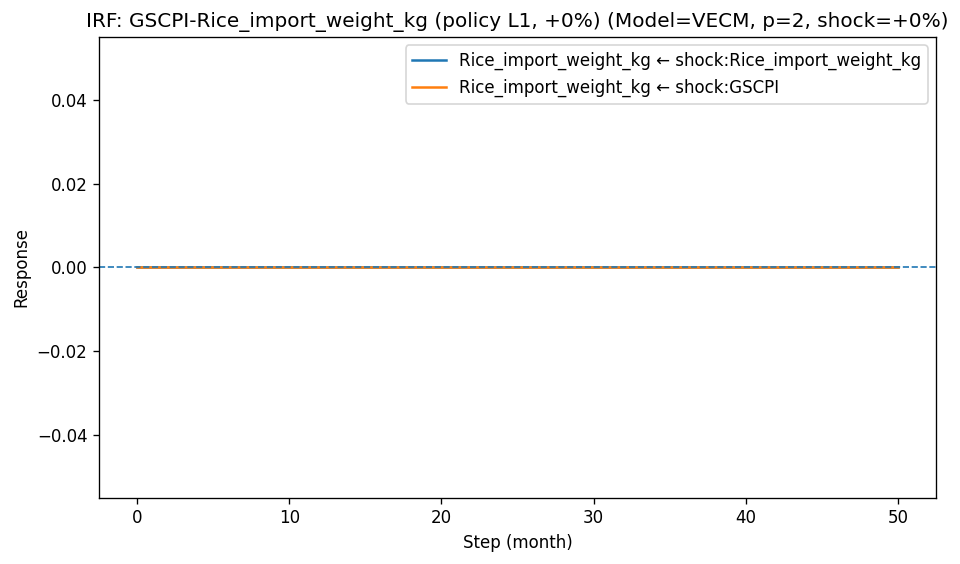

[DISPLAYED] GSCPI-Rice_import_weight_kg (policy L1, +0%) (Model=VECM, p=2, shock=+0%, n=125)


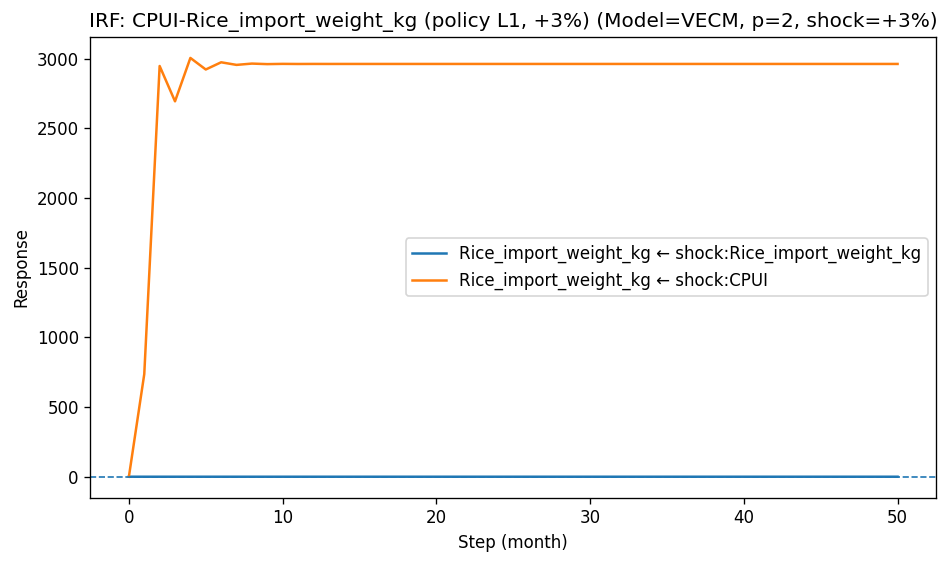

[DISPLAYED] CPUI-Rice_import_weight_kg (policy L1, +3%) (Model=VECM, p=2, shock=+3%, n=125)

=== Scenario: policy | Level 2 | Crop: Wheat_import_weight_kg ===


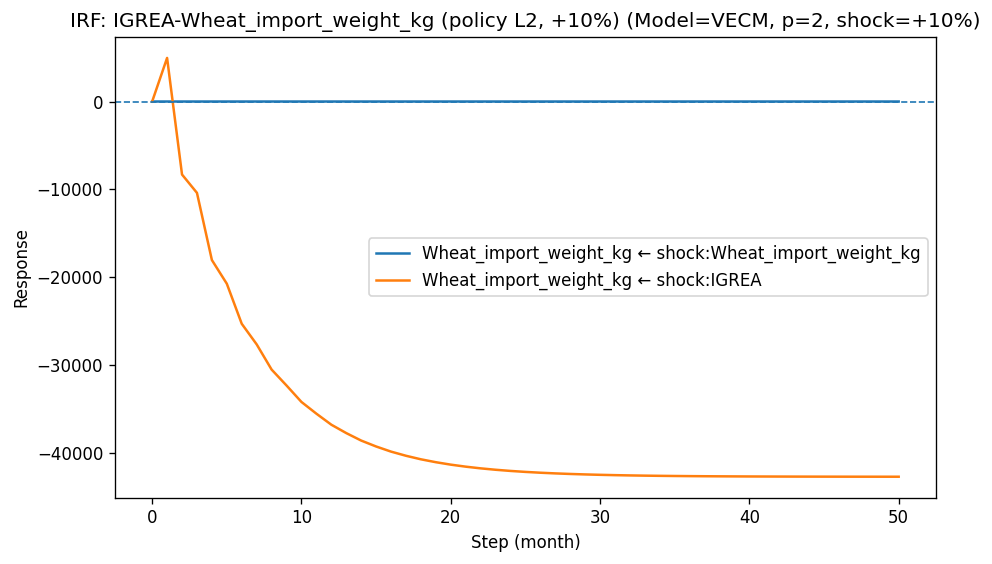

[DISPLAYED] IGREA-Wheat_import_weight_kg (policy L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


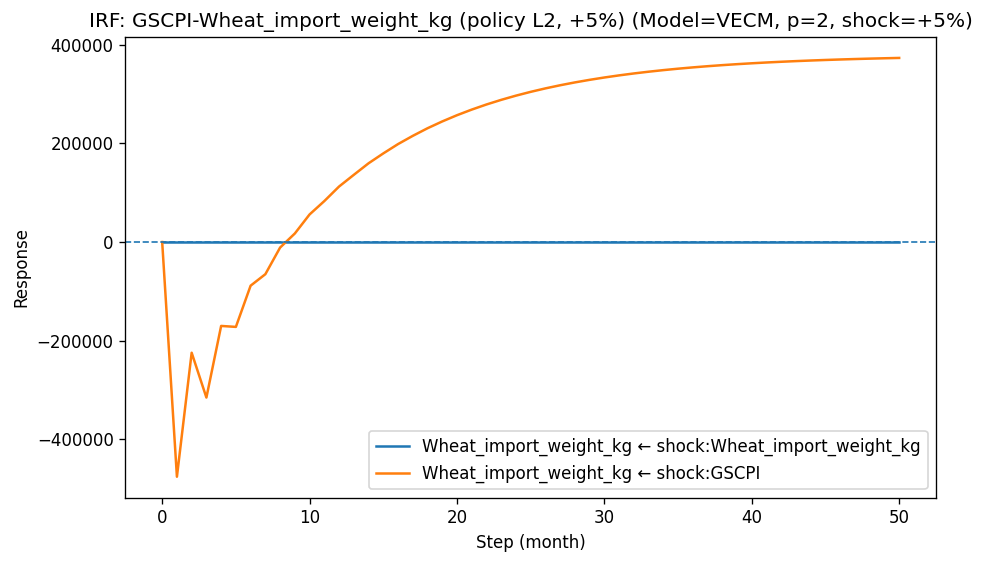

[DISPLAYED] GSCPI-Wheat_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)


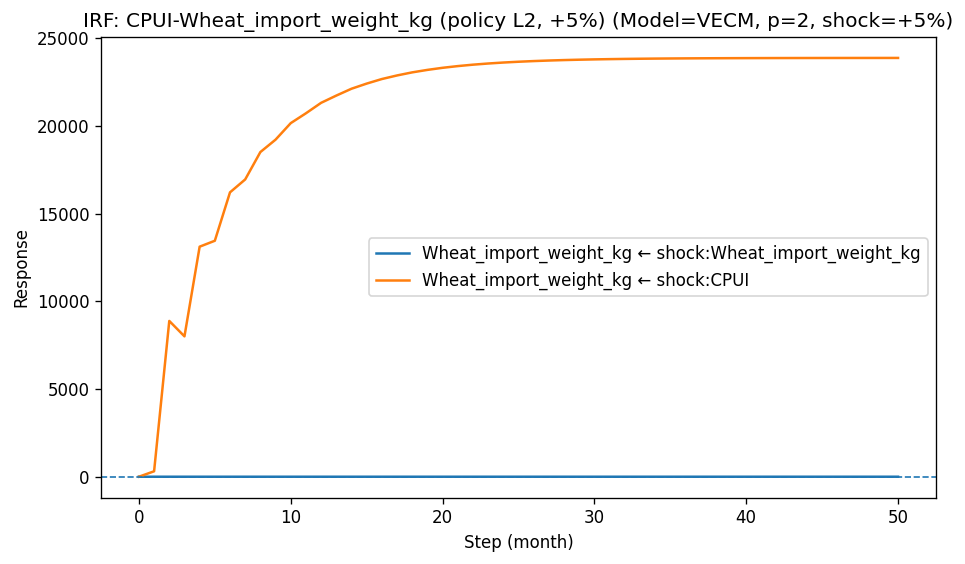

[DISPLAYED] CPUI-Wheat_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: policy | Level 2 | Crop: Corn_import_weight_kg ===


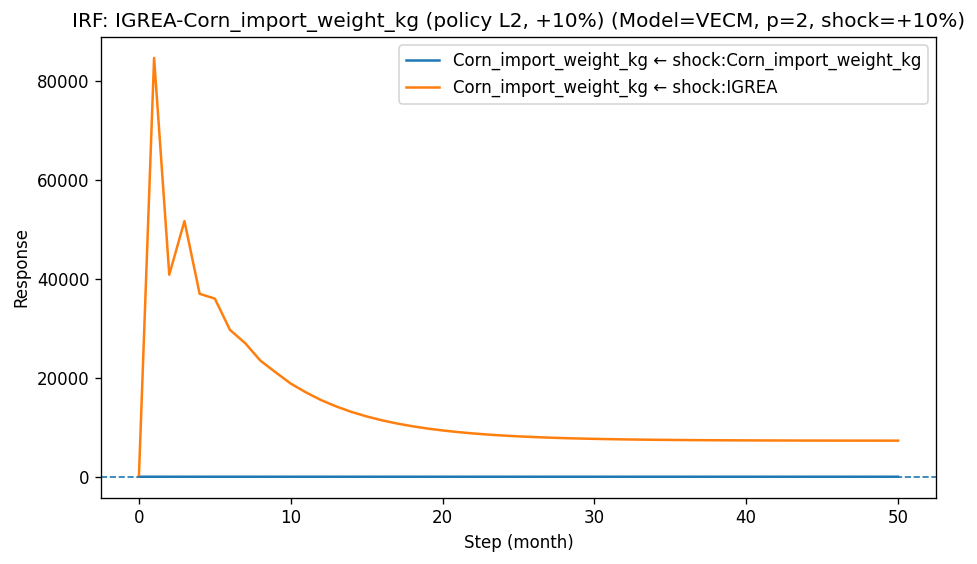

[DISPLAYED] IGREA-Corn_import_weight_kg (policy L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


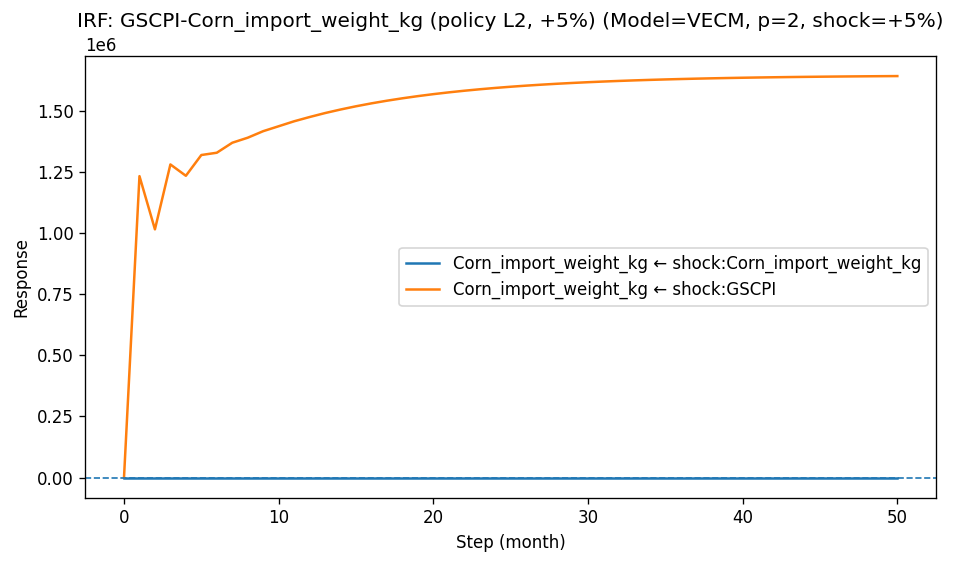

[DISPLAYED] GSCPI-Corn_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)


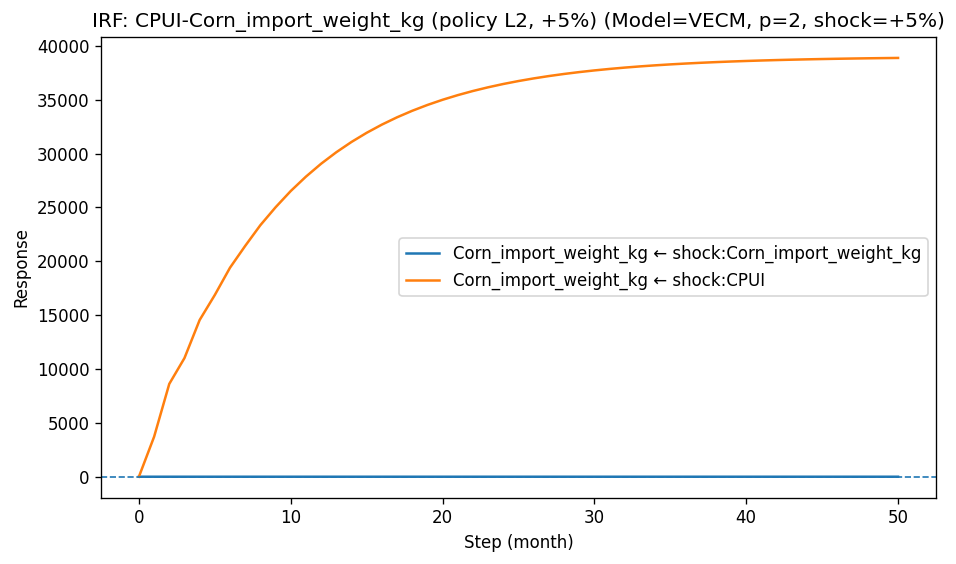

[DISPLAYED] CPUI-Corn_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: policy | Level 2 | Crop: Rice_import_weight_kg ===


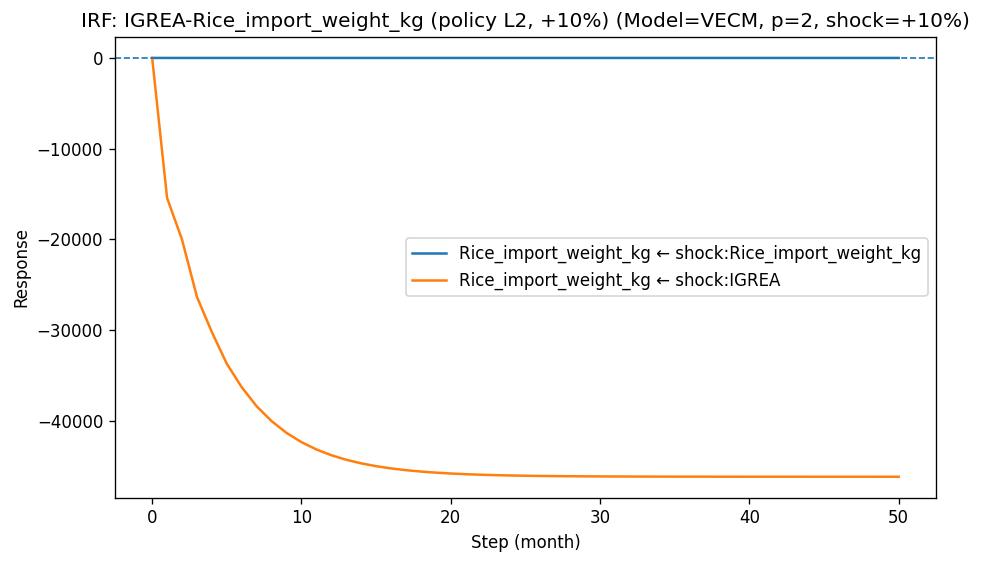

[DISPLAYED] IGREA-Rice_import_weight_kg (policy L2, +10%) (Model=VECM, p=2, shock=+10%, n=125)


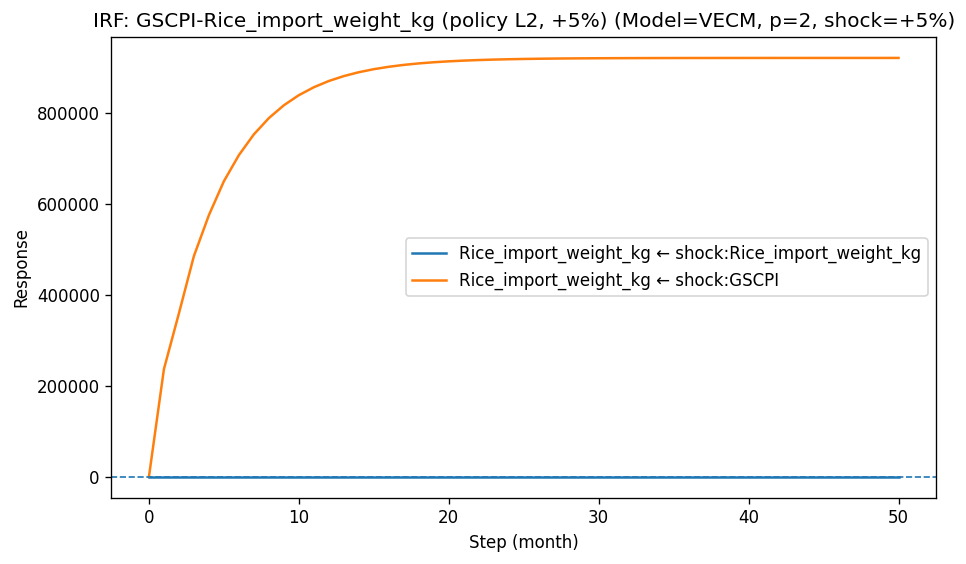

[DISPLAYED] GSCPI-Rice_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)


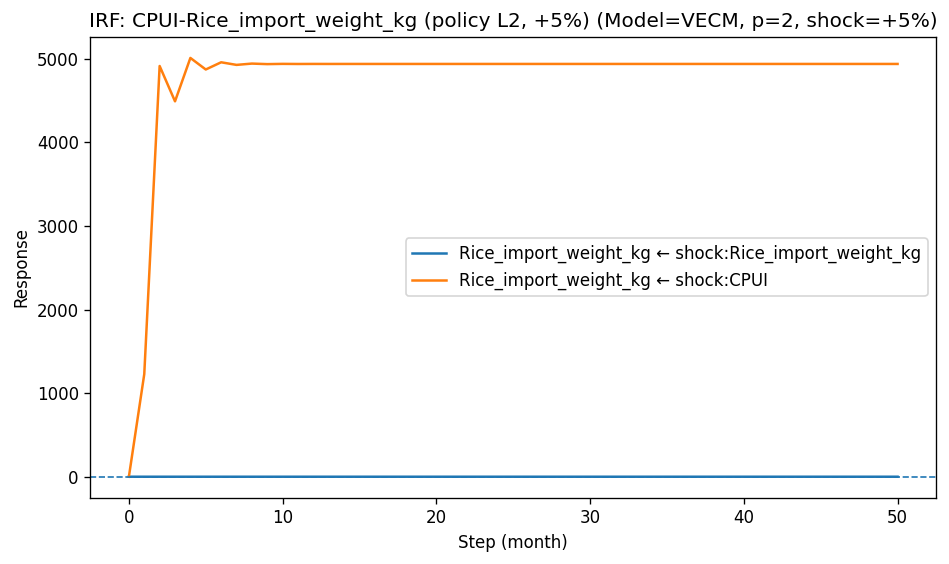

[DISPLAYED] CPUI-Rice_import_weight_kg (policy L2, +5%) (Model=VECM, p=2, shock=+5%, n=125)

=== Scenario: policy | Level 3 | Crop: Wheat_import_weight_kg ===


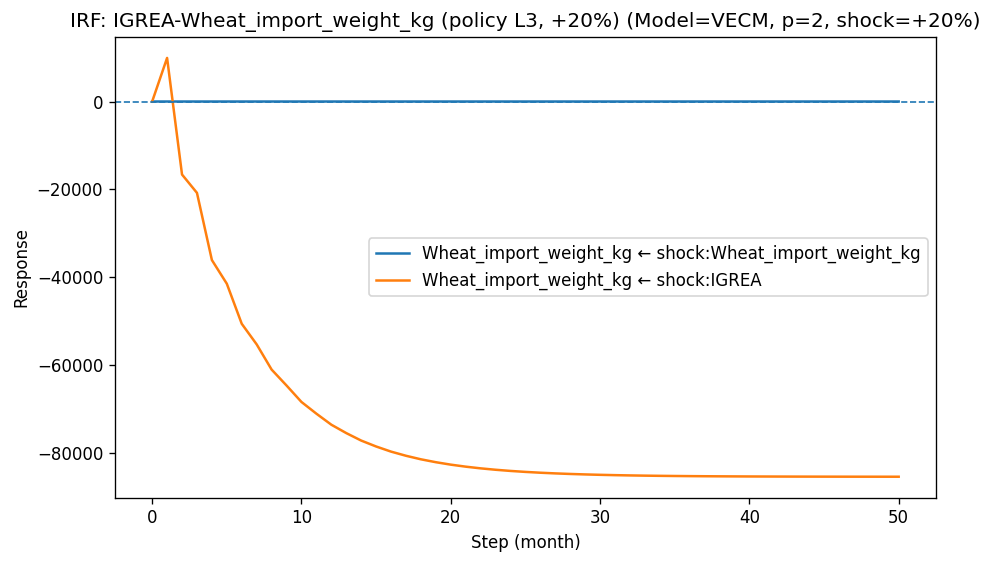

[DISPLAYED] IGREA-Wheat_import_weight_kg (policy L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


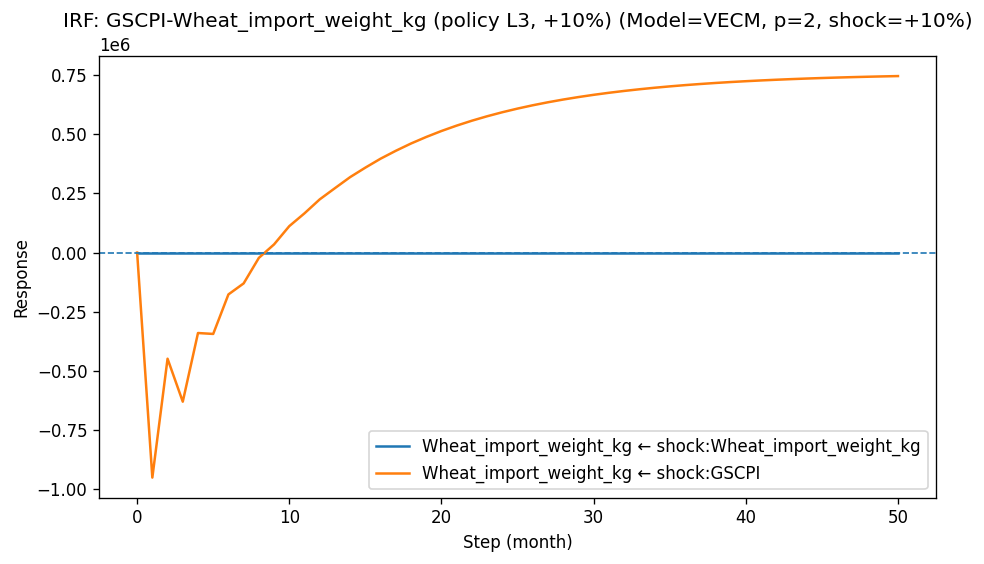

[DISPLAYED] GSCPI-Wheat_import_weight_kg (policy L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)


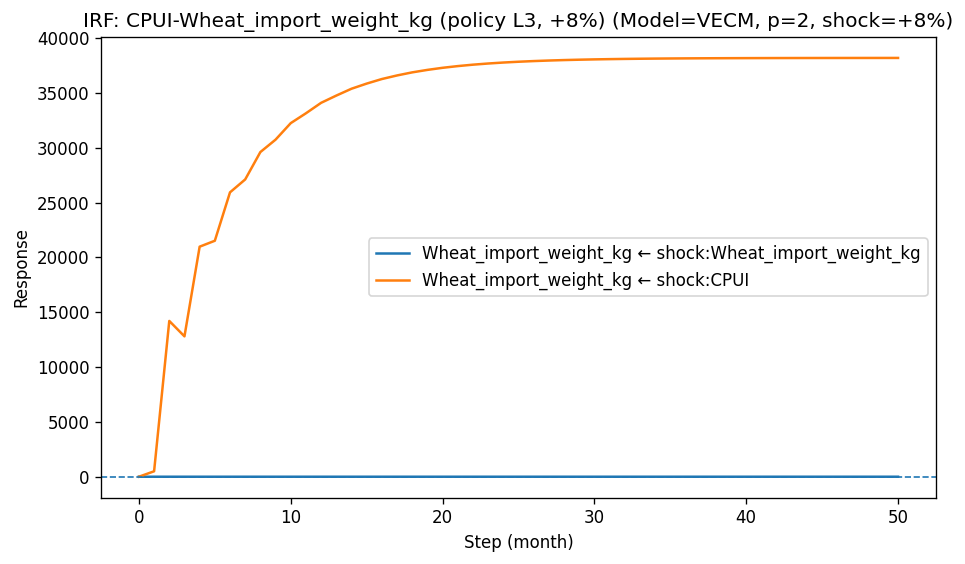

[DISPLAYED] CPUI-Wheat_import_weight_kg (policy L3, +8%) (Model=VECM, p=2, shock=+8%, n=125)

=== Scenario: policy | Level 3 | Crop: Corn_import_weight_kg ===


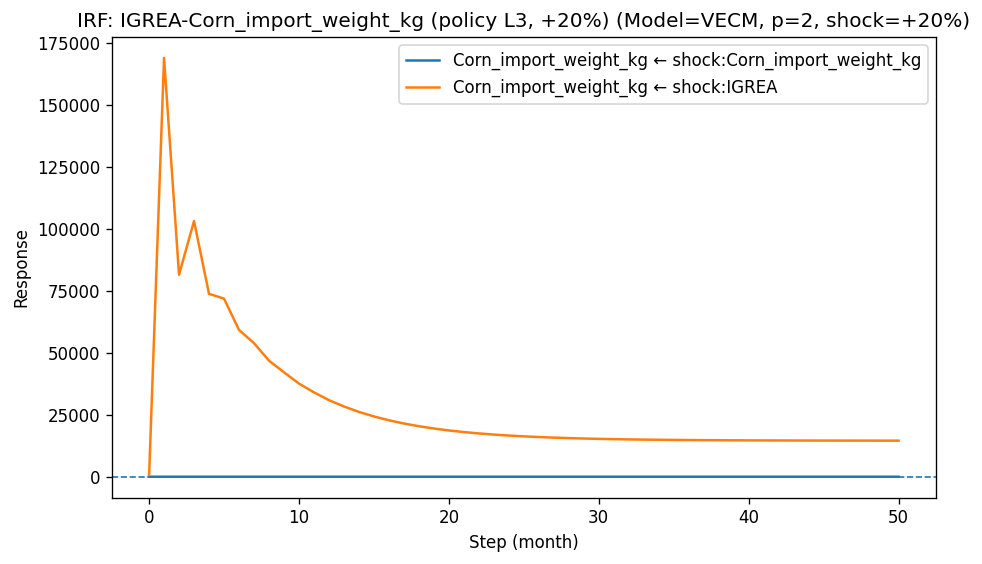

[DISPLAYED] IGREA-Corn_import_weight_kg (policy L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


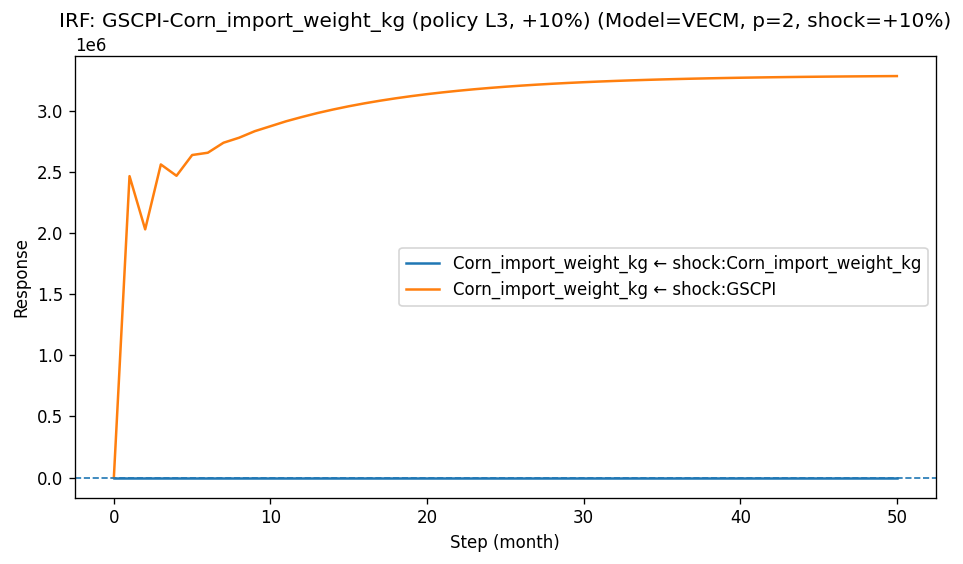

[DISPLAYED] GSCPI-Corn_import_weight_kg (policy L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)


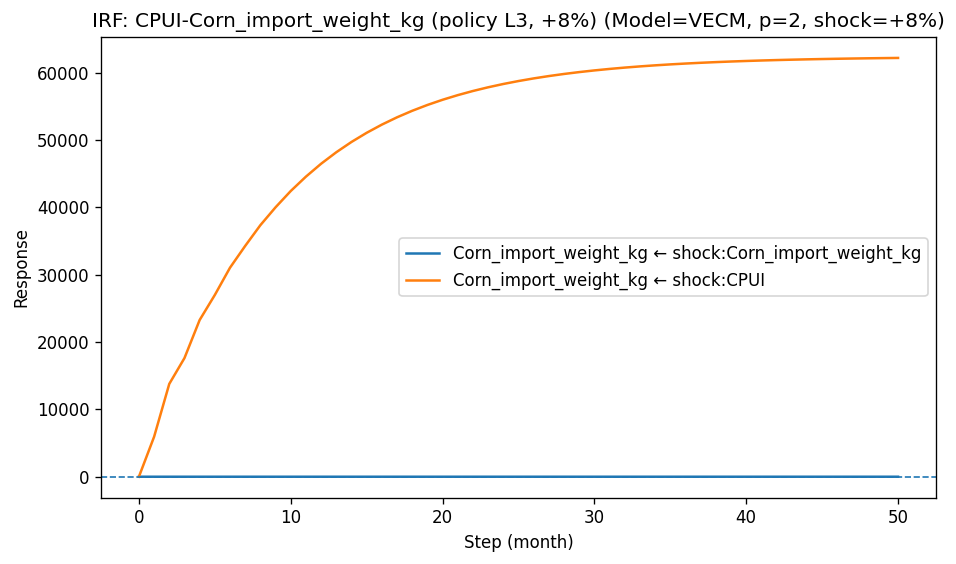

[DISPLAYED] CPUI-Corn_import_weight_kg (policy L3, +8%) (Model=VECM, p=2, shock=+8%, n=125)

=== Scenario: policy | Level 3 | Crop: Rice_import_weight_kg ===


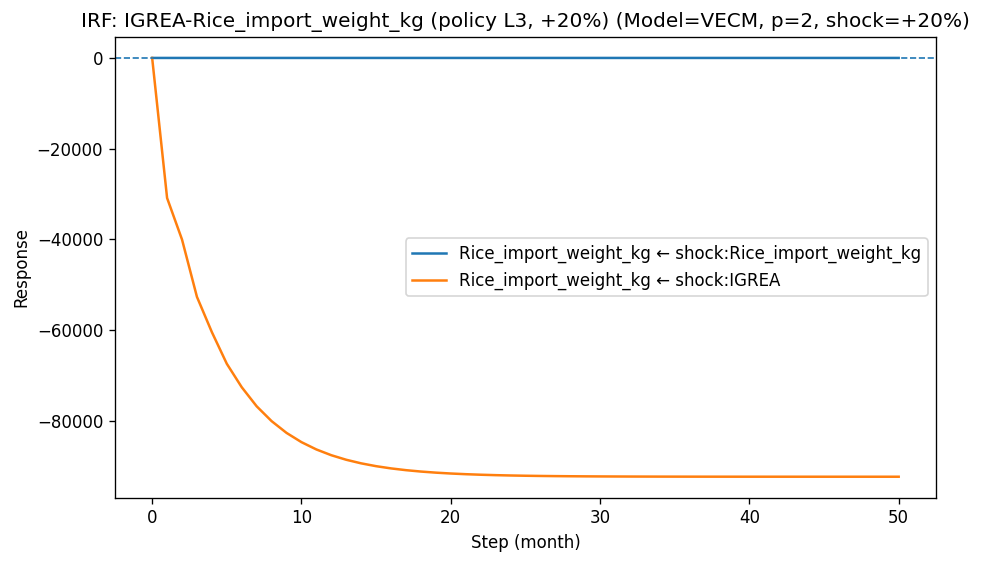

[DISPLAYED] IGREA-Rice_import_weight_kg (policy L3, +20%) (Model=VECM, p=2, shock=+20%, n=125)


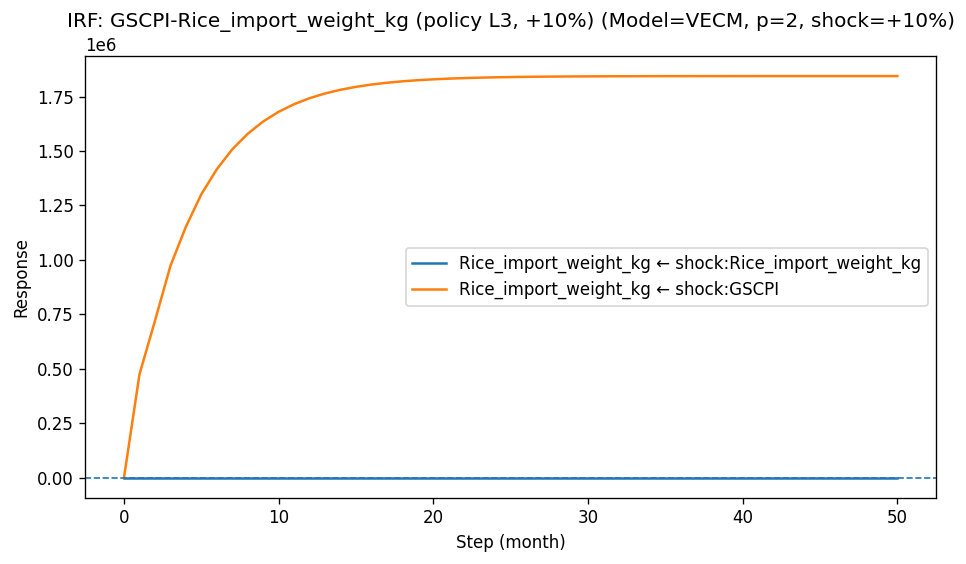

[DISPLAYED] GSCPI-Rice_import_weight_kg (policy L3, +10%) (Model=VECM, p=2, shock=+10%, n=125)


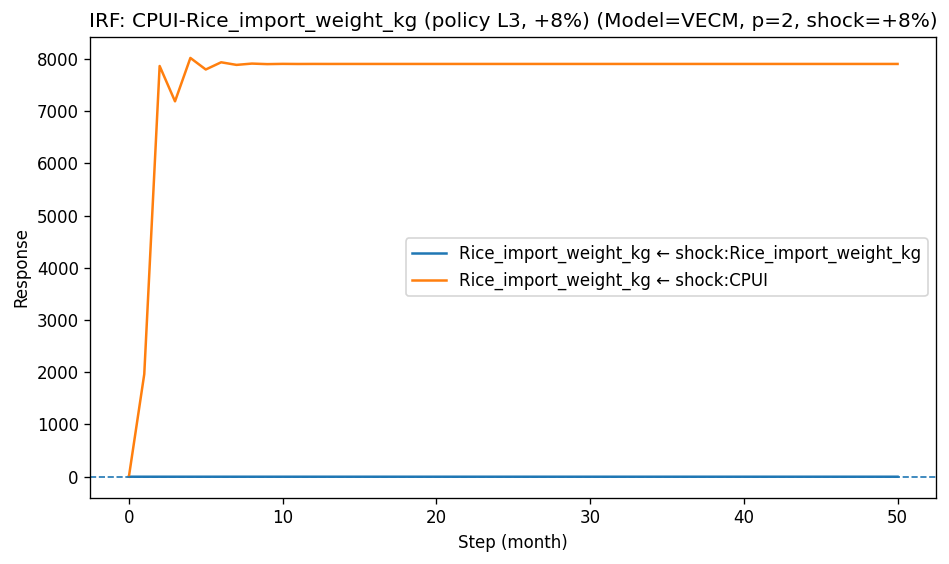

[DISPLAYED] CPUI-Rice_import_weight_kg (policy L3, +8%) (Model=VECM, p=2, shock=+8%, n=125)


In [48]:
# 정책/제재 전체 실행
run_scenario_group("policy")